In [401]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
import eli5

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from eli5.sklearn import PermutationImportance



In [402]:
test = pd.read_csv('./test.csv')
train = pd.read_csv('./train.csv')


In [403]:
train.info(verbose = True)
test.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  

In [404]:
train['set'] = 1
test['set'] = 0
train_test=train.append(other = test)
train_test.reset_index(drop = False, inplace = True)

In [406]:

# Dealing with missing value in CryoSleep with billing feature vice versa
non_sleeping_features = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
train_test.loc[:,non_sleeping_features]=train_test.apply(lambda x: 0 if x.CryoSleep == True else x,axis =1)
train_test['Expenses'] = train_test.loc[:,non_sleeping_features].sum(axis=1)
train_test.loc[:,['CryoSleep']]=train_test.apply(lambda x: True if x.Expenses == 0 and pd.isna(x.CryoSleep) else x,axis =1)
train_test.loc[:,['CryoSleep']]=train_test.apply(lambda x: False if x.Expenses != 0 and pd.isna(x.CryoSleep) else x,axis =1)

In [407]:
train_test.loc[:,['FirstName']] = train_test.Name.str.split(" ",expand=True).iloc[:,0]
train_test.loc[:,['LastName']] = train_test.Name.str.split(" ",expand=True).iloc[:,1]

In [408]:
# Generate new feature from existing features
train_test.loc[:,['group']] = train_test.PassengerId.apply(lambda x: x[0:4] ).astype('int')
train_test.loc[:,['id']] = train_test.PassengerId.apply(lambda x: x.split("_")[1]).astype('int')

train_test['group_size']=train_test['group'].map(lambda x: train_test['group'].value_counts()[x])
train_test["Financial"] = train_test["Expenses"].apply(lambda x: "poor" if x < 1500 else ("middle" if x>5000 and x<10000 else ("no_expense" if x == 0 else "rich")))

In [410]:
def add_traveller_type(df):

    checkdict ={

    }
    newColumnTravellerType = []

    for index in range(len(df)):
        gggg =df.iloc[index]['PassengerId'].split('_')[0]
        if df.iloc[index]['Name'] != df.iloc[index]['Name'] :
            lastname = 'NA'
        else :
            lastname =df.iloc[index]['Name'].split(' ')[1]
        if gggg in checkdict:
            checkdict[gggg].append(lastname)
        else :
            checkdict[gggg] = [lastname]

    for index in range(len(df)):
        gggg =df.iloc[index]['PassengerId'].split('_')[0]
        lastnames = checkdict[gggg]
        lastname = 'NA'
        if df.iloc[index]['Name'] == df.iloc[index]['Name'] :
            lastname =df.iloc[index]['Name'].split(' ')[1]

        if len(lastnames) == 1:
            newColumnTravellerType.append('INDIVIDUAL')
        elif len(lastnames) > 1:
            if lastname != 'NA' and lastnames.count(lastname) > 1:
                newColumnTravellerType.append('FAMILY')
            else :
                newColumnTravellerType.append('GROUP')

    df['TravellerType'] = newColumnTravellerType
    return df

train_test=  add_traveller_type(train_test)

In [411]:
# From inspecting impact of same group's member, we can found out that same group's members come from 
# same planet and has high probability is from same family (i.e same last name), same cabin

group_Cabin     = train_test.loc[:,['group','Cabin']].dropna().drop_duplicates('group')
group_LastName = train_test.loc[:,['group','LastName']].dropna().drop_duplicates('group')
group_HomePlanet  = train_test.loc[:,['group','HomePlanet']].dropna().drop_duplicates('group')
train_test      = pd.merge(train_test,group_Cabin,how="left",on='group',suffixes=('','_y'))
train_test      = pd.merge(train_test,group_LastName,how="left",on='group',suffixes=('','_y'))
train_test      = pd.merge(train_test,group_HomePlanet,how="left",on='group',suffixes=('','_y'))

# Fill in the missing value related to group
train_test.loc[:,['Cabin']]=train_test.apply(lambda x:  x.Cabin_y if pd.isna(x.Cabin) else x,axis=1)
train_test.loc[:,['HomePlanet']]=train_test.apply(lambda x:  x.HomePlanet_y if pd.isna(x.HomePlanet) else x,axis=1)
train_test.loc[:,['LastName']]=train_test.apply(lambda x:  x.LastName_y if pd.isna(x.LastName) else x,axis=1)

In [412]:
train_test.loc[:,['Cabin_deck']] = train_test.Cabin.str.split("/",expand=True).iloc[:,0]
train_test.loc[:,['Cabin_num']] = train_test.Cabin.str.split("/",expand=True).iloc[:,1]
train_test.loc[:,['Cabin_side']] = train_test.Cabin.str.split("/",expand=True).iloc[:,2]

train_test['Cabin_num' ].fillna(value = -1, inplace = True)
train_test['Cabin_num'] = train_test['Cabin_num'].astype(dtype = 'int')


In [413]:
def cabin_regions(df):
    df["Cabin_Region1"] = (df["Cabin_num"]<300)
    df["Cabin_Region2"] = (df["Cabin_num"]>=300) & (df["Cabin_num"]<600)
    df["Cabin_Region3"] = (df["Cabin_num"]>=600) & (df["Cabin_num"]<900)
    df["Cabin_Region4"] = (df["Cabin_num"]>=900) & (df["Cabin_num"]<1200)
    df["Cabin_Region5"] = (df["Cabin_num"]>=1200) & (df["Cabin_num"]<1500)
    df["Cabin_Region6"] = (df["Cabin_num"]>=1500)

    return df

train_test = cabin_regions(train_test)

train_test['Age_group'] = 0
train_test.loc[train_test['Age']  == 0, 'Age_group'] = 1
train_test.loc[(train_test['Age'] > 0) & (train_test['Age'] <= 10), 'Age_group']=2
train_test.loc[(train_test['Age'] > 10) & (train_test['Age'] <= 20), 'Age_group']=3
train_test.loc[(train_test['Age'] > 20) & (train_test['Age'] <= 30), 'Age_group']=4
train_test.loc[(train_test['Age'] > 30) & (train_test['Age'] <= 50), 'Age_group']=5
train_test.loc[(train_test['Age'] > 50) & (train_test['Age'] <= 60), 'Age_group']=6
train_test.loc[(train_test['Age'] > 60) & (train_test['Age'] <= 70), 'Age_group']=7
train_test.loc[train_test['Age']  > 70, 'Age_group'] = 8


In [415]:
num_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Expenses']
cat_cols = ['CryoSleep','Cabin_deck', 'Cabin_side','VIP','HomePlanet','Destination', 'TravellerType',
             'Financial', 'Cabin_Region1', 'Cabin_Region2', 'Cabin_Region3', 'Cabin_Region4', 'Cabin_Region5',
              'Cabin_Region6', 'Age_group', 'group_size']
transported=['Transported']
train_test_1 = train_test[num_cols+cat_cols+transported+['set', 'Age','Cabin_num']].copy()

num_imp = SimpleImputer(strategy='median')
cat_imp = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder (handle_unknown='ignore',sparse = False)
le = LabelEncoder()

# Filling other missing value unrelated to group
train_test[num_cols] = pd.DataFrame(num_imp.fit_transform(train_test_1[num_cols]),columns=num_cols)
train_test[cat_cols] = pd.DataFrame(cat_imp.fit_transform(train_test_1[cat_cols]),columns=cat_cols)
temp_train = pd.DataFrame(ohe.fit_transform(train_test_1[cat_cols]),columns= ohe.get_feature_names_out())
train_test_1 = train_test_1.drop(cat_cols,axis=1)
train_test_1 = pd.concat([train_test_1,temp_train],axis=1)


In [416]:
def get_score(model,X,y):
    n = cross_val_score(model,X,y,scoring ='accuracy',cv=20)
    return n

In [418]:
train = train_test_1[train_test['set']== 1].copy()
train.Transported =train.Transported.astype('int')
test = train_test_1[train_test['set'] == 0].drop("Transported",axis=1)
test = test.drop('set',axis=1)

In [419]:
X = train.drop(['set','Transported'],axis=1)
y = train.Transported

In [420]:
X,y = shuffle(X,y)
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [421]:
params_XGB_best= {  'tree_method': "hist",
                    'lambda': 3, 
                    'alpha': 4.58, 
                    'colsample_bytree': 0.9, 
                    'subsample': 0.95, 
                    'learning_rate': 0.07, 
                    'n_estimators': 800, 
                    'max_depth': 4, 
                    'min_child_weight': 1, 
                    'num_parallel_tree': 1}
print(get_score(xgb.XGBClassifier(**params_XGB_best),X,y).mean())

0.8077723926055406


In [422]:
def get_redundant_pairs(X):
    pairs_to_drop = set()
    cols = X.columns
    for i in range(0, X.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop
def get_top_abs_correlations(df, n=1):
    au_corr = X.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(X)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]
print("Top Absolute Correlations !")
print(get_top_abs_correlations(train.select_dtypes(include=['int32','int64']), 50))

Top Absolute Correlations !
CryoSleep_False           CryoSleep_True              1.000000
Cabin_Region4_False       Cabin_Region4_True          1.000000
Cabin_Region3_False       Cabin_Region3_True          1.000000
Cabin_Region5_False       Cabin_Region5_True          1.000000
TravellerType_INDIVIDUAL  group_size_1                1.000000
Cabin_deck_nan            Cabin_side_None             1.000000
Cabin_Region6_False       Cabin_Region6_True          1.000000
Cabin_Region2_False       Cabin_Region2_True          1.000000
Cabin_Region1_False       Cabin_Region1_True          1.000000
Cabin_side_P              Cabin_side_S                0.977477
TravellerType_FAMILY      group_size_1                0.902436
                          TravellerType_INDIVIDUAL    0.902436
Expenses                  CryoSleep_False             0.869318
                          CryoSleep_True              0.869318
Financial_poor            Financial_rich              0.838477
Cabin_num                 C

In [423]:
drop_list=["Age",'CryoSleep_True', 'VIP_False',
'FoodCourt', "Cabin_side_P",
'Cabin_Region3_False', 'Cabin_Region5_False', 'Cabin_Region2_False',
'Cabin_Region4_False','Cabin_Region6_False', 'Cabin_Region1_False',
'TravellerType_INDIVIDUAL', 'Financial_poor']

X_3=X.drop(drop_list,axis=1)
test_3=test.drop(drop_list,axis=1)
print(get_score(xgb.XGBClassifier(**params_XGB_best),X_3,y).mean())

0.8122554160707665


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.808231103342338 0.0020311158 49


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8074259759521161 0.0030991305 48


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8077700090047142 0.0038363256 47


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8047815032575878 0.0047061197 46


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8127210127655065 0.0060730595 45


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8044337623814821 0.0062044263 44


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8084620477779543 0.0065902867 43


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8043241167434715 0.0069097322 42


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8063914931934955 0.0072910716 41


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8074233275067535 0.0073271007 40


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8089218178928969 0.0076364432 39


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8060440171619259 0.008033538 38


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8071971502727898 0.008087342 37


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8068509984639016 0.008243285 36


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8059341066793791 0.008309428 35


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8073065310662642 0.0084162075 34


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8096120027543832 0.008699483 33


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8124921870861804 0.008810048 32


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8085793739075162 0.008900777 31


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8108792838603739 0.009220297 30


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8059314582340168 0.009476519 29


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8091554107738756 0.00985035 28


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8096130621325284 0.009865644 27


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8071995338736162 0.009933814 26


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8097290640394089 0.010830293 25


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8126010381905822 0.012006756 24


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8100664759786007 0.012100366 23


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8082287197415117 0.012393826 22


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8102958313469992 0.012456483 21


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8076542719423699 0.014412157 20


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8114502886805444 0.01492521 19


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8088050214524072 0.015219058 18


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8043148471847024 0.015586681 17


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8091519677949044 0.016487118 16


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8079988346840405 0.016935427 15


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.7876344086021506 0.016991714 14


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.7818878118544415 0.018856147 13


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.7561144658085703 0.021169316 12


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.7461123470522802 0.022016479 11


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.7465699984109327 0.022231702 10


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


KeyboardInterrupt: 

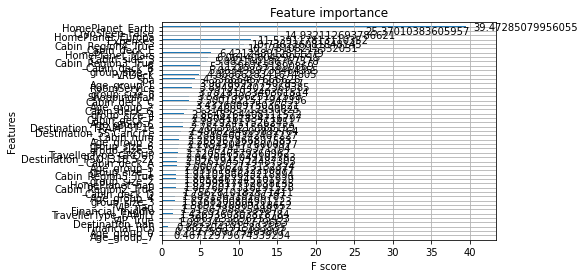

In [424]:
from numpy import sort 
from sklearn.feature_selection import SelectFromModel

model = xgb.XGBClassifier()
model.fit(X_3, y)
xgb.plot_importance(model, importance_type='gain')
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    if thresh > 0.:
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        X_selected = selection.transform(X_3).copy()
        xxx = xgb.XGBClassifier()
        xxx.fit(X_selected, y)
        print(get_score(xxx, X_selected, y).mean(), thresh, X_selected.shape[1])
    

In [434]:
model = xgb.XGBClassifier()
model.fit(X_3, y)
selection = SelectFromModel(model, threshold=0.008810048, prefit=True)
X_selected = selection.transform(X_3).copy()
test_selected = selection.transform(test_3).copy()
xxx = xgb.XGBClassifier()
xxx.fit(X_selected, y)
#print(get_score(xxx, X_selected, y).mean(), X_selected)


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [446]:
params_XGB_best= {  'lambda': 4.405579557265726, 'alpha': 1.7476255375975969, 'colsample_bytree': 0.8369315652077642, 'subsample': 0.9805442810857051, 'learning_rate': 0.07660148502938892, 'n_estimators': 560, 'max_depth': 4, 'min_child_weight': 6}
                    
#print(get_score(xgb.XGBClassifier(**params_XGB_best),X_selected,y).mean())
pred_XGB_best = (xgb.XGBClassifier(**params_XGB_best).fit(X_selected,y)).predict(test_selected)
sample = pd.read_csv('./sample_submission.csv')
sample['Transported'] = pred_XGB_best
sample['Transported']=sample['Transported']>0.5
sample.to_csv('311605002.csv', index=False)

In [445]:
import optuna 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

skf = StratifiedKFold(n_splits=10)
X_selected = pd.DataFrame(X_selected)
def objective(trial, X = X_selected, y = y):
    print("START__________________________________")
    param = {  
        'tree_method':'hist',
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'lambda': trial.suggest_float('lambda', 0, 5.0),
        'alpha': trial.suggest_float('alpha', 0, 5.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7,1.0),
        'subsample': trial.suggest_float('subsample', 0.7,1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001,0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100,1200),
        'max_depth': trial.suggest_categorical('max_depth', [3,4,5,6,7, 8, 9, 10 ]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300)
        #'early_stopping_rounds':200,
        }
    
    results=[]
    n_iterations=[]
    for train_index, test_index in skf.split(X, y):
        train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
        train_y, valid_y = y.iloc[train_index], y.iloc[test_index]
        model = xgb.XGBClassifier(**param).fit(train_X,train_y,
                                      eval_set=[(valid_X,valid_y)],
                                      verbose=0
                                     )  
        #n_iteration = model.get_booster().best_iteration
        #n_iterations.append(n_iteration)
        result = accuracy_score(valid_y,(model.predict(valid_X)))
        results.append(result)
        #i=int(sum(n_iterations)/len(n_iterations))
   # print("Average n_ite=" + str(i))
   # print("% of scatter =" + str(np.std(n_iterations)/i))    
    n=sum(results)/len(results) 
    print (n)
    print("FINISH__________________________________\n")
    return n

optuna_study = "ON"
XGB_study = "ON"
if optuna_study == XGB_study:
    study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
                                direction='maximize')
    study.optimize(objective, n_trials=500)

[I 2023-06-17 19:49:32,157] A new study created in memory with name: no-name-3478f723-ee34-4dc1-a65c-d9f1d16694ce


START__________________________________


[I 2023-06-17 19:49:35,866] Trial 0 finished with value: 0.7823483195111306 and parameters: {'lambda': 2.2479267905371465, 'alpha': 2.2648148183396772, 'colsample_bytree': 0.7494361672326811, 'subsample': 0.772107592276219, 'learning_rate': 0.02143372921902388, 'n_estimators': 278, 'max_depth': 5, 'min_child_weight': 173}. Best is trial 0 with value: 0.7823483195111306.


0.7823483195111306
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:49:49,922] Trial 1 finished with value: 0.8014441225877279 and parameters: {'lambda': 2.755773715401374, 'alpha': 1.2919789369378383, 'colsample_bytree': 0.8829700617848046, 'subsample': 0.8925280993931664, 'learning_rate': 0.07269172479207998, 'n_estimators': 961, 'max_depth': 5, 'min_child_weight': 45}. Best is trial 1 with value: 0.8014441225877279.


0.8014441225877279
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:49:59,142] Trial 2 finished with value: 0.7581901511844767 and parameters: {'lambda': 1.048983646106184, 'alpha': 4.22709509147607, 'colsample_bytree': 0.7652886639128113, 'subsample': 0.8989475215799677, 'learning_rate': 0.0019148227658599872, 'n_estimators': 733, 'max_depth': 10, 'min_child_weight': 250}. Best is trial 1 with value: 0.8014441225877279.


0.7581901511844767
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:50:10,192] Trial 3 finished with value: 0.7717651415949104 and parameters: {'lambda': 3.133694954004258, 'alpha': 2.7772118982668745, 'colsample_bytree': 0.8544009972137989, 'subsample': 0.7323982612392936, 'learning_rate': 0.06216144112063147, 'n_estimators': 1019, 'max_depth': 7, 'min_child_weight': 242}. Best is trial 1 with value: 0.8014441225877279.


0.7717651415949104
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:50:13,343] Trial 4 finished with value: 0.7790126053198947 and parameters: {'lambda': 1.285876177800297, 'alpha': 0.21607869038428484, 'colsample_bytree': 0.8442547625715993, 'subsample': 0.7943135914700025, 'learning_rate': 0.0046868036376643465, 'n_estimators': 169, 'max_depth': 8, 'min_child_weight': 83}. Best is trial 1 with value: 0.8014441225877279.


0.7790126053198947
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:50:17,071] Trial 5 finished with value: 0.7708453368252582 and parameters: {'lambda': 3.0680222890802837, 'alpha': 4.465234760154116, 'colsample_bytree': 0.7949037657928754, 'subsample': 0.8372208014139573, 'learning_rate': 0.09474859922203915, 'n_estimators': 344, 'max_depth': 8, 'min_child_weight': 271}. Best is trial 1 with value: 0.8014441225877279.


0.7708453368252582
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:50:21,998] Trial 6 finished with value: 0.7845334179860586 and parameters: {'lambda': 4.3611425677694164, 'alpha': 2.4085471002412424, 'colsample_bytree': 0.7258212066121787, 'subsample': 0.884181009203819, 'learning_rate': 0.04384639087568523, 'n_estimators': 396, 'max_depth': 7, 'min_child_weight': 209}. Best is trial 1 with value: 0.8014441225877279.


0.7845334179860586
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:50:27,166] Trial 7 finished with value: 0.7836132164067563 and parameters: {'lambda': 0.36831498256827466, 'alpha': 4.7231618179003485, 'colsample_bytree': 0.8142984876272958, 'subsample': 0.742309036977537, 'learning_rate': 0.03546086168621304, 'n_estimators': 411, 'max_depth': 9, 'min_child_weight': 169}. Best is trial 1 with value: 0.8014441225877279.


0.7836132164067563
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:50:31,231] Trial 8 finished with value: 0.795807441503644 and parameters: {'lambda': 3.2665423943297256, 'alpha': 3.6055304948362012, 'colsample_bytree': 0.8918522398739347, 'subsample': 0.8890522484057625, 'learning_rate': 0.08256070167170973, 'n_estimators': 276, 'max_depth': 7, 'min_child_weight': 128}. Best is trial 1 with value: 0.8014441225877279.


0.795807441503644
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:50:34,107] Trial 9 finished with value: 0.7787828525323068 and parameters: {'lambda': 1.5966212350346465, 'alpha': 1.5929882077310487, 'colsample_bytree': 0.8143729646287379, 'subsample': 0.9634708714694913, 'learning_rate': 0.04821962770227408, 'n_estimators': 236, 'max_depth': 9, 'min_child_weight': 266}. Best is trial 1 with value: 0.8014441225877279.


0.7787828525323068
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:50:47,320] Trial 10 finished with value: 0.8100740711347433 and parameters: {'lambda': 4.876729525005802, 'alpha': 0.7043963097451371, 'colsample_bytree': 0.9850146473927538, 'subsample': 0.9883260824328398, 'learning_rate': 0.06860658506970879, 'n_estimators': 1144, 'max_depth': 3, 'min_child_weight': 8}. Best is trial 10 with value: 0.8100740711347433.


0.8100740711347433
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:51:01,006] Trial 11 finished with value: 0.8085790246418794 and parameters: {'lambda': 4.730321568314905, 'alpha': 0.5211023736810336, 'colsample_bytree': 0.9984453599760659, 'subsample': 0.9895261965009914, 'learning_rate': 0.0695025976316884, 'n_estimators': 1195, 'max_depth': 3, 'min_child_weight': 4}. Best is trial 10 with value: 0.8100740711347433.


0.8085790246418794
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:51:13,875] Trial 12 finished with value: 0.8119146065632317 and parameters: {'lambda': 4.914553898162349, 'alpha': 0.11738019465611149, 'colsample_bytree': 0.99618843784344, 'subsample': 0.9944251341208518, 'learning_rate': 0.06577849825753693, 'n_estimators': 1145, 'max_depth': 3, 'min_child_weight': 9}. Best is trial 12 with value: 0.8119146065632317.


0.8119146065632317
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:51:27,644] Trial 13 finished with value: 0.8103048820813988 and parameters: {'lambda': 4.9962585193802695, 'alpha': 0.34537234770810865, 'colsample_bytree': 0.9976659269926994, 'subsample': 0.9995859938638587, 'learning_rate': 0.06116265567129166, 'n_estimators': 1196, 'max_depth': 3, 'min_child_weight': 3}. Best is trial 12 with value: 0.8119146065632317.


0.8103048820813988
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:51:36,524] Trial 14 finished with value: 0.7986832533100539 and parameters: {'lambda': 4.054717717225805, 'alpha': 0.047811447413533825, 'colsample_bytree': 0.9560431871892393, 'subsample': 0.9398940858025995, 'learning_rate': 0.055951874512254085, 'n_estimators': 795, 'max_depth': 3, 'min_child_weight': 73}. Best is trial 12 with value: 0.8119146065632317.


0.7986832533100539
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:51:48,192] Trial 15 finished with value: 0.7948871076544581 and parameters: {'lambda': 3.8944997193638375, 'alpha': 0.904757365705013, 'colsample_bytree': 0.9421972133606316, 'subsample': 0.932017503079428, 'learning_rate': 0.08167941409611851, 'n_estimators': 932, 'max_depth': 4, 'min_child_weight': 113}. Best is trial 12 with value: 0.8119146065632317.


0.7948871076544581
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:51:57,827] Trial 16 finished with value: 0.8016734785656652 and parameters: {'lambda': 4.894178659416062, 'alpha': 0.22072042953802917, 'colsample_bytree': 0.9371632511122819, 'subsample': 0.988331011641025, 'learning_rate': 0.055769774242141294, 'n_estimators': 599, 'max_depth': 6, 'min_child_weight': 55}. Best is trial 12 with value: 0.8119146065632317.


0.8016734785656652
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:52:09,901] Trial 17 finished with value: 0.8048955729270004 and parameters: {'lambda': 3.6724426015411797, 'alpha': 1.142327728747727, 'colsample_bytree': 0.974834408192083, 'subsample': 0.9496399012674112, 'learning_rate': 0.03939650170386444, 'n_estimators': 1070, 'max_depth': 3, 'min_child_weight': 26}. Best is trial 12 with value: 0.8119146065632317.


0.8048955729270004
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:52:19,431] Trial 18 finished with value: 0.795807706043411 and parameters: {'lambda': 4.347602096872798, 'alpha': 1.6687262129650937, 'colsample_bytree': 0.91153179571367, 'subsample': 0.9988587224270911, 'learning_rate': 0.057870058974954966, 'n_estimators': 834, 'max_depth': 3, 'min_child_weight': 94}. Best is trial 12 with value: 0.8119146065632317.


0.795807706043411
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:52:32,365] Trial 19 finished with value: 0.8028246233615068 and parameters: {'lambda': 4.960270743088354, 'alpha': 0.011604291450681037, 'colsample_bytree': 0.9923538907703772, 'subsample': 0.9643771817273601, 'learning_rate': 0.09804468250649195, 'n_estimators': 640, 'max_depth': 10, 'min_child_weight': 44}. Best is trial 12 with value: 0.8119146065632317.


0.8028246233615068
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:52:39,573] Trial 20 finished with value: 0.7964981548351255 and parameters: {'lambda': 3.6105919833281854, 'alpha': 0.6361628801034784, 'colsample_bytree': 0.9616359619516441, 'subsample': 0.9236805009107968, 'learning_rate': 0.04873315556349988, 'n_estimators': 512, 'max_depth': 6, 'min_child_weight': 137}. Best is trial 12 with value: 0.8119146065632317.


0.7964981548351255
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:52:53,346] Trial 21 finished with value: 0.8107649167361084 and parameters: {'lambda': 4.537630418221626, 'alpha': 0.7398357707719718, 'colsample_bytree': 0.9974713216080902, 'subsample': 0.9972742567408394, 'learning_rate': 0.0683111765899746, 'n_estimators': 1192, 'max_depth': 3, 'min_child_weight': 4}. Best is trial 12 with value: 0.8119146065632317.


0.8107649167361084
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:53:05,999] Trial 22 finished with value: 0.8071970688993824 and parameters: {'lambda': 4.387578053293243, 'alpha': 0.5969722158067313, 'colsample_bytree': 0.9695403883478818, 'subsample': 0.9668457812955056, 'learning_rate': 0.06529698813332249, 'n_estimators': 1107, 'max_depth': 3, 'min_child_weight': 22}. Best is trial 12 with value: 0.8119146065632317.


0.8071970688993824
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:53:20,169] Trial 23 finished with value: 0.8098436569977382 and parameters: {'lambda': 4.491087031896985, 'alpha': 1.0237094213200622, 'colsample_bytree': 0.9978672326107713, 'subsample': 0.9977345420162481, 'learning_rate': 0.08046757937553929, 'n_estimators': 1194, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 12 with value: 0.8119146065632317.


0.8098436569977382
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:53:31,934] Trial 24 finished with value: 0.8007542028755472 and parameters: {'lambda': 4.008566807501744, 'alpha': 0.39885530018352167, 'colsample_bytree': 0.931296340813677, 'subsample': 0.9695347346234982, 'learning_rate': 0.07507026921454435, 'n_estimators': 911, 'max_depth': 4, 'min_child_weight': 52}. Best is trial 12 with value: 0.8119146065632317.


0.8007542028755472
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:53:44,100] Trial 25 finished with value: 0.803285716175284 and parameters: {'lambda': 4.952407083561893, 'alpha': 0.017651024879055427, 'colsample_bytree': 0.9604424131282497, 'subsample': 0.9284743387396884, 'learning_rate': 0.06215090922269574, 'n_estimators': 1041, 'max_depth': 3, 'min_child_weight': 29}. Best is trial 12 with value: 0.8119146065632317.


0.803285716175284
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:53:58,018] Trial 26 finished with value: 0.7996035871592397 and parameters: {'lambda': 4.550273119791319, 'alpha': 0.8317990235930581, 'colsample_bytree': 0.9737807430273164, 'subsample': 0.9540691574707413, 'learning_rate': 0.05558904947390466, 'n_estimators': 1113, 'max_depth': 3, 'min_child_weight': 68}. Best is trial 12 with value: 0.8119146065632317.


0.7996035871592397
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:54:09,294] Trial 27 finished with value: 0.7954615557583695 and parameters: {'lambda': 4.165318486213713, 'alpha': 0.36609738520958224, 'colsample_bytree': 0.93106220065736, 'subsample': 0.9812846791995868, 'learning_rate': 0.07607654419785577, 'n_estimators': 1002, 'max_depth': 3, 'min_child_weight': 106}. Best is trial 12 with value: 0.8119146065632317.


0.7954615557583695
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:54:19,173] Trial 28 finished with value: 0.8044360673518248 and parameters: {'lambda': 4.623876900367588, 'alpha': 1.4112750633118258, 'colsample_bytree': 0.9975268808874206, 'subsample': 0.9149576397751413, 'learning_rate': 0.06546368417804684, 'n_estimators': 859, 'max_depth': 3, 'min_child_weight': 30}. Best is trial 12 with value: 0.8119146065632317.


0.8044360673518248
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:54:32,387] Trial 29 finished with value: 0.7886754493869292 and parameters: {'lambda': 3.6827415757445783, 'alpha': 2.051688112581581, 'colsample_bytree': 0.9785173086292368, 'subsample': 0.9457240780749413, 'learning_rate': 0.0889405641677992, 'n_estimators': 1150, 'max_depth': 5, 'min_child_weight': 202}. Best is trial 12 with value: 0.8119146065632317.


0.7886754493869292
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:54:45,874] Trial 30 finished with value: 0.800179490231869 and parameters: {'lambda': 4.998113871952667, 'alpha': 1.0580146906546095, 'colsample_bytree': 0.9505981538440946, 'subsample': 0.9671969955838196, 'learning_rate': 0.03384697359717406, 'n_estimators': 743, 'max_depth': 8, 'min_child_weight': 57}. Best is trial 12 with value: 0.8119146065632317.


0.800179490231869
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:54:58,668] Trial 31 finished with value: 0.8069675806515614 and parameters: {'lambda': 4.76381606280626, 'alpha': 0.7948115087219423, 'colsample_bytree': 0.9766305600456938, 'subsample': 0.9870996566379109, 'learning_rate': 0.06901555749318757, 'n_estimators': 1134, 'max_depth': 3, 'min_child_weight': 14}. Best is trial 12 with value: 0.8119146065632317.


0.8069675806515614
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:55:12,462] Trial 32 finished with value: 0.8099588640662407 and parameters: {'lambda': 4.636026656879065, 'alpha': 0.5384260800306555, 'colsample_bytree': 0.9836569840853894, 'subsample': 0.9991863310933555, 'learning_rate': 0.07144132927596065, 'n_estimators': 1194, 'max_depth': 3, 'min_child_weight': 2}. Best is trial 12 with value: 0.8119146065632317.


0.8099588640662407
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:55:27,466] Trial 33 finished with value: 0.8044355382722909 and parameters: {'lambda': 4.172787137650528, 'alpha': 0.6945696040566907, 'colsample_bytree': 0.9991270893755237, 'subsample': 0.9810911883842259, 'learning_rate': 0.0749499560289103, 'n_estimators': 984, 'max_depth': 5, 'min_child_weight': 38}. Best is trial 12 with value: 0.8119146065632317.


0.8044355382722909
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:55:51,429] Trial 34 finished with value: 0.8053565334708941 and parameters: {'lambda': 2.566970921790349, 'alpha': 1.275913748162976, 'colsample_bytree': 0.9150446229293706, 'subsample': 0.9473780396565524, 'learning_rate': 0.06455628074087721, 'n_estimators': 1073, 'max_depth': 10, 'min_child_weight': 17}. Best is trial 12 with value: 0.8119146065632317.


0.8053565334708941
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:56:02,354] Trial 35 finished with value: 0.7769416557544013 and parameters: {'lambda': 4.622149731502884, 'alpha': 0.32764665431552364, 'colsample_bytree': 0.9564112164786505, 'subsample': 0.9781483951014207, 'learning_rate': 0.05982652856726356, 'n_estimators': 1044, 'max_depth': 3, 'min_child_weight': 296}. Best is trial 12 with value: 0.8119146065632317.


0.7769416557544013
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:56:17,789] Trial 36 finished with value: 0.79822229276616 and parameters: {'lambda': 4.305647845552968, 'alpha': 0.8740319798188043, 'colsample_bytree': 0.9720515519439906, 'subsample': 0.9116118234787354, 'learning_rate': 0.05268459796356986, 'n_estimators': 946, 'max_depth': 9, 'min_child_weight': 79}. Best is trial 12 with value: 0.8119146065632317.


0.79822229276616
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:56:35,573] Trial 37 finished with value: 0.8037464121794109 and parameters: {'lambda': 4.977629869160655, 'alpha': 0.2884341948196931, 'colsample_bytree': 0.9807181859208612, 'subsample': 0.9555326891550171, 'learning_rate': 0.06816367116682401, 'n_estimators': 1141, 'max_depth': 6, 'min_child_weight': 42}. Best is trial 12 with value: 0.8119146065632317.


0.8037464121794109
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:56:37,383] Trial 38 finished with value: 0.7999472243164953 and parameters: {'lambda': 4.676084913575253, 'alpha': 1.140670930203505, 'colsample_bytree': 0.9438055067867915, 'subsample': 0.9764334108398874, 'learning_rate': 0.06085404441551773, 'n_estimators': 118, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 12 with value: 0.8119146065632317.


0.7999472243164953
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:56:51,785] Trial 39 finished with value: 0.7966124360144439 and parameters: {'lambda': 4.353945220817782, 'alpha': 0.592857717784188, 'colsample_bytree': 0.9865526961823493, 'subsample': 0.8638746560333624, 'learning_rate': 0.07221087807230074, 'n_estimators': 894, 'max_depth': 7, 'min_child_weight': 64}. Best is trial 12 with value: 0.8119146065632317.


0.7966124360144439
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:57:04,345] Trial 40 finished with value: 0.7922410486356362 and parameters: {'lambda': 3.900914065244133, 'alpha': 1.89597057712474, 'colsample_bytree': 0.8724701904652525, 'subsample': 0.9365764751438819, 'learning_rate': 0.051935275452024435, 'n_estimators': 996, 'max_depth': 8, 'min_child_weight': 175}. Best is trial 12 with value: 0.8119146065632317.


0.7922410486356362
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:57:20,604] Trial 41 finished with value: 0.8082341970556725 and parameters: {'lambda': 4.6472714329339935, 'alpha': 0.4820394115290306, 'colsample_bytree': 0.986122494788345, 'subsample': 0.9878859189612418, 'learning_rate': 0.07010191641876337, 'n_estimators': 1199, 'max_depth': 3, 'min_child_weight': 4}. Best is trial 12 with value: 0.8119146065632317.


0.8082341970556725
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:57:38,309] Trial 42 finished with value: 0.8082338002460221 and parameters: {'lambda': 4.794913720976435, 'alpha': 1.3914796447748903, 'colsample_bytree': 0.9603761687826664, 'subsample': 0.9997969126537862, 'learning_rate': 0.06354923837490861, 'n_estimators': 1090, 'max_depth': 3, 'min_child_weight': 5}. Best is trial 12 with value: 0.8119146065632317.


0.8082338002460221
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:57:58,784] Trial 43 finished with value: 0.8035158657725223 and parameters: {'lambda': 4.500937203099946, 'alpha': 0.22020985369845025, 'colsample_bytree': 0.9837924421178604, 'subsample': 0.9988053724320984, 'learning_rate': 0.07746738169332718, 'n_estimators': 1157, 'max_depth': 3, 'min_child_weight': 39}. Best is trial 12 with value: 0.8119146065632317.


0.8035158657725223
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:58:19,500] Trial 44 finished with value: 0.8106475933494701 and parameters: {'lambda': 4.228453284688664, 'alpha': 0.7386446724173356, 'colsample_bytree': 0.9995874668302352, 'subsample': 0.9742458988648223, 'learning_rate': 0.08704054285739218, 'n_estimators': 1194, 'max_depth': 3, 'min_child_weight': 13}. Best is trial 12 with value: 0.8119146065632317.


0.8106475933494701
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:58:38,305] Trial 45 finished with value: 0.8065062232980171 and parameters: {'lambda': 4.214116719772093, 'alpha': 0.8984276073061961, 'colsample_bytree': 0.9920557214667688, 'subsample': 0.9752182727756273, 'learning_rate': 0.09068404242172697, 'n_estimators': 1042, 'max_depth': 3, 'min_child_weight': 20}. Best is trial 12 with value: 0.8119146065632317.


0.8065062232980171
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:59:12,555] Trial 46 finished with value: 0.8063900903403303 and parameters: {'lambda': 3.345969460058792, 'alpha': 2.6785433310977584, 'colsample_bytree': 0.9673655064159433, 'subsample': 0.9645371636638889, 'learning_rate': 0.08805326728747205, 'n_estimators': 1110, 'max_depth': 9, 'min_child_weight': 35}. Best is trial 12 with value: 0.8119146065632317.


0.8063900903403303
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:59:37,604] Trial 47 finished with value: 0.7963809637183709 and parameters: {'lambda': 4.770064704075489, 'alpha': 0.20392522697824467, 'colsample_bytree': 0.9483892847697536, 'subsample': 0.9578479608591218, 'learning_rate': 0.08501303083282788, 'n_estimators': 1170, 'max_depth': 5, 'min_child_weight': 84}. Best is trial 12 with value: 0.8119146065632317.


0.7963809637183709
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:00:06,434] Trial 48 finished with value: 0.8045511421504438 and parameters: {'lambda': 2.9803117454314427, 'alpha': 0.7091063398052858, 'colsample_bytree': 0.9989906854631282, 'subsample': 0.9796095969294734, 'learning_rate': 0.0809914499610136, 'n_estimators': 1088, 'max_depth': 7, 'min_child_weight': 15}. Best is trial 12 with value: 0.8119146065632317.


0.8045511421504438
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:00:17,917] Trial 49 finished with value: 0.8007542028755472 and parameters: {'lambda': 4.063848988028834, 'alpha': 0.03945183209078684, 'colsample_bytree': 0.9666198194728473, 'subsample': 0.9416715866348433, 'learning_rate': 0.0938883388688928, 'n_estimators': 964, 'max_depth': 3, 'min_child_weight': 51}. Best is trial 12 with value: 0.8119146065632317.


0.8007542028755472
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:00:26,754] Trial 50 finished with value: 0.787524965940505 and parameters: {'lambda': 4.42896314763906, 'alpha': 1.1996105893745006, 'colsample_bytree': 0.9858201542870252, 'subsample': 0.9882142713268878, 'learning_rate': 0.07811210689873742, 'n_estimators': 536, 'max_depth': 10, 'min_child_weight': 215}. Best is trial 12 with value: 0.8119146065632317.


0.787524965940505
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:00:46,015] Trial 51 finished with value: 0.8094990939512983 and parameters: {'lambda': 4.817124734062835, 'alpha': 0.4889178639550993, 'colsample_bytree': 0.9837530658586942, 'subsample': 0.9970622560704933, 'learning_rate': 0.0713339977975976, 'n_estimators': 1190, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 12 with value: 0.8119146065632317.


0.8094990939512983
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:01:02,506] Trial 52 finished with value: 0.806162718410645 and parameters: {'lambda': 4.9992149899535505, 'alpha': 0.4914312589168588, 'colsample_bytree': 0.9997729565909599, 'subsample': 0.9717219998279729, 'learning_rate': 0.06737158023742243, 'n_estimators': 1144, 'max_depth': 3, 'min_child_weight': 13}. Best is trial 12 with value: 0.8119146065632317.


0.806162718410645
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:01:20,996] Trial 53 finished with value: 0.8052417232120419 and parameters: {'lambda': 4.479244490257373, 'alpha': 0.938401429778039, 'colsample_bytree': 0.9651493596122275, 'subsample': 0.9868736427921304, 'learning_rate': 0.07142064571331737, 'n_estimators': 1195, 'max_depth': 3, 'min_child_weight': 27}. Best is trial 12 with value: 0.8119146065632317.


0.8052417232120419
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:01:37,772] Trial 54 finished with value: 0.8083476846156898 and parameters: {'lambda': 4.783781448842538, 'alpha': 0.19812573035707565, 'colsample_bytree': 0.984669729989358, 'subsample': 0.9560750473923402, 'learning_rate': 0.059663641895313056, 'n_estimators': 1060, 'max_depth': 3, 'min_child_weight': 9}. Best is trial 12 with value: 0.8119146065632317.


0.8083476846156898
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:01:54,559] Trial 55 finished with value: 0.8031705091067816 and parameters: {'lambda': 4.274876324905916, 'alpha': 0.6816767278664542, 'colsample_bytree': 0.9512215166061772, 'subsample': 0.9988418182313358, 'learning_rate': 0.08388055342117852, 'n_estimators': 1118, 'max_depth': 3, 'min_child_weight': 28}. Best is trial 12 with value: 0.8119146065632317.


0.8031705091067816
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:02:30,342] Trial 56 finished with value: 0.8106495773977223 and parameters: {'lambda': 4.5901660660619585, 'alpha': 1.0524865834000574, 'colsample_bytree': 0.9768418232295887, 'subsample': 0.9706103353310664, 'learning_rate': 0.07378860787123954, 'n_estimators': 1158, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 12 with value: 0.8119146065632317.


0.8106495773977223
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:03:12,426] Trial 57 finished with value: 0.8025946060341521 and parameters: {'lambda': 4.508576485066914, 'alpha': 1.0510693656837031, 'colsample_bytree': 0.9730219037497745, 'subsample': 0.9623765874647388, 'learning_rate': 0.07845721808579445, 'n_estimators': 1017, 'max_depth': 6, 'min_child_weight': 42}. Best is trial 12 with value: 0.8119146065632317.


0.8025946060341521
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:03:46,711] Trial 58 finished with value: 0.8074264248773197 and parameters: {'lambda': 3.894799255505193, 'alpha': 1.536578772900099, 'colsample_bytree': 0.9633994623647615, 'subsample': 0.9717828013341844, 'learning_rate': 0.06519842712997882, 'n_estimators': 1095, 'max_depth': 4, 'min_child_weight': 25}. Best is trial 12 with value: 0.8119146065632317.


0.8074264248773197
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:04:33,347] Trial 59 finished with value: 0.8017890824438185 and parameters: {'lambda': 4.839995144290844, 'alpha': 0.8289655442074909, 'colsample_bytree': 0.9904726306167453, 'subsample': 0.9481705459033528, 'learning_rate': 0.07477891663026036, 'n_estimators': 1145, 'max_depth': 8, 'min_child_weight': 58}. Best is trial 12 with value: 0.8119146065632317.


0.8017890824438185
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:04:50,773] Trial 60 finished with value: 0.7925862730314935 and parameters: {'lambda': 4.039971712862014, 'alpha': 1.2792310469871249, 'colsample_bytree': 0.9412234953977594, 'subsample': 0.9321233458950373, 'learning_rate': 0.058229557391513996, 'n_estimators': 717, 'max_depth': 3, 'min_child_weight': 149}. Best is trial 12 with value: 0.8119146065632317.


0.7925862730314935
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:05:20,654] Trial 61 finished with value: 0.8096153591788685 and parameters: {'lambda': 4.663154270585166, 'alpha': 0.4484412713046663, 'colsample_bytree': 0.9756008276521652, 'subsample': 0.9896616714707105, 'learning_rate': 0.0737921766070295, 'n_estimators': 1199, 'max_depth': 3, 'min_child_weight': 2}. Best is trial 12 with value: 0.8119146065632317.


0.8096153591788685
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:05:47,674] Trial 62 finished with value: 0.8073129373173022 and parameters: {'lambda': 4.533836604037257, 'alpha': 0.6232098087275617, 'colsample_bytree': 0.9897178802052282, 'subsample': 0.9798454224731965, 'learning_rate': 0.06852576616884473, 'n_estimators': 1161, 'max_depth': 3, 'min_child_weight': 11}. Best is trial 12 with value: 0.8119146065632317.


0.8073129373173022
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:06:12,628] Trial 63 finished with value: 0.805357062550428 and parameters: {'lambda': 4.330700771358085, 'alpha': 0.3395242786712203, 'colsample_bytree': 0.9559013419194409, 'subsample': 0.9914204151278825, 'learning_rate': 0.0624462532039442, 'n_estimators': 1117, 'max_depth': 3, 'min_child_weight': 21}. Best is trial 12 with value: 0.8119146065632317.


0.805357062550428
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:06:34,832] Trial 64 finished with value: 0.801561445974366 and parameters: {'lambda': 4.849184740687136, 'alpha': 0.1511718305649356, 'colsample_bytree': 0.9768660521218729, 'subsample': 0.9698321295654455, 'learning_rate': 0.07265604125818052, 'n_estimators': 1065, 'max_depth': 3, 'min_child_weight': 33}. Best is trial 12 with value: 0.8119146065632317.


0.801561445974366
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:06:58,436] Trial 65 finished with value: 0.8017900083330026 and parameters: {'lambda': 4.693382803106766, 'alpha': 0.9895404635623923, 'colsample_bytree': 0.9988179231636927, 'subsample': 0.985687333591365, 'learning_rate': 0.07985007842218139, 'n_estimators': 1161, 'max_depth': 3, 'min_child_weight': 51}. Best is trial 12 with value: 0.8119146065632317.


0.8017900083330026
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:07:11,860] Trial 66 finished with value: 0.8077715170032936 and parameters: {'lambda': 4.185610604838236, 'alpha': 0.7270211099022726, 'colsample_bytree': 0.9906165565010463, 'subsample': 0.9763084146772859, 'learning_rate': 0.06626483491395936, 'n_estimators': 312, 'max_depth': 9, 'min_child_weight': 10}. Best is trial 12 with value: 0.8119146065632317.


0.8077715170032936
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:08:03,110] Trial 67 finished with value: 0.8035165271219397 and parameters: {'lambda': 4.572574399892155, 'alpha': 0.384286887330863, 'colsample_bytree': 0.9702431224098887, 'subsample': 0.9574478557975348, 'learning_rate': 0.07645014813064643, 'n_estimators': 1039, 'max_depth': 10, 'min_child_weight': 2}. Best is trial 12 with value: 0.8119146065632317.


0.8035165271219397
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:08:21,527] Trial 68 finished with value: 0.8068513154239912 and parameters: {'lambda': 4.994757079165224, 'alpha': 0.5654140318261873, 'colsample_bytree': 0.9789233057005526, 'subsample': 0.9936542733141805, 'learning_rate': 0.06247966352574967, 'n_estimators': 1118, 'max_depth': 3, 'min_child_weight': 22}. Best is trial 12 with value: 0.8119146065632317.


0.8068513154239912
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:08:43,931] Trial 69 finished with value: 0.806620901286986 and parameters: {'lambda': 4.395570467525516, 'alpha': 0.1301466012611677, 'colsample_bytree': 0.9320441568855695, 'subsample': 0.9632300984462472, 'learning_rate': 0.055809074870416094, 'n_estimators': 1175, 'max_depth': 7, 'min_child_weight': 34}. Best is trial 12 with value: 0.8119146065632317.


0.806620901286986
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:08:48,733] Trial 70 finished with value: 0.7944264116503313 and parameters: {'lambda': 4.880630003459408, 'alpha': 0.004701352934461944, 'colsample_bytree': 0.957365581674376, 'subsample': 0.9828989494199837, 'learning_rate': 0.0678918295960306, 'n_estimators': 389, 'max_depth': 3, 'min_child_weight': 124}. Best is trial 12 with value: 0.8119146065632317.


0.7944264116503313
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:09:03,254] Trial 71 finished with value: 0.8106493128579553 and parameters: {'lambda': 4.639112454252643, 'alpha': 1.0654206727400304, 'colsample_bytree': 0.9928501230413345, 'subsample': 0.9940023042716568, 'learning_rate': 0.08187279718127984, 'n_estimators': 1173, 'max_depth': 3, 'min_child_weight': 11}. Best is trial 12 with value: 0.8119146065632317.


0.8106493128579553
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:09:18,056] Trial 72 finished with value: 0.8096135074004998 and parameters: {'lambda': 4.6541493835531735, 'alpha': 0.812283713605222, 'colsample_bytree': 0.990821942980692, 'subsample': 0.9990410818049628, 'learning_rate': 0.08365774082752231, 'n_estimators': 1134, 'max_depth': 3, 'min_child_weight': 12}. Best is trial 12 with value: 0.8119146065632317.


0.8096135074004998
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:09:31,747] Trial 73 finished with value: 0.8089239844979698 and parameters: {'lambda': 4.730302238177352, 'alpha': 1.0979485888084437, 'colsample_bytree': 0.9821227182542527, 'subsample': 0.990603363659743, 'learning_rate': 0.07095040290518434, 'n_estimators': 1092, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 12 with value: 0.8119146065632317.


0.8089239844979698
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:09:50,444] Trial 74 finished with value: 0.8065059587582504 and parameters: {'lambda': 4.463120067268422, 'alpha': 0.9613445265456774, 'colsample_bytree': 0.9991169187067144, 'subsample': 0.9694113478144477, 'learning_rate': 0.0747515213991426, 'n_estimators': 1169, 'max_depth': 5, 'min_child_weight': 19}. Best is trial 12 with value: 0.8119146065632317.


0.8065059587582504
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:10:02,433] Trial 75 finished with value: 0.8014453130166792 and parameters: {'lambda': 4.251225322127045, 'alpha': 0.3575342950588563, 'colsample_bytree': 0.97323243111503, 'subsample': 0.9811931670394435, 'learning_rate': 0.07870124803924573, 'n_estimators': 1028, 'max_depth': 3, 'min_child_weight': 46}. Best is trial 12 with value: 0.8119146065632317.


0.8014453130166792
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:10:23,791] Trial 76 finished with value: 0.8078854013729613 and parameters: {'lambda': 4.908149762029472, 'alpha': 0.7356976631283968, 'colsample_bytree': 0.9920059907543033, 'subsample': 0.9759144686371399, 'learning_rate': 0.08175390262260529, 'n_estimators': 1199, 'max_depth': 6, 'min_child_weight': 10}. Best is trial 12 with value: 0.8119146065632317.


0.8078854013729613
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:10:36,938] Trial 77 finished with value: 0.8053561366612436 and parameters: {'lambda': 4.588397070656342, 'alpha': 0.5614735088844469, 'colsample_bytree': 0.9802857734544504, 'subsample': 0.9998995320766787, 'learning_rate': 0.08588507942647006, 'n_estimators': 1072, 'max_depth': 3, 'min_child_weight': 25}. Best is trial 12 with value: 0.8119146065632317.


0.8053561366612436
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:10:51,793] Trial 78 finished with value: 0.804089917066783 and parameters: {'lambda': 4.370900348333498, 'alpha': 1.1239923183750427, 'colsample_bytree': 0.9671718114112683, 'subsample': 0.9482583764882051, 'learning_rate': 0.06461188936019742, 'n_estimators': 1131, 'max_depth': 4, 'min_child_weight': 36}. Best is trial 12 with value: 0.8119146065632317.


0.804089917066783
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:10:54,328] Trial 79 finished with value: 0.7808516857796647 and parameters: {'lambda': 4.834864690780452, 'alpha': 1.4124032106548667, 'colsample_bytree': 0.9918992505968302, 'subsample': 0.9912905920182327, 'learning_rate': 0.06883474825970343, 'n_estimators': 216, 'max_depth': 3, 'min_child_weight': 244}. Best is trial 12 with value: 0.8119146065632317.


0.7808516857796647
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:11:06,497] Trial 80 finished with value: 0.806853828551777 and parameters: {'lambda': 4.719946900548879, 'alpha': 0.24086342158398133, 'colsample_bytree': 0.9497304069227591, 'subsample': 0.9646940039277504, 'learning_rate': 0.07276930765426955, 'n_estimators': 988, 'max_depth': 3, 'min_child_weight': 17}. Best is trial 12 with value: 0.8119146065632317.


0.806853828551777
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:11:20,005] Trial 81 finished with value: 0.8093841514225627 and parameters: {'lambda': 4.505977984889358, 'alpha': 0.9749031766126421, 'colsample_bytree': 0.9999257093560487, 'subsample': 0.983432723009511, 'learning_rate': 0.07931946679809186, 'n_estimators': 1163, 'max_depth': 3, 'min_child_weight': 7}. Best is trial 12 with value: 0.8119146065632317.


0.8093841514225627
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:11:34,611] Trial 82 finished with value: 0.8098452442363397 and parameters: {'lambda': 4.137757228824788, 'alpha': 0.8079806329654506, 'colsample_bytree': 0.9825404260414805, 'subsample': 0.9926882058550252, 'learning_rate': 0.0765213271447989, 'n_estimators': 1169, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 12 with value: 0.8119146065632317.


0.8098452442363397
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:11:57,154] Trial 83 finished with value: 0.8065058264883669 and parameters: {'lambda': 4.09196611634135, 'alpha': 0.7981361628685383, 'colsample_bytree': 0.9800441447728034, 'subsample': 0.9923335844322396, 'learning_rate': 0.07696425668528112, 'n_estimators': 1094, 'max_depth': 8, 'min_child_weight': 16}. Best is trial 12 with value: 0.8119146065632317.


0.8065058264883669
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:12:11,276] Trial 84 finished with value: 0.804090446146317 and parameters: {'lambda': 4.2418379287733385, 'alpha': 0.6370160954567732, 'colsample_bytree': 0.98681516674001, 'subsample': 0.9734376968367582, 'learning_rate': 0.08271770590956948, 'n_estimators': 1171, 'max_depth': 3, 'min_child_weight': 29}. Best is trial 12 with value: 0.8119146065632317.


0.804090446146317
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:12:26,313] Trial 85 finished with value: 0.808693438091081 and parameters: {'lambda': 4.997957324311366, 'alpha': 0.4335119063761286, 'colsample_bytree': 0.9628632065431647, 'subsample': 0.9852564931705493, 'learning_rate': 0.07002216009163888, 'n_estimators': 1136, 'max_depth': 3, 'min_child_weight': 8}. Best is trial 12 with value: 0.8119146065632317.


0.808693438091081
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:12:40,602] Trial 86 finished with value: 0.8097300371678372 and parameters: {'lambda': 4.617971789501299, 'alpha': 0.8713597197306858, 'colsample_bytree': 0.9700904930936654, 'subsample': 0.9939728567941771, 'learning_rate': 0.06653205356930267, 'n_estimators': 1176, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 12 with value: 0.8119146065632317.


0.8097300371678372
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:13:03,134] Trial 87 finished with value: 0.8060453950240068 and parameters: {'lambda': 4.407648786082783, 'alpha': 0.49470087264391605, 'colsample_bytree': 0.9925690213448993, 'subsample': 0.9796017978857745, 'learning_rate': 0.07427685726475293, 'n_estimators': 1058, 'max_depth': 9, 'min_child_weight': 45}. Best is trial 12 with value: 0.8119146065632317.


0.8060453950240068
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:13:15,890] Trial 88 finished with value: 0.8069666547623772 and parameters: {'lambda': 3.8121463332761882, 'alpha': 0.31925863155880063, 'colsample_bytree': 0.9795341418037692, 'subsample': 0.9554180838313453, 'learning_rate': 0.08655317105904274, 'n_estimators': 1123, 'max_depth': 3, 'min_child_weight': 22}. Best is trial 12 with value: 0.8119146065632317.


0.8069666547623772
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:13:36,053] Trial 89 finished with value: 0.799603719429123 and parameters: {'lambda': 4.119331188956802, 'alpha': 1.2182438941922984, 'colsample_bytree': 0.9725766778761255, 'subsample': 0.9711254913685881, 'learning_rate': 0.06288441697974337, 'n_estimators': 1147, 'max_depth': 10, 'min_child_weight': 65}. Best is trial 12 with value: 0.8119146065632317.


0.799603719429123
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:13:55,419] Trial 90 finished with value: 0.808231022578469 and parameters: {'lambda': 4.770940876944345, 'alpha': 0.6895455755231663, 'colsample_bytree': 0.9836491406894937, 'subsample': 0.9850480784448519, 'learning_rate': 0.07665131222348011, 'n_estimators': 1099, 'max_depth': 7, 'min_child_weight': 32}. Best is trial 12 with value: 0.8119146065632317.


0.808231022578469
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:14:09,389] Trial 91 finished with value: 0.8083480814253402 and parameters: {'lambda': 4.874298711198541, 'alpha': 1.0651252459742642, 'colsample_bytree': 0.994846003052217, 'subsample': 0.9997027743517197, 'learning_rate': 0.08144107121429278, 'n_estimators': 1186, 'max_depth': 3, 'min_child_weight': 11}. Best is trial 12 with value: 0.8119146065632317.


0.8083480814253402
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:14:23,682] Trial 92 finished with value: 0.8096140364800339 and parameters: {'lambda': 4.449690857514487, 'alpha': 0.8971389702825635, 'colsample_bytree': 0.9999831879260158, 'subsample': 0.9932221821310683, 'learning_rate': 0.0803197725673122, 'n_estimators': 1198, 'max_depth': 3, 'min_child_weight': 6}. Best is trial 12 with value: 0.8119146065632317.


0.8096140364800339
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:14:36,601] Trial 93 finished with value: 0.8078876499609804 and parameters: {'lambda': 4.620031845040914, 'alpha': 0.5419551940887634, 'colsample_bytree': 0.9897929845205647, 'subsample': 0.9770466447511429, 'learning_rate': 0.07032698288673599, 'n_estimators': 1146, 'max_depth': 3, 'min_child_weight': 16}. Best is trial 12 with value: 0.8119146065632317.


0.8078876499609804
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:14:48,259] Trial 94 finished with value: 0.7899410076319723 and parameters: {'lambda': 4.29086244622587, 'alpha': 0.11741930138982054, 'colsample_bytree': 0.9845063836219655, 'subsample': 0.9928117285878039, 'learning_rate': 0.09053424591895315, 'n_estimators': 1080, 'max_depth': 3, 'min_child_weight': 178}. Best is trial 12 with value: 0.8119146065632317.


0.7899410076319723
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:15:06,465] Trial 95 finished with value: 0.8094976389825801 and parameters: {'lambda': 4.532992015381431, 'alpha': 0.7678095532169708, 'colsample_bytree': 0.964068459474829, 'subsample': 0.985927858979659, 'learning_rate': 0.060911865800902854, 'n_estimators': 1172, 'max_depth': 5, 'min_child_weight': 22}. Best is trial 12 with value: 0.8119146065632317.


0.8094976389825801
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:15:19,528] Trial 96 finished with value: 0.8071970688993823 and parameters: {'lambda': 4.719133956389581, 'alpha': 1.1811450420174217, 'colsample_bytree': 0.9938201153166838, 'subsample': 0.964640541254349, 'learning_rate': 0.07244945381830926, 'n_estimators': 1117, 'max_depth': 3, 'min_child_weight': 5}. Best is trial 12 with value: 0.8119146065632317.


0.8071970688993823
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:15:25,690] Trial 97 finished with value: 0.8055866830681321 and parameters: {'lambda': 4.8707354440276385, 'alpha': 1.0136877231724934, 'colsample_bytree': 0.9781382200418, 'subsample': 0.9952145638652421, 'learning_rate': 0.0766044117074189, 'n_estimators': 515, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 12 with value: 0.8119146065632317.


0.8055866830681321
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:15:38,479] Trial 98 finished with value: 0.8031702445670146 and parameters: {'lambda': 3.9872897312755753, 'alpha': 0.4279180531859147, 'colsample_bytree': 0.9871677519646732, 'subsample': 0.9746129383442061, 'learning_rate': 0.07381394599223932, 'n_estimators': 1153, 'max_depth': 3, 'min_child_weight': 29}. Best is trial 12 with value: 0.8119146065632317.


0.8031702445670146
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:15:51,444] Trial 99 finished with value: 0.7809699350554873 and parameters: {'lambda': 4.367779851476724, 'alpha': 0.26648328348241385, 'colsample_bytree': 0.9590419031839599, 'subsample': 0.98408646615737, 'learning_rate': 0.06739655714882266, 'n_estimators': 1199, 'max_depth': 6, 'min_child_weight': 271}. Best is trial 12 with value: 0.8119146065632317.


0.7809699350554873
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:16:06,932] Trial 100 finished with value: 0.8101874264248773 and parameters: {'lambda': 4.146888977603736, 'alpha': 0.6132240109304783, 'colsample_bytree': 0.9734535822630734, 'subsample': 0.9596457592193238, 'learning_rate': 0.0845218274328685, 'n_estimators': 1109, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 12 with value: 0.8119146065632317.


0.8101874264248773
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:16:25,757] Trial 101 finished with value: 0.8115688530878403 and parameters: {'lambda': 4.1505929844152645, 'alpha': 0.6088312180076457, 'colsample_bytree': 0.9748966096026599, 'subsample': 0.9798980309004535, 'learning_rate': 0.0890792304003805, 'n_estimators': 1107, 'max_depth': 4, 'min_child_weight': 13}. Best is trial 12 with value: 0.8119146065632317.


0.8115688530878403
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:16:49,203] Trial 102 finished with value: 0.8088079838101662 and parameters: {'lambda': 3.9579414978748826, 'alpha': 0.5998589253758948, 'colsample_bytree': 0.9689305993271258, 'subsample': 0.9600386739069047, 'learning_rate': 0.0875452976058122, 'n_estimators': 1014, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 12 with value: 0.8119146065632317.


0.8088079838101662
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:17:09,364] Trial 103 finished with value: 0.8045498194516091 and parameters: {'lambda': 3.7443538459192727, 'alpha': 0.6371429788877885, 'colsample_bytree': 0.9754064055262031, 'subsample': 0.9681676010295168, 'learning_rate': 0.08479619414935462, 'n_estimators': 1110, 'max_depth': 4, 'min_child_weight': 38}. Best is trial 12 with value: 0.8119146065632317.


0.8045498194516091
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:17:30,015] Trial 104 finished with value: 0.8103025012234963 and parameters: {'lambda': 4.096797342520983, 'alpha': 0.7892245330036192, 'colsample_bytree': 0.9949794997510287, 'subsample': 0.9520308643485886, 'learning_rate': 0.08356048410756604, 'n_estimators': 1056, 'max_depth': 4, 'min_child_weight': 9}. Best is trial 12 with value: 0.8119146065632317.


0.8103025012234963
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:17:54,774] Trial 105 finished with value: 0.8091524145867229 and parameters: {'lambda': 4.240675266908866, 'alpha': 0.4237900807741961, 'colsample_bytree': 0.9875652692573135, 'subsample': 0.9519876618448279, 'learning_rate': 0.09072583005187415, 'n_estimators': 1056, 'max_depth': 4, 'min_child_weight': 24}. Best is trial 12 with value: 0.8119146065632317.


0.8091524145867229
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:18:22,275] Trial 106 finished with value: 0.8103027657632633 and parameters: {'lambda': 4.909523239947818, 'alpha': 0.11313377662936105, 'colsample_bytree': 0.994662039414854, 'subsample': 0.9457659904818432, 'learning_rate': 0.08378084293844983, 'n_estimators': 1085, 'max_depth': 4, 'min_child_weight': 9}. Best is trial 12 with value: 0.8119146065632317.


0.8103027657632633
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:18:47,495] Trial 107 finished with value: 0.8082319484676536 and parameters: {'lambda': 4.920299774689321, 'alpha': 0.08430140467135072, 'colsample_bytree': 0.9947743883953503, 'subsample': 0.9452030051649634, 'learning_rate': 0.08316689420816584, 'n_estimators': 1078, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 12 with value: 0.8119146065632317.


0.8082319484676536
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:19:13,254] Trial 108 finished with value: 0.8130635027710541 and parameters: {'lambda': 3.5676156562497177, 'alpha': 0.22090246166653715, 'colsample_bytree': 0.9935211637660192, 'subsample': 0.9599084845915136, 'learning_rate': 0.08889947066016683, 'n_estimators': 969, 'max_depth': 4, 'min_child_weight': 10}. Best is trial 108 with value: 0.8130635027710541.


0.8130635027710541
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:19:34,291] Trial 109 finished with value: 0.8093829609936114 and parameters: {'lambda': 3.4894494308204353, 'alpha': 0.21161288633850717, 'colsample_bytree': 0.9952863470038535, 'subsample': 0.9423366395230846, 'learning_rate': 0.08911198912009023, 'n_estimators': 908, 'max_depth': 4, 'min_child_weight': 10}. Best is trial 108 with value: 0.8130635027710541.


0.8093829609936114
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:19:55,368] Trial 110 finished with value: 0.7846503445630464 and parameters: {'lambda': 3.798184027178926, 'alpha': 0.15563179447600411, 'colsample_bytree': 0.9756866057833169, 'subsample': 0.9516869631109175, 'learning_rate': 0.08575639950635516, 'n_estimators': 954, 'max_depth': 4, 'min_child_weight': 227}. Best is trial 108 with value: 0.8130635027710541.


0.7846503445630464
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:20:14,440] Trial 111 finished with value: 0.8108780074864754 and parameters: {'lambda': 4.0084872184724, 'alpha': 0.29544128733480307, 'colsample_bytree': 0.9932861261664867, 'subsample': 0.9576246770567313, 'learning_rate': 0.09230667215060448, 'n_estimators': 808, 'max_depth': 4, 'min_child_weight': 10}. Best is trial 108 with value: 0.8130635027710541.


0.8108780074864754
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:20:38,252] Trial 112 finished with value: 0.8113375130616511 and parameters: {'lambda': 4.012936671865447, 'alpha': 0.3104758062423665, 'colsample_bytree': 0.9946989868185742, 'subsample': 0.9585033379780363, 'learning_rate': 0.09260782065915604, 'n_estimators': 974, 'max_depth': 4, 'min_child_weight': 8}. Best is trial 108 with value: 0.8130635027710541.


0.8113375130616511
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:20:59,223] Trial 113 finished with value: 0.8105322540110842 and parameters: {'lambda': 4.020227393659156, 'alpha': 0.3165160707291975, 'colsample_bytree': 0.9934704668715604, 'subsample': 0.94207348897826, 'learning_rate': 0.09455260675112293, 'n_estimators': 786, 'max_depth': 4, 'min_child_weight': 8}. Best is trial 108 with value: 0.8130635027710541.


0.8105322540110842
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:21:15,735] Trial 114 finished with value: 0.8124894514767933 and parameters: {'lambda': 3.973584314081922, 'alpha': 0.2648797796871327, 'colsample_bytree': 0.9855679002066314, 'subsample': 0.9250546456947222, 'learning_rate': 0.09471847284254119, 'n_estimators': 812, 'max_depth': 4, 'min_child_weight': 20}. Best is trial 108 with value: 0.8130635027710541.


0.8124894514767933
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:21:30,674] Trial 115 finished with value: 0.8062760737007792 and parameters: {'lambda': 3.944103012746613, 'alpha': 0.29543660650134995, 'colsample_bytree': 0.9862738365880609, 'subsample': 0.9371752327264469, 'learning_rate': 0.09526538292464447, 'n_estimators': 793, 'max_depth': 4, 'min_child_weight': 25}. Best is trial 108 with value: 0.8130635027710541.


0.8062760737007792
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:21:46,247] Trial 116 finished with value: 0.8037457508299936 and parameters: {'lambda': 4.020653357490523, 'alpha': 0.3091181240603901, 'colsample_bytree': 0.9881147242698062, 'subsample': 0.9609167864405707, 'learning_rate': 0.09882391284179746, 'n_estimators': 851, 'max_depth': 4, 'min_child_weight': 32}. Best is trial 108 with value: 0.8130635027710541.


0.8037457508299936
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:22:11,308] Trial 117 finished with value: 0.8109926854754439 and parameters: {'lambda': 3.7769040790310444, 'alpha': 0.022570606978028013, 'colsample_bytree': 0.9993828038861162, 'subsample': 0.9667575827481805, 'learning_rate': 0.09528234684386407, 'n_estimators': 783, 'max_depth': 4, 'min_child_weight': 20}. Best is trial 108 with value: 0.8130635027710541.


0.8109926854754439
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:22:40,490] Trial 118 finished with value: 0.8053552107720593 and parameters: {'lambda': 3.826789065693569, 'alpha': 0.08289621395410204, 'colsample_bytree': 0.9815071428664682, 'subsample': 0.9684408498691327, 'learning_rate': 0.09345606633710327, 'n_estimators': 791, 'max_depth': 4, 'min_child_weight': 40}. Best is trial 108 with value: 0.8130635027710541.


0.8053552107720593
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:23:03,526] Trial 119 finished with value: 0.7967261881142285 and parameters: {'lambda': 3.6349883930846127, 'alpha': 0.2228271900529803, 'colsample_bytree': 0.9911604002212402, 'subsample': 0.9379184321541315, 'learning_rate': 0.09654492349940856, 'n_estimators': 702, 'max_depth': 4, 'min_child_weight': 93}. Best is trial 108 with value: 0.8130635027710541.


0.7967261881142285
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:23:29,553] Trial 120 finished with value: 0.8085765115140934 and parameters: {'lambda': 3.887609383961487, 'alpha': 0.02654675928632108, 'colsample_bytree': 0.9988699501190729, 'subsample': 0.9257722635103203, 'learning_rate': 0.09306833401709272, 'n_estimators': 759, 'max_depth': 4, 'min_child_weight': 20}. Best is trial 108 with value: 0.8130635027710541.


0.8085765115140934
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:23:59,996] Trial 121 finished with value: 0.8071969366294989 and parameters: {'lambda': 3.72359522893215, 'alpha': 0.39006236920311577, 'colsample_bytree': 0.9883643648918979, 'subsample': 0.974920624236952, 'learning_rate': 0.09736332879130379, 'n_estimators': 878, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 108 with value: 0.8130635027710541.


0.8071969366294989
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:24:25,482] Trial 122 finished with value: 0.8098429956483209 and parameters: {'lambda': 3.5346839958540017, 'alpha': 0.46659628559264005, 'colsample_bytree': 0.9802553974018021, 'subsample': 0.9649991352881863, 'learning_rate': 0.09917738818892702, 'n_estimators': 833, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 108 with value: 0.8130635027710541.


0.8098429956483209
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:24:41,498] Trial 123 finished with value: 0.8076568390143247 and parameters: {'lambda': 3.970574391270639, 'alpha': 0.297705490653172, 'colsample_bytree': 0.9996256916022277, 'subsample': 0.9314455987770839, 'learning_rate': 0.09192613403109087, 'n_estimators': 818, 'max_depth': 4, 'min_child_weight': 27}. Best is trial 108 with value: 0.8130635027710541.


0.8076568390143247
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:24:54,149] Trial 124 finished with value: 0.8116833988069256 and parameters: {'lambda': 4.184371595081233, 'alpha': 0.19736069006246934, 'colsample_bytree': 0.968480137953009, 'subsample': 0.9574339998124797, 'learning_rate': 0.09460678520360043, 'n_estimators': 658, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 108 with value: 0.8130635027710541.


0.8116833988069256
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:25:04,786] Trial 125 finished with value: 0.8097269949605174 and parameters: {'lambda': 4.200733276693903, 'alpha': 0.18476550046532292, 'colsample_bytree': 0.9755892135564762, 'subsample': 0.9562117046599659, 'learning_rate': 0.09500450063008299, 'n_estimators': 681, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 108 with value: 0.8130635027710541.


0.8097269949605174
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:25:14,038] Trial 126 finished with value: 0.8023635305477296 and parameters: {'lambda': 4.078244424018369, 'alpha': 0.022712962118525803, 'colsample_bytree': 0.9689959643087923, 'subsample': 0.9399871069375932, 'learning_rate': 0.08938218840134417, 'n_estimators': 634, 'max_depth': 4, 'min_child_weight': 47}. Best is trial 108 with value: 0.8130635027710541.


0.8023635305477296
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:25:27,413] Trial 127 finished with value: 0.8082316839278864 and parameters: {'lambda': 3.8694218728982617, 'alpha': 0.5039406062947056, 'colsample_bytree': 0.9654587353591098, 'subsample': 0.9191076594899098, 'learning_rate': 0.09198359669941666, 'n_estimators': 756, 'max_depth': 4, 'min_child_weight': 22}. Best is trial 108 with value: 0.8130635027710541.


0.8082316839278864
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:25:40,610] Trial 128 finished with value: 0.806276338240546 and parameters: {'lambda': 4.310257739445566, 'alpha': 0.33794601351662384, 'colsample_bytree': 0.9832049962294198, 'subsample': 0.9503089211300892, 'learning_rate': 0.09606754364124923, 'n_estimators': 876, 'max_depth': 4, 'min_child_weight': 35}. Best is trial 108 with value: 0.8130635027710541.


0.806276338240546
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:25:49,445] Trial 129 finished with value: 0.811108818433131 and parameters: {'lambda': 3.7078446374121863, 'alpha': 0.0015362499245304417, 'colsample_bytree': 0.9568141907574447, 'subsample': 0.9711887237556263, 'learning_rate': 0.08820308246773348, 'n_estimators': 558, 'max_depth': 4, 'min_child_weight': 8}. Best is trial 108 with value: 0.8130635027710541.


0.811108818433131
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:26:01,936] Trial 130 finished with value: 0.8058163035858366 and parameters: {'lambda': 3.7041315695019317, 'alpha': 0.150790388109132, 'colsample_bytree': 0.9606045749521218, 'subsample': 0.9796481143173282, 'learning_rate': 0.09991693953614332, 'n_estimators': 571, 'max_depth': 8, 'min_child_weight': 18}. Best is trial 108 with value: 0.8130635027710541.


0.8058163035858366
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:26:08,857] Trial 131 finished with value: 0.8112234964220996 and parameters: {'lambda': 4.013616864863985, 'alpha': 0.23944771398736767, 'colsample_bytree': 0.9926114181800274, 'subsample': 0.9702133415048084, 'learning_rate': 0.08780440882879303, 'n_estimators': 460, 'max_depth': 4, 'min_child_weight': 8}. Best is trial 108 with value: 0.8130635027710541.


0.8112234964220996
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:26:15,594] Trial 132 finished with value: 0.8084606430961733 and parameters: {'lambda': 3.823021676410896, 'alpha': 0.10216502817621487, 'colsample_bytree': 0.9784830043854466, 'subsample': 0.9702646289636313, 'learning_rate': 0.08927159405144754, 'n_estimators': 447, 'max_depth': 4, 'min_child_weight': 13}. Best is trial 108 with value: 0.8130635027710541.


0.8084606430961733
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:26:22,069] Trial 133 finished with value: 0.8126029390368107 and parameters: {'lambda': 4.166344974127035, 'alpha': 0.22925701634444123, 'colsample_bytree': 0.955193419419178, 'subsample': 0.9578698156682486, 'learning_rate': 0.08759006295136662, 'n_estimators': 437, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 108 with value: 0.8130635027710541.


0.8126029390368107
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:26:29,123] Trial 134 finished with value: 0.8104181051016492 and parameters: {'lambda': 3.5990118448459842, 'alpha': 0.2132053134888734, 'colsample_bytree': 0.9461688864948553, 'subsample': 0.9596835446344739, 'learning_rate': 0.08752800052270689, 'n_estimators': 465, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 108 with value: 0.8130635027710541.


0.8104181051016492
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:26:46,235] Trial 135 finished with value: 0.8116839278864596 and parameters: {'lambda': 3.8959398982352926, 'alpha': 0.022513694603938206, 'colsample_bytree': 0.9533379826573245, 'subsample': 0.9644163567315552, 'learning_rate': 0.09205912470500612, 'n_estimators': 603, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 108 with value: 0.8130635027710541.


0.8116839278864596
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:27:03,234] Trial 136 finished with value: 0.7761367935134849 and parameters: {'lambda': 3.9406600627449064, 'alpha': 0.07292535007158524, 'colsample_bytree': 0.9532318584879628, 'subsample': 0.9620672853602659, 'learning_rate': 0.09202589014985925, 'n_estimators': 604, 'max_depth': 4, 'min_child_weight': 294}. Best is trial 108 with value: 0.8130635027710541.


0.7761367935134849
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:27:16,496] Trial 137 finished with value: 0.809613242860733 and parameters: {'lambda': 3.7474917154958427, 'alpha': 0.029993548192860375, 'colsample_bytree': 0.9487031156468042, 'subsample': 0.9574251100820035, 'learning_rate': 0.09717751699514439, 'n_estimators': 368, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 108 with value: 0.8130635027710541.


0.809613242860733
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:27:35,207] Trial 138 finished with value: 0.8037460153697603 and parameters: {'lambda': 3.4227023403118935, 'alpha': 0.2438386261166416, 'colsample_bytree': 0.9548913012407306, 'subsample': 0.9678857356728953, 'learning_rate': 0.09348240440521222, 'n_estimators': 575, 'max_depth': 4, 'min_child_weight': 28}. Best is trial 108 with value: 0.8130635027710541.


0.8037460153697603
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:27:50,361] Trial 139 finished with value: 0.8078852691030779 and parameters: {'lambda': 3.613437467555259, 'alpha': 0.3953017936739998, 'colsample_bytree': 0.9427130199808053, 'subsample': 0.9521354983694013, 'learning_rate': 0.09048094722783649, 'n_estimators': 468, 'max_depth': 4, 'min_child_weight': 22}. Best is trial 108 with value: 0.8130635027710541.


0.8078852691030779
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:28:13,730] Trial 140 finished with value: 0.8128328240942821 and parameters: {'lambda': 4.142452042168703, 'alpha': 0.0158130203198322, 'colsample_bytree': 0.9607877760921505, 'subsample': 0.9792987637289862, 'learning_rate': 0.09516315433816837, 'n_estimators': 663, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 108 with value: 0.8130635027710541.


0.8128328240942821
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:28:35,030] Trial 141 finished with value: 0.8098441860772722 and parameters: {'lambda': 4.1761659163801435, 'alpha': 0.16735984894608918, 'colsample_bytree': 0.9560518974884528, 'subsample': 0.9737269421263164, 'learning_rate': 0.09527032421394505, 'n_estimators': 658, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 108 with value: 0.8130635027710541.


0.8098441860772722
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:28:48,894] Trial 142 finished with value: 0.8111090829728977 and parameters: {'lambda': 3.907713196816695, 'alpha': 0.13884576694348302, 'colsample_bytree': 0.963138970471019, 'subsample': 0.9800489371090846, 'learning_rate': 0.08880185576333528, 'n_estimators': 427, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 108 with value: 0.8130635027710541.


0.8111090829728977
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:29:01,818] Trial 143 finished with value: 0.8067371665145563 and parameters: {'lambda': 4.0292239208436404, 'alpha': 0.01927072135156723, 'colsample_bytree': 0.9607864430290877, 'subsample': 0.9793337360967103, 'learning_rate': 0.08777714730895522, 'n_estimators': 422, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 108 with value: 0.8130635027710541.


0.8067371665145563
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:29:19,964] Trial 144 finished with value: 0.8106483869687711 and parameters: {'lambda': 3.887526741446198, 'alpha': 0.16565522037437352, 'colsample_bytree': 0.9680658462851582, 'subsample': 0.9638499287333816, 'learning_rate': 0.09172344536723155, 'n_estimators': 615, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 108 with value: 0.8130635027710541.


0.8106483869687711
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:29:36,512] Trial 145 finished with value: 0.8117978122561273 and parameters: {'lambda': 3.7815269014263233, 'alpha': 0.2501968873975968, 'colsample_bytree': 0.9365550747266617, 'subsample': 0.9829160660767783, 'learning_rate': 0.08962760290205594, 'n_estimators': 569, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 108 with value: 0.8130635027710541.


0.8117978122561273
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:29:52,732] Trial 146 finished with value: 0.8107643876565745 and parameters: {'lambda': 3.699212237933732, 'alpha': 0.2718015366465537, 'colsample_bytree': 0.9395799773632099, 'subsample': 0.9820844336731523, 'learning_rate': 0.08945987854264971, 'n_estimators': 550, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 108 with value: 0.8130635027710541.


0.8107643876565745
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:30:08,328] Trial 147 finished with value: 0.8062769995899632 and parameters: {'lambda': 3.8240643889629133, 'alpha': 0.11507306589328274, 'colsample_bytree': 0.936260201863507, 'subsample': 0.9663614376648794, 'learning_rate': 0.0932050477438755, 'n_estimators': 499, 'max_depth': 4, 'min_child_weight': 26}. Best is trial 108 with value: 0.8130635027710541.


0.8062769995899632
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:30:26,497] Trial 148 finished with value: 0.8082316839278866 and parameters: {'lambda': 3.324234014885812, 'alpha': 0.009057515233544228, 'colsample_bytree': 0.9541725842184701, 'subsample': 0.946949674519904, 'learning_rate': 0.0972916777720034, 'n_estimators': 663, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 108 with value: 0.8130635027710541.


0.8082316839278866
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:30:42,079] Trial 149 finished with value: 0.8097277885798183 and parameters: {'lambda': 4.08407262917575, 'alpha': 0.27411735708217627, 'colsample_bytree': 0.9279545987003252, 'subsample': 0.9556360239163448, 'learning_rate': 0.08794190488100269, 'n_estimators': 580, 'max_depth': 4, 'min_child_weight': 8}. Best is trial 108 with value: 0.8130635027710541.


0.8097277885798183
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:30:54,285] Trial 150 finished with value: 0.8099571445577556 and parameters: {'lambda': 3.556593240905607, 'alpha': 0.4018201913389489, 'colsample_bytree': 0.9471358132187918, 'subsample': 0.9054935350214475, 'learning_rate': 0.08653210626237645, 'n_estimators': 425, 'max_depth': 4, 'min_child_weight': 13}. Best is trial 108 with value: 0.8130635027710541.


0.8099571445577556
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:31:10,592] Trial 151 finished with value: 0.8128344113328836 and parameters: {'lambda': 3.9302619751707057, 'alpha': 0.18084664080967847, 'colsample_bytree': 0.9605973037020267, 'subsample': 0.98638136257388, 'learning_rate': 0.09084415900882074, 'n_estimators': 628, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 108 with value: 0.8130635027710541.


0.8128344113328836
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:31:24,163] Trial 152 finished with value: 0.8132933878285252 and parameters: {'lambda': 3.9260292936948615, 'alpha': 0.007107526325707436, 'colsample_bytree': 0.9623408150101873, 'subsample': 0.973816542089568, 'learning_rate': 0.09078789104655026, 'n_estimators': 538, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 152 with value: 0.8132933878285252.


0.8132933878285252
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:31:38,508] Trial 153 finished with value: 0.8122585082602543 and parameters: {'lambda': 3.6623931851256826, 'alpha': 0.1472431317856521, 'colsample_bytree': 0.959488844920084, 'subsample': 0.9872909441833475, 'learning_rate': 0.08981811690922806, 'n_estimators': 625, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 152 with value: 0.8132933878285252.


0.8122585082602543
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:31:53,148] Trial 154 finished with value: 0.8128334854436993 and parameters: {'lambda': 3.6711143429192687, 'alpha': 0.15599686279256594, 'colsample_bytree': 0.9631660379921054, 'subsample': 0.9880534270454574, 'learning_rate': 0.09062473384102884, 'n_estimators': 624, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 152 with value: 0.8132933878285252.


0.8128334854436993
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:32:07,230] Trial 155 finished with value: 0.8114543073687553 and parameters: {'lambda': 3.417805723519543, 'alpha': 0.17305786800750053, 'colsample_bytree': 0.9597466998582154, 'subsample': 0.9852397343943112, 'learning_rate': 0.09070698754604908, 'n_estimators': 626, 'max_depth': 4, 'min_child_weight': 4}. Best is trial 152 with value: 0.8132933878285252.


0.8114543073687553
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:32:20,589] Trial 156 finished with value: 0.8129490893218522 and parameters: {'lambda': 3.160305972943382, 'alpha': 0.21826294016588124, 'colsample_bytree': 0.950086304876918, 'subsample': 0.9898732346987151, 'learning_rate': 0.09080423326477897, 'n_estimators': 633, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 152 with value: 0.8132933878285252.


0.8129490893218522
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:32:33,011] Trial 157 finished with value: 0.8089229263389018 and parameters: {'lambda': 3.2090200047016544, 'alpha': 0.3857022874927173, 'colsample_bytree': 0.9483713343907174, 'subsample': 0.9870516757371588, 'learning_rate': 0.09124681130893093, 'n_estimators': 636, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 152 with value: 0.8132933878285252.


0.8089229263389018
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:32:42,786] Trial 158 finished with value: 0.7917811462508101 and parameters: {'lambda': 3.5152880914817493, 'alpha': 0.17082017450442663, 'colsample_bytree': 0.9516398865891567, 'subsample': 0.9872575209612281, 'learning_rate': 0.09006903719180712, 'n_estimators': 614, 'max_depth': 10, 'min_child_weight': 184}. Best is trial 152 with value: 0.8132933878285252.


0.7917811462508101
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:32:58,765] Trial 159 finished with value: 0.8070817295609963 and parameters: {'lambda': 3.6451869841930113, 'alpha': 0.5043305025901581, 'colsample_bytree': 0.961110864188046, 'subsample': 0.9872507707160144, 'learning_rate': 0.09360671944102225, 'n_estimators': 688, 'max_depth': 7, 'min_child_weight': 6}. Best is trial 152 with value: 0.8132933878285252.


0.8070817295609963
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:33:08,454] Trial 160 finished with value: 0.7913213761358676 and parameters: {'lambda': 3.4284462428086364, 'alpha': 0.12200375739476174, 'colsample_bytree': 0.943675587304929, 'subsample': 0.977844429618451, 'learning_rate': 0.09759233919125604, 'n_estimators': 649, 'max_depth': 4, 'min_child_weight': 155}. Best is trial 152 with value: 0.8132933878285252.


0.7913213761358676
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:33:17,165] Trial 161 finished with value: 0.8136400671931009 and parameters: {'lambda': 3.390410134462053, 'alpha': 0.23184577460140118, 'colsample_bytree': 0.968260822865844, 'subsample': 0.9895722806002746, 'learning_rate': 0.08637275946097502, 'n_estimators': 593, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 161 with value: 0.8136400671931009.


0.8136400671931009
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:33:32,760] Trial 162 finished with value: 0.8080011375209978 and parameters: {'lambda': 3.1050960026106824, 'alpha': 0.23490952764523643, 'colsample_bytree': 0.9666461949650201, 'subsample': 0.9897215122574213, 'learning_rate': 0.08583007348207801, 'n_estimators': 591, 'max_depth': 9, 'min_child_weight': 5}. Best is trial 161 with value: 0.8136400671931009.


0.8080011375209978
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:33:40,615] Trial 163 finished with value: 0.8082334034363716 and parameters: {'lambda': 3.4334035960797795, 'alpha': 0.3492150565863938, 'colsample_bytree': 0.959437982548172, 'subsample': 0.9837149422767762, 'learning_rate': 0.09104943039321688, 'n_estimators': 536, 'max_depth': 4, 'min_child_weight': 16}. Best is trial 161 with value: 0.8136400671931009.


0.8082334034363716
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:33:49,485] Trial 164 finished with value: 0.8071960107403144 and parameters: {'lambda': 3.5874735363199948, 'alpha': 0.13437779080829163, 'colsample_bytree': 0.9719941696747829, 'subsample': 0.9936659248641018, 'learning_rate': 0.09428533741717963, 'n_estimators': 622, 'max_depth': 4, 'min_child_weight': 22}. Best is trial 161 with value: 0.8136400671931009.


0.8071960107403144
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:34:00,293] Trial 165 finished with value: 0.8109941404441623 and parameters: {'lambda': 3.3690726527503005, 'alpha': 0.4368177785051346, 'colsample_bytree': 0.9544179287002363, 'subsample': 0.9810041610612921, 'learning_rate': 0.09074376447446338, 'n_estimators': 728, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 161 with value: 0.8136400671931009.


0.8109941404441623
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:34:10,500] Trial 166 finished with value: 0.8113387034906022 and parameters: {'lambda': 3.250190805740293, 'alpha': 0.2373901696097841, 'colsample_bytree': 0.9647799720466567, 'subsample': 0.9750179824643268, 'learning_rate': 0.09584584615011496, 'n_estimators': 597, 'max_depth': 5, 'min_child_weight': 13}. Best is trial 161 with value: 0.8136400671931009.


0.8113387034906022
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:34:21,943] Trial 167 finished with value: 0.807081068211579 and parameters: {'lambda': 3.236136000856422, 'alpha': 0.0034323301875053697, 'colsample_bytree': 0.9661661892894713, 'subsample': 0.9760058725074039, 'learning_rate': 0.09561301511299489, 'n_estimators': 673, 'max_depth': 5, 'min_child_weight': 16}. Best is trial 161 with value: 0.8136400671931009.


0.807081068211579
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:34:33,638] Trial 168 finished with value: 0.8070819941007633 and parameters: {'lambda': 3.3258956441848944, 'alpha': 0.20336271437806425, 'colsample_bytree': 0.9500609615602343, 'subsample': 0.9904283428193931, 'learning_rate': 0.08631110882850979, 'n_estimators': 702, 'max_depth': 5, 'min_child_weight': 30}. Best is trial 161 with value: 0.8136400671931009.


0.8070819941007633
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:34:42,699] Trial 169 finished with value: 0.7961517400103169 and parameters: {'lambda': 2.9511913503541756, 'alpha': 0.10599223739854674, 'colsample_bytree': 0.9624153894378396, 'subsample': 0.9960345226627418, 'learning_rate': 0.09840187853304937, 'n_estimators': 594, 'max_depth': 5, 'min_child_weight': 109}. Best is trial 161 with value: 0.8136400671931009.


0.7961517400103169
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:34:54,734] Trial 170 finished with value: 0.8099574090975226 and parameters: {'lambda': 3.4514917152046674, 'alpha': 0.5478582688632333, 'colsample_bytree': 0.9374989129304381, 'subsample': 0.9997970477196607, 'learning_rate': 0.09374310888500781, 'n_estimators': 509, 'max_depth': 6, 'min_child_weight': 12}. Best is trial 161 with value: 0.8136400671931009.


0.8099574090975226
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:35:04,508] Trial 171 finished with value: 0.8105326508207347 and parameters: {'lambda': 3.5098993003985317, 'alpha': 0.2834927107464219, 'colsample_bytree': 0.9580502723920566, 'subsample': 0.984331683059573, 'learning_rate': 0.09270345996041883, 'n_estimators': 638, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 161 with value: 0.8136400671931009.


0.8105326508207347
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:35:13,691] Trial 172 finished with value: 0.8126043940055288 and parameters: {'lambda': 3.6521574422021903, 'alpha': 0.3767946736279485, 'colsample_bytree': 0.9706745280142175, 'subsample': 0.9788757975833248, 'learning_rate': 0.08977694567918286, 'n_estimators': 605, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 161 with value: 0.8136400671931009.


0.8126043940055288
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:35:23,087] Trial 173 finished with value: 0.8097267304207506 and parameters: {'lambda': 3.661852805080244, 'alpha': 0.38299929193325155, 'colsample_bytree': 0.9713924344967414, 'subsample': 0.974461046273166, 'learning_rate': 0.08960573738638543, 'n_estimators': 618, 'max_depth': 4, 'min_child_weight': 22}. Best is trial 161 with value: 0.8136400671931009.


0.8097267304207506
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:35:32,701] Trial 174 finished with value: 0.8112242900414005 and parameters: {'lambda': 3.1773400494054393, 'alpha': 0.21462645279863737, 'colsample_bytree': 0.9657757139558528, 'subsample': 0.9883787872435901, 'learning_rate': 0.08553096363882338, 'n_estimators': 551, 'max_depth': 5, 'min_child_weight': 1}. Best is trial 161 with value: 0.8136400671931009.


0.8112242900414005
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:35:42,287] Trial 175 finished with value: 0.8103027657632633 and parameters: {'lambda': 3.7971702331264194, 'alpha': 0.11116088073527282, 'colsample_bytree': 0.9703442252524284, 'subsample': 0.8883420451188538, 'learning_rate': 0.0957735333571203, 'n_estimators': 656, 'max_depth': 4, 'min_child_weight': 13}. Best is trial 161 with value: 0.8136400671931009.


0.8103027657632633
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:35:50,443] Trial 176 finished with value: 0.8069666547623772 and parameters: {'lambda': 3.2633609464903492, 'alpha': 0.20940495291890848, 'colsample_bytree': 0.9538855986377498, 'subsample': 0.9756997585410653, 'learning_rate': 0.09016667304086104, 'n_estimators': 597, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 161 with value: 0.8136400671931009.


0.8069666547623772
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:35:57,906] Trial 177 finished with value: 0.8097287144690025 and parameters: {'lambda': 3.563262074501505, 'alpha': 0.4589459199452142, 'colsample_bytree': 0.9449784884404312, 'subsample': 0.9822273268103119, 'learning_rate': 0.08757257680036629, 'n_estimators': 530, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 161 with value: 0.8136400671931009.


0.8097287144690025
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:36:06,062] Trial 178 finished with value: 0.8120294168220837 and parameters: {'lambda': 3.3743332205741714, 'alpha': 0.32428793071193196, 'colsample_bytree': 0.9617886057986437, 'subsample': 0.9920684139493224, 'learning_rate': 0.09176585385718311, 'n_estimators': 570, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 161 with value: 0.8136400671931009.


0.8120294168220837
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:36:15,418] Trial 179 finished with value: 0.8119140774836978 and parameters: {'lambda': 3.680199005175947, 'alpha': 0.32841500322268746, 'colsample_bytree': 0.9743310102726473, 'subsample': 0.9921125830317655, 'learning_rate': 0.08513562289898995, 'n_estimators': 640, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 161 with value: 0.8136400671931009.


0.8119140774836978
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:36:23,439] Trial 180 finished with value: 0.8075420287554728 and parameters: {'lambda': 3.7381493593793818, 'alpha': 0.3497840796564059, 'colsample_bytree': 0.9756699132918646, 'subsample': 0.9918280022332224, 'learning_rate': 0.08459622895940089, 'n_estimators': 567, 'max_depth': 4, 'min_child_weight': 23}. Best is trial 161 with value: 0.8136400671931009.


0.8075420287554728
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:36:32,747] Trial 181 finished with value: 0.8113389680303692 and parameters: {'lambda': 3.6484161373023682, 'alpha': 0.09937089298559851, 'colsample_bytree': 0.8895454127731542, 'subsample': 0.9875516522474189, 'learning_rate': 0.0914419598124058, 'n_estimators': 633, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 161 with value: 0.8136400671931009.


0.8113389680303692
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:36:42,984] Trial 182 finished with value: 0.8106487837784215 and parameters: {'lambda': 3.867049400166586, 'alpha': 0.35173772553917804, 'colsample_bytree': 0.9586608841915268, 'subsample': 0.9939822928739245, 'learning_rate': 0.08907453544521061, 'n_estimators': 649, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 161 with value: 0.8136400671931009.


0.8106487837784215
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:36:52,591] Trial 183 finished with value: 0.812143962541169 and parameters: {'lambda': 3.386774230431735, 'alpha': 0.5319545343261715, 'colsample_bytree': 0.9723203261306936, 'subsample': 0.9995238166586419, 'learning_rate': 0.08638969302579447, 'n_estimators': 581, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 161 with value: 0.8136400671931009.


0.812143962541169
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:37:01,694] Trial 184 finished with value: 0.8130646932000054 and parameters: {'lambda': 3.539592688361068, 'alpha': 0.524047345356877, 'colsample_bytree': 0.9714746653684387, 'subsample': 0.9977876310300854, 'learning_rate': 0.08316966579094948, 'n_estimators': 578, 'max_depth': 4, 'min_child_weight': 10}. Best is trial 161 with value: 0.8136400671931009.


0.8130646932000054
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:37:10,153] Trial 185 finished with value: 0.8097276563099347 and parameters: {'lambda': 3.490021789979641, 'alpha': 0.44972421354820635, 'colsample_bytree': 0.9702609740462057, 'subsample': 0.9993125823689489, 'learning_rate': 0.08089019954853367, 'n_estimators': 573, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 161 with value: 0.8136400671931009.


0.8097276563099347
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:37:23,276] Trial 186 finished with value: 0.807081068211579 and parameters: {'lambda': 3.352896535456678, 'alpha': 0.5466626766104808, 'colsample_bytree': 0.8761528661569518, 'subsample': 0.9997493310784609, 'learning_rate': 0.08480231462624219, 'n_estimators': 586, 'max_depth': 8, 'min_child_weight': 19}. Best is trial 161 with value: 0.8136400671931009.


0.807081068211579
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:37:30,807] Trial 187 finished with value: 0.8101878232345276 and parameters: {'lambda': 3.5953196951227238, 'alpha': 0.3040034068629077, 'colsample_bytree': 0.8315880764222224, 'subsample': 0.9937375820872926, 'learning_rate': 0.08732957758006012, 'n_estimators': 537, 'max_depth': 4, 'min_child_weight': 10}. Best is trial 161 with value: 0.8136400671931009.


0.8101878232345276
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:37:40,474] Trial 188 finished with value: 0.8107645199264578 and parameters: {'lambda': 3.766795660850341, 'alpha': 0.4871775313567237, 'colsample_bytree': 0.9520130051190091, 'subsample': 0.9914451459531436, 'learning_rate': 0.08311663015280865, 'n_estimators': 613, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 161 with value: 0.8136400671931009.


0.8107645199264578
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:37:48,095] Trial 189 finished with value: 0.8101882200441782 and parameters: {'lambda': 3.540822603715757, 'alpha': 2.392951981052996, 'colsample_bytree': 0.9651421728111831, 'subsample': 0.9830530328054647, 'learning_rate': 0.09296676585462857, 'n_estimators': 498, 'max_depth': 4, 'min_child_weight': 15}. Best is trial 161 with value: 0.8136400671931009.


0.8101882200441782
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:37:58,746] Trial 190 finished with value: 0.8122589050699046 and parameters: {'lambda': 3.8982826733646596, 'alpha': 0.07807427633491397, 'colsample_bytree': 0.971707597163319, 'subsample': 0.989188907701309, 'learning_rate': 0.08607304468855198, 'n_estimators': 677, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 161 with value: 0.8136400671931009.


0.8122589050699046
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:38:10,082] Trial 191 finished with value: 0.8116837956165762 and parameters: {'lambda': 3.9164671508449, 'alpha': 0.10823398216876573, 'colsample_bytree': 0.9735239094872258, 'subsample': 0.9892934722487023, 'learning_rate': 0.08621628291585542, 'n_estimators': 704, 'max_depth': 4, 'min_child_weight': 8}. Best is trial 161 with value: 0.8136400671931009.


0.8116837956165762
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:38:20,482] Trial 192 finished with value: 0.8134099175958628 and parameters: {'lambda': 3.9129127889050523, 'alpha': 0.0021175094733712346, 'colsample_bytree': 0.976309900510957, 'subsample': 0.9896152890157046, 'learning_rate': 0.08595643652531645, 'n_estimators': 693, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 161 with value: 0.8136400671931009.


0.8134099175958628
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:38:28,985] Trial 193 finished with value: 0.8147896247503408 and parameters: {'lambda': 3.7058725238056867, 'alpha': 2.101358082750451, 'colsample_bytree': 0.9789773776087269, 'subsample': 0.9934386471887281, 'learning_rate': 0.08249412427422806, 'n_estimators': 555, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 193 with value: 0.8147896247503408.


0.8147896247503408
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:38:39,029] Trial 194 finished with value: 0.8135232728859967 and parameters: {'lambda': 3.6918488316417934, 'alpha': 1.5343679475238137, 'colsample_bytree': 0.9750692030286592, 'subsample': 0.99528646552394, 'learning_rate': 0.08101015405656636, 'n_estimators': 680, 'max_depth': 4, 'min_child_weight': 8}. Best is trial 193 with value: 0.8147896247503408.


0.8135232728859967
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:38:49,446] Trial 195 finished with value: 0.8113388357604856 and parameters: {'lambda': 3.66268390971704, 'alpha': 1.9325276417881012, 'colsample_bytree': 0.9801242876879367, 'subsample': 0.9965472344948171, 'learning_rate': 0.08209163828252028, 'n_estimators': 679, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 193 with value: 0.8147896247503408.


0.8113388357604856
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:38:59,369] Trial 196 finished with value: 0.8080020634101823 and parameters: {'lambda': 3.692097771968345, 'alpha': 2.2670192495472565, 'colsample_bytree': 0.980390908909518, 'subsample': 0.9996548122176194, 'learning_rate': 0.07969588020062436, 'n_estimators': 713, 'max_depth': 4, 'min_child_weight': 19}. Best is trial 193 with value: 0.8147896247503408.


0.8080020634101823
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:39:09,135] Trial 197 finished with value: 0.8117984736055448 and parameters: {'lambda': 3.4575048245600937, 'alpha': 1.68564526156975, 'colsample_bytree': 0.9740327230012166, 'subsample': 0.9929231984305446, 'learning_rate': 0.08261446843639964, 'n_estimators': 673, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 193 with value: 0.8147896247503408.


0.8117984736055448
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:39:26,135] Trial 198 finished with value: 0.8081154187003161 and parameters: {'lambda': 3.3426658516792007, 'alpha': 2.6662820976751003, 'colsample_bytree': 0.9838853460277955, 'subsample': 0.9901936722056002, 'learning_rate': 0.08491411215042727, 'n_estimators': 744, 'max_depth': 9, 'min_child_weight': 24}. Best is trial 193 with value: 0.8147896247503408.


0.8081154187003161
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:39:31,973] Trial 199 finished with value: 0.7952340515588006 and parameters: {'lambda': 3.5440470676340663, 'alpha': 2.9910584439274253, 'colsample_bytree': 0.9790691316001253, 'subsample': 0.875333911025198, 'learning_rate': 0.08143379964706067, 'n_estimators': 311, 'max_depth': 10, 'min_child_weight': 121}. Best is trial 193 with value: 0.8147896247503408.


0.7952340515588006
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:39:41,744] Trial 200 finished with value: 0.8122589050699046 and parameters: {'lambda': 3.8342512502164876, 'alpha': 0.6863588163991214, 'colsample_bytree': 0.9714169298293399, 'subsample': 0.9854924554881511, 'learning_rate': 0.08372058221504074, 'n_estimators': 639, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 193 with value: 0.8147896247503408.


0.8122589050699046
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:39:51,586] Trial 201 finished with value: 0.8112237609618667 and parameters: {'lambda': 3.778808964182786, 'alpha': 1.334491823858534, 'colsample_bytree': 0.9719307103932538, 'subsample': 0.9875657635519971, 'learning_rate': 0.08378836506134786, 'n_estimators': 638, 'max_depth': 4, 'min_child_weight': 9}. Best is trial 193 with value: 0.8147896247503408.


0.8112237609618667
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:40:02,255] Trial 202 finished with value: 0.8107638585770406 and parameters: {'lambda': 3.847022663005979, 'alpha': 0.670151301661163, 'colsample_bytree': 0.902814760920732, 'subsample': 0.9940323610549284, 'learning_rate': 0.0868209196011356, 'n_estimators': 683, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 193 with value: 0.8147896247503408.


0.8107638585770406
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:40:11,813] Trial 203 finished with value: 0.8107635940372736 and parameters: {'lambda': 3.6573865196214967, 'alpha': 0.0013140937760854343, 'colsample_bytree': 0.963642857369376, 'subsample': 0.9801309209062754, 'learning_rate': 0.07924577096164195, 'n_estimators': 656, 'max_depth': 4, 'min_child_weight': 15}. Best is trial 193 with value: 0.8147896247503408.


0.8107635940372736
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:40:25,363] Trial 204 finished with value: 0.8112225705329154 and parameters: {'lambda': 3.962857310563243, 'alpha': 1.555551290892132, 'colsample_bytree': 0.9683880786360739, 'subsample': 0.999950236068243, 'learning_rate': 0.08571650248200144, 'n_estimators': 924, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 193 with value: 0.8147896247503408.


0.8112225705329154
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:40:34,113] Trial 205 finished with value: 0.8104169146726982 and parameters: {'lambda': 3.623290894581491, 'alpha': 0.3413843210886333, 'colsample_bytree': 0.9790484566430304, 'subsample': 0.9907065427049149, 'learning_rate': 0.08342657868203913, 'n_estimators': 613, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 193 with value: 0.8147896247503408.


0.8104169146726982
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:40:46,669] Trial 206 finished with value: 0.806736505165139 and parameters: {'lambda': 3.7352326314517814, 'alpha': 0.5632244679206264, 'colsample_bytree': 0.9841096433858743, 'subsample': 0.9862389382212592, 'learning_rate': 0.08061281535682047, 'n_estimators': 583, 'max_depth': 7, 'min_child_weight': 6}. Best is trial 193 with value: 0.8147896247503408.


0.806736505165139
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:40:54,726] Trial 207 finished with value: 0.8069667870322605 and parameters: {'lambda': 3.846758925542049, 'alpha': 0.41560600649249374, 'colsample_bytree': 0.9755492722195953, 'subsample': 0.9944022612437106, 'learning_rate': 0.08727273515986765, 'n_estimators': 550, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 193 with value: 0.8147896247503408.


0.8069667870322605
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:41:04,204] Trial 208 finished with value: 0.8112233641522162 and parameters: {'lambda': 3.1051003759118183, 'alpha': 0.09337587535170164, 'colsample_bytree': 0.9686685105752042, 'subsample': 0.9803673885534075, 'learning_rate': 0.08799716255861877, 'n_estimators': 630, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 193 with value: 0.8147896247503408.


0.8112233641522162
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:41:14,260] Trial 209 finished with value: 0.8124898482864437 and parameters: {'lambda': 4.083105779275431, 'alpha': 0.24427261047133875, 'colsample_bytree': 0.9607846913204472, 'subsample': 0.9868741495396327, 'learning_rate': 0.077887858767587, 'n_estimators': 612, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 193 with value: 0.8147896247503408.


0.8124898482864437
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:41:23,907] Trial 210 finished with value: 0.8121448884303533 and parameters: {'lambda': 4.082868539078969, 'alpha': 1.8436710296269236, 'colsample_bytree': 0.9610103535944473, 'subsample': 0.9851116997410985, 'learning_rate': 0.07795151762070057, 'n_estimators': 603, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 193 with value: 0.8147896247503408.


0.8121448884303533
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:41:33,151] Trial 211 finished with value: 0.8128345436027672 and parameters: {'lambda': 4.073861399421764, 'alpha': 1.8931927491214995, 'colsample_bytree': 0.9600110236363358, 'subsample': 0.9865564609789097, 'learning_rate': 0.07724736036785049, 'n_estimators': 602, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 193 with value: 0.8147896247503408.


0.8128345436027672
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:41:42,590] Trial 212 finished with value: 0.8126042617356454 and parameters: {'lambda': 4.102910992292166, 'alpha': 1.7344747126456002, 'colsample_bytree': 0.9631902624686967, 'subsample': 0.9848260288389239, 'learning_rate': 0.07730024656271857, 'n_estimators': 596, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 193 with value: 0.8147896247503408.


0.8126042617356454
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:41:51,480] Trial 213 finished with value: 0.8126045262754124 and parameters: {'lambda': 4.118505257139522, 'alpha': 1.8522211158757986, 'colsample_bytree': 0.9574645270445501, 'subsample': 0.9844657164455033, 'learning_rate': 0.07809985545810359, 'n_estimators': 600, 'max_depth': 4, 'min_child_weight': 3}. Best is trial 193 with value: 0.8147896247503408.


0.8126045262754124
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:42:00,357] Trial 214 finished with value: 0.812030607251035 and parameters: {'lambda': 4.108058857210043, 'alpha': 1.919455924482224, 'colsample_bytree': 0.9582539043227127, 'subsample': 0.9777249985200461, 'learning_rate': 0.07685930159609618, 'n_estimators': 600, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 193 with value: 0.8147896247503408.


0.812030607251035
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:42:09,376] Trial 215 finished with value: 0.8121435657315187 and parameters: {'lambda': 4.032526592821201, 'alpha': 1.7185106727805093, 'colsample_bytree': 0.9616122058581922, 'subsample': 0.9850604420713938, 'learning_rate': 0.07872510418717393, 'n_estimators': 609, 'max_depth': 4, 'min_child_weight': 2}. Best is trial 193 with value: 0.8147896247503408.


0.8121435657315187
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:42:18,696] Trial 216 finished with value: 0.8128342790630001 and parameters: {'lambda': 4.15277562971513, 'alpha': 1.7624337294405368, 'colsample_bytree': 0.9548863129411173, 'subsample': 0.9749805625919572, 'learning_rate': 0.07801677390853037, 'n_estimators': 623, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 193 with value: 0.8147896247503408.


0.8128342790630001
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:42:28,031] Trial 217 finished with value: 0.8135235374257634 and parameters: {'lambda': 4.26866120142589, 'alpha': 2.038417554147054, 'colsample_bytree': 0.9488398489504162, 'subsample': 0.9722599081259061, 'learning_rate': 0.08005668135584361, 'n_estimators': 660, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 193 with value: 0.8147896247503408.


0.8135235374257634
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:42:38,374] Trial 218 finished with value: 0.8113381744110683 and parameters: {'lambda': 4.254679201174146, 'alpha': 1.8161817651855805, 'colsample_bytree': 0.9504558710751219, 'subsample': 0.9741803803323102, 'learning_rate': 0.0755244352351988, 'n_estimators': 670, 'max_depth': 4, 'min_child_weight': 13}. Best is trial 193 with value: 0.8147896247503408.


0.8113381744110683
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:42:49,889] Trial 219 finished with value: 0.8080008729812309 and parameters: {'lambda': 4.158580501281275, 'alpha': 2.1126831850721537, 'colsample_bytree': 0.9470119351349314, 'subsample': 0.9707221188807627, 'learning_rate': 0.07856885312418131, 'n_estimators': 652, 'max_depth': 6, 'min_child_weight': 17}. Best is trial 193 with value: 0.8147896247503408.


0.8080008729812309
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:43:00,002] Trial 220 finished with value: 0.810188220044178 and parameters: {'lambda': 4.3312369124654655, 'alpha': 1.784704308240848, 'colsample_bytree': 0.9544261618492736, 'subsample': 0.9777574527470285, 'learning_rate': 0.08047522830344107, 'n_estimators': 696, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 193 with value: 0.8147896247503408.


0.810188220044178
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:43:10,246] Trial 221 finished with value: 0.8143293255558642 and parameters: {'lambda': 3.9703848068467313, 'alpha': 1.6166260893054836, 'colsample_bytree': 0.9569783269121347, 'subsample': 0.9815308322604985, 'learning_rate': 0.08188956220582191, 'n_estimators': 626, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 193 with value: 0.8147896247503408.


0.8143293255558642
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:43:22,585] Trial 222 finished with value: 0.8122594341494385 and parameters: {'lambda': 3.9794906122435614, 'alpha': 1.658904086618839, 'colsample_bytree': 0.9428230754919174, 'subsample': 0.9721350410591839, 'learning_rate': 0.08160290173280357, 'n_estimators': 630, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 193 with value: 0.8147896247503408.


0.8122594341494385
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:43:34,092] Trial 223 finished with value: 0.8121450207002366 and parameters: {'lambda': 3.9794078858699815, 'alpha': 1.732249753433907, 'colsample_bytree': 0.9459745479911671, 'subsample': 0.9715841631367627, 'learning_rate': 0.08127540702630703, 'n_estimators': 618, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 193 with value: 0.8147896247503408.


0.8121450207002366
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:43:44,878] Trial 224 finished with value: 0.8100726161660251 and parameters: {'lambda': 4.115723876335431, 'alpha': 1.5123335632692787, 'colsample_bytree': 0.9409342654182006, 'subsample': 0.9040758000230573, 'learning_rate': 0.07755990556331276, 'n_estimators': 670, 'max_depth': 4, 'min_child_weight': 10}. Best is trial 193 with value: 0.8147896247503408.


0.8100726161660251
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:43:56,055] Trial 225 finished with value: 0.8092677539251089 and parameters: {'lambda': 4.212598131823003, 'alpha': 1.9891277193791814, 'colsample_bytree': 0.9544574247104495, 'subsample': 0.9779442838888263, 'learning_rate': 0.07821863235759058, 'n_estimators': 588, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 193 with value: 0.8147896247503408.


0.8092677539251089
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:44:07,788] Trial 226 finished with value: 0.8112229673425657 and parameters: {'lambda': 3.9519800484664147, 'alpha': 1.584228784520503, 'colsample_bytree': 0.9299205845963842, 'subsample': 0.803856449562069, 'learning_rate': 0.07477727101949538, 'n_estimators': 555, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 193 with value: 0.8147896247503408.


0.8112229673425657
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:44:22,017] Trial 227 finished with value: 0.8076571035540919 and parameters: {'lambda': 4.024801141252779, 'alpha': 1.6509439263827594, 'colsample_bytree': 0.9478298783548063, 'subsample': 0.9688530224716054, 'learning_rate': 0.08191403781300201, 'n_estimators': 729, 'max_depth': 4, 'min_child_weight': 19}. Best is trial 193 with value: 0.8147896247503408.


0.8076571035540919
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:44:31,957] Trial 228 finished with value: 0.8135235374257634 and parameters: {'lambda': 4.172882046872483, 'alpha': 1.844028283756338, 'colsample_bytree': 0.9647933414385282, 'subsample': 0.9276403802530964, 'learning_rate': 0.0753658636642528, 'n_estimators': 646, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 193 with value: 0.8147896247503408.


0.8135235374257634
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:44:41,184] Trial 229 finished with value: 0.8094972421729297 and parameters: {'lambda': 4.210309295968166, 'alpha': 1.8401206358882574, 'colsample_bytree': 0.9555436501778568, 'subsample': 0.912181187217087, 'learning_rate': 0.07648449484959326, 'n_estimators': 623, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 193 with value: 0.8147896247503408.


0.8094972421729297
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:44:51,302] Trial 230 finished with value: 0.813754083832652 and parameters: {'lambda': 4.290432821629279, 'alpha': 1.66528494060014, 'colsample_bytree': 0.8599059810334275, 'subsample': 0.9741795444341284, 'learning_rate': 0.08059240883393061, 'n_estimators': 652, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 193 with value: 0.8147896247503408.


0.813754083832652
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:45:01,046] Trial 231 finished with value: 0.8114533814795708 and parameters: {'lambda': 4.313708589519106, 'alpha': 1.6343229175030016, 'colsample_bytree': 0.7871390510486967, 'subsample': 0.9178935074107947, 'learning_rate': 0.07961324958934828, 'n_estimators': 646, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 193 with value: 0.8147896247503408.


0.8114533814795708
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:45:09,765] Trial 232 finished with value: 0.8143289287462139 and parameters: {'lambda': 4.1005665289281, 'alpha': 1.7642793713312477, 'colsample_bytree': 0.9197617291469138, 'subsample': 0.9742394386607081, 'learning_rate': 0.0805996082230896, 'n_estimators': 604, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 193 with value: 0.8147896247503408.


0.8143289287462139
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:45:19,190] Trial 233 finished with value: 0.8121429043821011 and parameters: {'lambda': 4.1073892522215365, 'alpha': 2.0007829003273097, 'colsample_bytree': 0.9643089193771123, 'subsample': 0.9183251462841416, 'learning_rate': 0.07911646229089446, 'n_estimators': 601, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 193 with value: 0.8147896247503408.


0.8121429043821011
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:45:27,749] Trial 234 finished with value: 0.8114535137494542 and parameters: {'lambda': 4.254557157558388, 'alpha': 1.8731720038157222, 'colsample_bytree': 0.8656764865321039, 'subsample': 0.9792958858189497, 'learning_rate': 0.07556757077946527, 'n_estimators': 587, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 193 with value: 0.8147896247503408.


0.8114535137494542
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:45:43,864] Trial 235 finished with value: 0.809495654934328 and parameters: {'lambda': 4.150260132608649, 'alpha': 1.7956337824775992, 'colsample_bytree': 0.9238048060198479, 'subsample': 0.9350762764664575, 'learning_rate': 0.07300317205776931, 'n_estimators': 655, 'max_depth': 8, 'min_child_weight': 7}. Best is trial 193 with value: 0.8147896247503408.


0.809495654934328
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:45:52,338] Trial 236 finished with value: 0.812142507572451 and parameters: {'lambda': 4.2896117282426, 'alpha': 2.1144354637538783, 'colsample_bytree': 0.9575136719876352, 'subsample': 0.9684999999916714, 'learning_rate': 0.08012899241672648, 'n_estimators': 562, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 193 with value: 0.8147896247503408.


0.812142507572451
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:45:59,930] Trial 237 finished with value: 0.8138699522505721 and parameters: {'lambda': 4.36965415418717, 'alpha': 1.7501094089044278, 'colsample_bytree': 0.9651297136878033, 'subsample': 0.9344310374622619, 'learning_rate': 0.07677371184662868, 'n_estimators': 523, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 193 with value: 0.8147896247503408.


0.8138699522505721
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:46:08,383] Trial 238 finished with value: 0.8134093885163287 and parameters: {'lambda': 4.405819338804372, 'alpha': 1.454437098376789, 'colsample_bytree': 0.8581604389557453, 'subsample': 0.9257731941840618, 'learning_rate': 0.07798445973465543, 'n_estimators': 527, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 193 with value: 0.8147896247503408.


0.8134093885163287
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:46:15,937] Trial 239 finished with value: 0.8123745089480575 and parameters: {'lambda': 4.429234441628899, 'alpha': 1.4777868848490658, 'colsample_bytree': 0.9139254992073669, 'subsample': 0.9236177106819212, 'learning_rate': 0.07581908730549433, 'n_estimators': 487, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 193 with value: 0.8147896247503408.


0.8123745089480575
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:46:23,572] Trial 240 finished with value: 0.8100732775154424 and parameters: {'lambda': 4.370719027413148, 'alpha': 1.4596938045046404, 'colsample_bytree': 0.8571734883102692, 'subsample': 0.9317319560922906, 'learning_rate': 0.08265418855284586, 'n_estimators': 543, 'max_depth': 4, 'min_child_weight': 15}. Best is trial 193 with value: 0.8147896247503408.


0.8100732775154424
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:46:32,353] Trial 241 finished with value: 0.814099440498393 and parameters: {'lambda': 4.163801962895115, 'alpha': 1.67792296790525, 'colsample_bytree': 0.8523901121456045, 'subsample': 0.943004926957859, 'learning_rate': 0.07671361964907623, 'n_estimators': 532, 'max_depth': 4, 'min_child_weight': 5}. Best is trial 193 with value: 0.8147896247503408.


0.814099440498393
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:46:40,783] Trial 242 finished with value: 0.8113379098713015 and parameters: {'lambda': 4.238021836597888, 'alpha': 1.7513780673481372, 'colsample_bytree': 0.8581205138727834, 'subsample': 0.9386899776481605, 'learning_rate': 0.07406107034069347, 'n_estimators': 529, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 193 with value: 0.8147896247503408.


0.8113379098713015
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:46:49,220] Trial 243 finished with value: 0.8122586405301376 and parameters: {'lambda': 4.417446119073593, 'alpha': 1.7325947645377229, 'colsample_bytree': 0.9028103837254209, 'subsample': 0.9473443043329467, 'learning_rate': 0.08034157028587222, 'n_estimators': 521, 'max_depth': 4, 'min_child_weight': 10}. Best is trial 193 with value: 0.8147896247503408.


0.8122586405301376
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:46:58,451] Trial 244 finished with value: 0.8121438302712857 and parameters: {'lambda': 4.294011227610936, 'alpha': 1.6226793556367167, 'colsample_bytree': 0.8455944939956168, 'subsample': 0.9294159833133945, 'learning_rate': 0.07711922704576907, 'n_estimators': 518, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 193 with value: 0.8147896247503408.


0.8121438302712857
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:47:07,725] Trial 245 finished with value: 0.8128334854436993 and parameters: {'lambda': 4.2078246028585635, 'alpha': 1.8843397722077635, 'colsample_bytree': 0.8540214424096175, 'subsample': 0.9341678201684396, 'learning_rate': 0.0781149837946411, 'n_estimators': 552, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 193 with value: 0.8147896247503408.


0.8128334854436993
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:47:15,249] Trial 246 finished with value: 0.8113383066809516 and parameters: {'lambda': 4.192649903375424, 'alpha': 1.9033331753865725, 'colsample_bytree': 0.8476109261612704, 'subsample': 0.933548965357643, 'learning_rate': 0.07825470845045363, 'n_estimators': 488, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 193 with value: 0.8147896247503408.


0.8113383066809516
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:47:23,960] Trial 247 finished with value: 0.815940769546182 and parameters: {'lambda': 4.405579557265726, 'alpha': 1.7476255375975969, 'colsample_bytree': 0.8369315652077642, 'subsample': 0.9805442810857051, 'learning_rate': 0.07660148502938892, 'n_estimators': 560, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.815940769546182
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:47:31,794] Trial 248 finished with value: 0.809726598150867 and parameters: {'lambda': 4.439524526887085, 'alpha': 1.5306574322090223, 'colsample_bytree': 0.8408825462071612, 'subsample': 0.9271633129502097, 'learning_rate': 0.07208218023901422, 'n_estimators': 518, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 247 with value: 0.815940769546182.


0.809726598150867
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:47:40,114] Trial 249 finished with value: 0.7969572636006508 and parameters: {'lambda': 2.4135431547967965, 'alpha': 1.986800170978393, 'colsample_bytree': 0.8657794995855542, 'subsample': 0.9394106452666344, 'learning_rate': 0.07974431646234803, 'n_estimators': 545, 'max_depth': 10, 'min_child_weight': 138}. Best is trial 247 with value: 0.815940769546182.


0.7969572636006508
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:47:49,074] Trial 250 finished with value: 0.8130632382312871 and parameters: {'lambda': 4.310159930262758, 'alpha': 1.8728798073249744, 'colsample_bytree': 0.8530475625978571, 'subsample': 0.9301811554593866, 'learning_rate': 0.07517094866664964, 'n_estimators': 561, 'max_depth': 4, 'min_child_weight': 8}. Best is trial 247 with value: 0.815940769546182.


0.8130632382312871
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:48:02,268] Trial 251 finished with value: 0.8098411438699522 and parameters: {'lambda': 4.35958402445781, 'alpha': 1.8561202868384188, 'colsample_bytree': 0.852461459485735, 'subsample': 0.9280322152035817, 'learning_rate': 0.07432460969588184, 'n_estimators': 564, 'max_depth': 7, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.8098411438699522
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:48:16,296] Trial 252 finished with value: 0.808231287118236 and parameters: {'lambda': 4.360817273786053, 'alpha': 2.0719989171879862, 'colsample_bytree': 0.8416554445948933, 'subsample': 0.9350968855491902, 'learning_rate': 0.07565367733542974, 'n_estimators': 546, 'max_depth': 9, 'min_child_weight': 15}. Best is trial 247 with value: 0.815940769546182.


0.808231287118236
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:48:25,405] Trial 253 finished with value: 0.812028358663016 and parameters: {'lambda': 4.509839578271188, 'alpha': 1.6079050574049671, 'colsample_bytree': 0.851883136995251, 'subsample': 0.9307876580955797, 'learning_rate': 0.08162958315449502, 'n_estimators': 566, 'max_depth': 4, 'min_child_weight': 8}. Best is trial 247 with value: 0.815940769546182.


0.812028358663016
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:48:33,135] Trial 254 finished with value: 0.8075405737867545 and parameters: {'lambda': 4.290859571355718, 'alpha': 1.9367918694069826, 'colsample_bytree': 0.8519873383675708, 'subsample': 0.922710422909331, 'learning_rate': 0.07079990989968782, 'n_estimators': 521, 'max_depth': 4, 'min_child_weight': 23}. Best is trial 247 with value: 0.815940769546182.


0.8075405737867545
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:48:40,451] Trial 255 finished with value: 0.8122589050699048 and parameters: {'lambda': 4.2087853726140025, 'alpha': 1.4010821218231104, 'colsample_bytree': 0.8349480317266735, 'subsample': 0.9429797049564702, 'learning_rate': 0.07621897251457256, 'n_estimators': 502, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8122589050699048
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:48:48,670] Trial 256 finished with value: 0.8097279208497017 and parameters: {'lambda': 4.351821918526593, 'alpha': 1.8052091536126844, 'colsample_bytree': 0.848235674902235, 'subsample': 0.9225338238166061, 'learning_rate': 0.07316220224487736, 'n_estimators': 575, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 247 with value: 0.815940769546182.


0.8097279208497017
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:48:56,755] Trial 257 finished with value: 0.8127184106450802 and parameters: {'lambda': 4.464136673445625, 'alpha': 1.6810973954380952, 'colsample_bytree': 0.8648645752233504, 'subsample': 0.940317385772009, 'learning_rate': 0.07891824877231321, 'n_estimators': 552, 'max_depth': 4, 'min_child_weight': 5}. Best is trial 247 with value: 0.815940769546182.


0.8127184106450802
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:49:04,310] Trial 258 finished with value: 0.7979925399785723 and parameters: {'lambda': 4.449773418557857, 'alpha': 1.6782383066600932, 'colsample_bytree': 0.8643676484951572, 'subsample': 0.9417240664614457, 'learning_rate': 0.08017375152025258, 'n_estimators': 536, 'max_depth': 4, 'min_child_weight': 76}. Best is trial 247 with value: 0.815940769546182.


0.7979925399785723
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:49:12,274] Trial 259 finished with value: 0.8111089507030144 and parameters: {'lambda': 4.452749990078411, 'alpha': 1.5703373645497267, 'colsample_bytree': 0.856282717677496, 'subsample': 0.9361178185415624, 'learning_rate': 0.08172054219397348, 'n_estimators': 554, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 247 with value: 0.815940769546182.


0.8111089507030144
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:49:19,478] Trial 260 finished with value: 0.8104171792124651 and parameters: {'lambda': 4.5056876343590355, 'alpha': 1.6956892589962707, 'colsample_bytree': 0.8590249832520631, 'subsample': 0.8511948027915172, 'learning_rate': 0.0789724507231301, 'n_estimators': 486, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.8104171792124651
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:49:27,186] Trial 261 finished with value: 0.8075421610253561 and parameters: {'lambda': 4.281748745378455, 'alpha': 2.017537610058321, 'colsample_bytree': 0.8382948385002482, 'subsample': 0.9291918356273032, 'learning_rate': 0.08322871155033609, 'n_estimators': 535, 'max_depth': 4, 'min_child_weight': 21}. Best is trial 247 with value: 0.815940769546182.


0.8075421610253561
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:49:29,841] Trial 262 finished with value: 0.8063906194198645 and parameters: {'lambda': 4.554322625639248, 'alpha': 1.276398017861997, 'colsample_bytree': 0.82613914362796, 'subsample': 0.9495621270369223, 'learning_rate': 0.046479610616316724, 'n_estimators': 106, 'max_depth': 6, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8063906194198645
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:49:37,968] Trial 263 finished with value: 0.8093841514225627 and parameters: {'lambda': 1.2755222572457376, 'alpha': 1.7710530665182065, 'colsample_bytree': 0.8611742238498871, 'subsample': 0.9639714901127843, 'learning_rate': 0.07493959179986504, 'n_estimators': 570, 'max_depth': 4, 'min_child_weight': 16}. Best is trial 247 with value: 0.815940769546182.


0.8093841514225627
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:49:45,417] Trial 264 finished with value: 0.8093821673743105 and parameters: {'lambda': 2.934187535230601, 'alpha': 1.5304414738083267, 'colsample_bytree': 0.8532644791502246, 'subsample': 0.9419760055834058, 'learning_rate': 0.034630055459744416, 'n_estimators': 510, 'max_depth': 4, 'min_child_weight': 10}. Best is trial 247 with value: 0.815940769546182.


0.8093821673743105
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:49:54,361] Trial 265 finished with value: 0.8062756768911287 and parameters: {'lambda': 4.202031477433992, 'alpha': 1.3733537743917648, 'colsample_bytree': 0.8607867949562503, 'subsample': 0.9123706292446078, 'learning_rate': 0.07713222721969241, 'n_estimators': 637, 'max_depth': 4, 'min_child_weight': 26}. Best is trial 247 with value: 0.815940769546182.


0.8062756768911287
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:50:03,311] Trial 266 finished with value: 0.810646667460286 and parameters: {'lambda': 4.036874198057959, 'alpha': 1.8915474211984677, 'colsample_bytree': 0.8653356241228674, 'subsample': 0.9454712136640598, 'learning_rate': 0.08312308380260519, 'n_estimators': 577, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.810646667460286
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:50:13,191] Trial 267 finished with value: 0.8113385712207188 and parameters: {'lambda': 1.7712558723844454, 'alpha': 1.6508788470468578, 'colsample_bytree': 0.8458436883451256, 'subsample': 0.9350541238306106, 'learning_rate': 0.08007560870747324, 'n_estimators': 660, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8113385712207188
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:50:22,903] Trial 268 finished with value: 0.7973015621073237 and parameters: {'lambda': 4.364351309495875, 'alpha': 1.4551001275649231, 'colsample_bytree': 0.8780907753223943, 'subsample': 0.9199938228595972, 'learning_rate': 0.05327831440452067, 'n_estimators': 698, 'max_depth': 4, 'min_child_weight': 95}. Best is trial 247 with value: 0.815940769546182.


0.7973015621073237
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:50:34,724] Trial 269 finished with value: 0.8094960517439784 and parameters: {'lambda': 4.051007071972067, 'alpha': 2.1538126712082453, 'colsample_bytree': 0.87334617195339, 'subsample': 0.8930295624126242, 'learning_rate': 0.025108018285945003, 'n_estimators': 544, 'max_depth': 8, 'min_child_weight': 16}. Best is trial 247 with value: 0.815940769546182.


0.8094960517439784
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:50:43,602] Trial 270 finished with value: 0.8100730129756755 and parameters: {'lambda': 3.9158938799672693, 'alpha': 1.9421630695416778, 'colsample_bytree': 0.8700295162173056, 'subsample': 0.9760856532202637, 'learning_rate': 0.07419373595201031, 'n_estimators': 620, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 247 with value: 0.815940769546182.


0.8100730129756755
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:50:52,063] Trial 271 finished with value: 0.8134087271669113 and parameters: {'lambda': 2.7210147059414127, 'alpha': 1.833595581025671, 'colsample_bytree': 0.8516606907778766, 'subsample': 0.9640911221216932, 'learning_rate': 0.07749193320900717, 'n_estimators': 582, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8134087271669113
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:51:00,460] Trial 272 finished with value: 0.8040897847968995 and parameters: {'lambda': 2.805680535763895, 'alpha': 1.80046768910436, 'colsample_bytree': 0.8520139301892459, 'subsample': 0.7031898474558395, 'learning_rate': 0.07266755208714569, 'n_estimators': 588, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 247 with value: 0.815940769546182.


0.8040897847968995
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:51:07,957] Trial 273 finished with value: 0.7808547279869846 and parameters: {'lambda': 2.9173825146851415, 'alpha': 2.0388884753738408, 'colsample_bytree': 0.8480461034833257, 'subsample': 0.963746902136201, 'learning_rate': 0.07637455334829901, 'n_estimators': 639, 'max_depth': 4, 'min_child_weight': 260}. Best is trial 247 with value: 0.815940769546182.


0.7808547279869846
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:51:17,598] Trial 274 finished with value: 0.8138696877108051 and parameters: {'lambda': 2.7525753760806797, 'alpha': 2.1896032680930673, 'colsample_bytree': 0.8537368448918241, 'subsample': 0.972109934640544, 'learning_rate': 0.08450062040270852, 'n_estimators': 674, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 247 with value: 0.815940769546182.


0.8138696877108051
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:51:27,145] Trial 275 finished with value: 0.8082311548483526 and parameters: {'lambda': 2.687724029806811, 'alpha': 2.157900772638972, 'colsample_bytree': 0.8833594504694446, 'subsample': 0.9708208123232529, 'learning_rate': 0.08433393669323898, 'n_estimators': 683, 'max_depth': 4, 'min_child_weight': 22}. Best is trial 247 with value: 0.815940769546182.


0.8082311548483526
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:51:29,799] Trial 276 finished with value: 0.8069661256828432 and parameters: {'lambda': 2.5141737559450648, 'alpha': 2.2272173907222257, 'colsample_bytree': 0.8406756835207821, 'subsample': 0.9637934707286818, 'learning_rate': 0.08149623324084179, 'n_estimators': 167, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 247 with value: 0.815940769546182.


0.8069661256828432
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:51:44,212] Trial 277 finished with value: 0.8060451304842401 and parameters: {'lambda': 3.0943337261192054, 'alpha': 1.9526571083081592, 'colsample_bytree': 0.8572550496026283, 'subsample': 0.9733149093816046, 'learning_rate': 0.08373103849348569, 'n_estimators': 591, 'max_depth': 9, 'min_child_weight': 9}. Best is trial 247 with value: 0.815940769546182.


0.8060451304842401
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:51:53,609] Trial 278 finished with value: 0.7772859542610744 and parameters: {'lambda': 2.7621753378120104, 'alpha': 2.055849354939575, 'colsample_bytree': 0.846039040056148, 'subsample': 0.9564566517156454, 'learning_rate': 0.0028557119894936298, 'n_estimators': 618, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 247 with value: 0.815940769546182.


0.7772859542610744
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:52:09,194] Trial 279 finished with value: 0.8067361083554886 and parameters: {'lambda': 2.915153068395731, 'alpha': 1.8457334836862567, 'colsample_bytree': 0.8560275059495652, 'subsample': 0.9806292661031368, 'learning_rate': 0.0779395504132276, 'n_estimators': 563, 'max_depth': 10, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8067361083554886
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:52:19,212] Trial 280 finished with value: 0.8119146065632317 and parameters: {'lambda': 2.7897318660569286, 'alpha': 1.7721301616943346, 'colsample_bytree': 0.9353318816893563, 'subsample': 0.9647028880175137, 'learning_rate': 0.06412728514018726, 'n_estimators': 655, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8119146065632317
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:52:26,797] Trial 281 finished with value: 0.7893655013689932 and parameters: {'lambda': 2.716360540298431, 'alpha': 1.944273174681411, 'colsample_bytree': 0.8186357318422101, 'subsample': 0.9733802623896206, 'learning_rate': 0.06899469676655516, 'n_estimators': 582, 'max_depth': 7, 'min_child_weight': 206}. Best is trial 247 with value: 0.815940769546182.


0.7893655013689932
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:52:34,507] Trial 282 finished with value: 0.8081171382088013 and parameters: {'lambda': 3.057835671890274, 'alpha': 1.169892961042563, 'colsample_bytree': 0.8315905980364863, 'subsample': 0.9515124994283308, 'learning_rate': 0.0812965353704132, 'n_estimators': 524, 'max_depth': 4, 'min_child_weight': 19}. Best is trial 247 with value: 0.815940769546182.


0.8081171382088013
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:52:41,407] Trial 283 finished with value: 0.8093830932634949 and parameters: {'lambda': 0.3011826410847718, 'alpha': 1.5602575999976078, 'colsample_bytree': 0.9179671575775303, 'subsample': 0.9811217513042019, 'learning_rate': 0.07672283788546023, 'n_estimators': 475, 'max_depth': 4, 'min_child_weight': 13}. Best is trial 247 with value: 0.815940769546182.


0.8093830932634949
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:52:50,513] Trial 284 finished with value: 0.8123754348372418 and parameters: {'lambda': 0.016384327961151524, 'alpha': 2.2388879705848055, 'colsample_bytree': 0.8842907966482589, 'subsample': 0.9677729887166128, 'learning_rate': 0.08451488586255959, 'n_estimators': 595, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8123754348372418
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:52:59,664] Trial 285 finished with value: 0.8070806714019285 and parameters: {'lambda': 4.224656310596893, 'alpha': 1.7268483835447745, 'colsample_bytree': 0.870279986385511, 'subsample': 0.92757943204197, 'learning_rate': 0.05994739779796137, 'n_estimators': 625, 'max_depth': 4, 'min_child_weight': 25}. Best is trial 247 with value: 0.815940769546182.


0.8070806714019285
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:53:08,092] Trial 286 finished with value: 0.8124878642381915 and parameters: {'lambda': 2.6720216678651036, 'alpha': 2.0301953307559586, 'colsample_bytree': 0.8408788439318055, 'subsample': 0.8795668798322773, 'learning_rate': 0.07960978846311349, 'n_estimators': 559, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8124878642381915
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:53:19,868] Trial 287 finished with value: 0.8108790656455429 and parameters: {'lambda': 3.2641015347742774, 'alpha': 1.8507221115938104, 'colsample_bytree': 0.8466977870671745, 'subsample': 0.9598333086315248, 'learning_rate': 0.08225252272269547, 'n_estimators': 686, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 247 with value: 0.815940769546182.


0.8108790656455429
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:53:28,874] Trial 288 finished with value: 0.8081168736690343 and parameters: {'lambda': 3.4932746039184805, 'alpha': 1.6044193045132427, 'colsample_bytree': 0.8533201659151116, 'subsample': 0.9943369954533708, 'learning_rate': 0.07493438289322674, 'n_estimators': 645, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 247 with value: 0.815940769546182.


0.8081168736690343
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:53:42,479] Trial 289 finished with value: 0.8105325185508512 and parameters: {'lambda': 2.5509292417694653, 'alpha': 1.4396502584781443, 'colsample_bytree': 0.893578735270972, 'subsample': 0.9743980338571423, 'learning_rate': 0.0709606258214994, 'n_estimators': 714, 'max_depth': 6, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.8105325185508512
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:53:51,285] Trial 290 finished with value: 0.8107628004179727 and parameters: {'lambda': 2.429412660981228, 'alpha': 1.7553300062320385, 'colsample_bytree': 0.8098690342016516, 'subsample': 0.9165452030108455, 'learning_rate': 0.07756480996909282, 'n_estimators': 613, 'max_depth': 4, 'min_child_weight': 10}. Best is trial 247 with value: 0.815940769546182.


0.8107628004179727
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:53:59,362] Trial 291 finished with value: 0.8116848537756438 and parameters: {'lambda': 3.7856176567626587, 'alpha': 1.2785482417738334, 'colsample_bytree': 0.9665151608821665, 'subsample': 0.910998778516866, 'learning_rate': 0.08525290755339357, 'n_estimators': 523, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8116848537756438
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:54:07,759] Trial 292 finished with value: 0.7878696612568284 and parameters: {'lambda': 3.9545471496395863, 'alpha': 2.3309540791936443, 'colsample_bytree': 0.7567513398045218, 'subsample': 0.8174904755230359, 'learning_rate': 0.04210757345270361, 'n_estimators': 667, 'max_depth': 4, 'min_child_weight': 187}. Best is trial 247 with value: 0.815940769546182.


0.7878696612568284
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:54:15,031] Trial 293 finished with value: 0.7833839926987024 and parameters: {'lambda': 3.0049482547868145, 'alpha': 0.9637515460193873, 'colsample_bytree': 0.9268237689251598, 'subsample': 0.9893362856921865, 'learning_rate': 0.08005616516493357, 'n_estimators': 579, 'max_depth': 4, 'min_child_weight': 229}. Best is trial 247 with value: 0.815940769546182.


0.7833839926987024
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:54:22,324] Trial 294 finished with value: 0.8043200666640213 and parameters: {'lambda': 4.29643116689463, 'alpha': 2.1405577341806272, 'colsample_bytree': 0.8625221752555595, 'subsample': 0.7572947356643939, 'learning_rate': 0.07313398713972098, 'n_estimators': 502, 'max_depth': 4, 'min_child_weight': 28}. Best is trial 247 with value: 0.815940769546182.


0.8043200666640213
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:54:30,093] Trial 295 finished with value: 0.8086927767416636 and parameters: {'lambda': 4.114480214996321, 'alpha': 1.914537980470237, 'colsample_bytree': 0.9226347370790206, 'subsample': 0.9825552915965962, 'learning_rate': 0.08189477454860224, 'n_estimators': 546, 'max_depth': 4, 'min_child_weight': 20}. Best is trial 247 with value: 0.815940769546182.


0.8086927767416636
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:54:39,454] Trial 296 finished with value: 0.8129489570519688 and parameters: {'lambda': 4.00524982018487, 'alpha': 1.644268970564964, 'colsample_bytree': 0.9083372555080369, 'subsample': 0.9518350976082159, 'learning_rate': 0.050412562567841226, 'n_estimators': 636, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.8129489570519688
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:54:53,316] Trial 297 finished with value: 0.8077705911141091 and parameters: {'lambda': 3.203949875534561, 'alpha': 1.606430139137656, 'colsample_bytree': 0.9013479738802792, 'subsample': 0.8943255697258379, 'learning_rate': 0.06110693123952185, 'n_estimators': 632, 'max_depth': 8, 'min_child_weight': 14}. Best is trial 247 with value: 0.815940769546182.


0.8077705911141091
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:55:03,286] Trial 298 finished with value: 0.8121433011917516 and parameters: {'lambda': 3.8351948582820965, 'alpha': 1.374481058681266, 'colsample_bytree': 0.9310984104141296, 'subsample': 0.868080735901596, 'learning_rate': 0.0405482040885158, 'n_estimators': 654, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8121433011917516
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:55:12,233] Trial 299 finished with value: 0.8109932145549779 and parameters: {'lambda': 3.944643747366226, 'alpha': 2.4633304402069314, 'colsample_bytree': 0.951144992749171, 'subsample': 0.9521820418263075, 'learning_rate': 0.0524756554844253, 'n_estimators': 610, 'max_depth': 4, 'min_child_weight': 9}. Best is trial 247 with value: 0.815940769546182.


0.8109932145549779
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:55:22,014] Trial 300 finished with value: 0.8109928177453275 and parameters: {'lambda': 4.00099486231237, 'alpha': 1.6604658485824877, 'colsample_bytree': 0.9099166095818899, 'subsample': 0.9949368882144978, 'learning_rate': 0.06950147306843614, 'n_estimators': 678, 'max_depth': 4, 'min_child_weight': 16}. Best is trial 247 with value: 0.815940769546182.


0.8109928177453275
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:55:31,071] Trial 301 finished with value: 0.810188484583945 and parameters: {'lambda': 3.5349961348843117, 'alpha': 1.5322993488602865, 'colsample_bytree': 0.7153690873753247, 'subsample': 0.9033786502680107, 'learning_rate': 0.053000834596281556, 'n_estimators': 635, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.810188484583945
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:55:39,894] Trial 302 finished with value: 0.8090370752483367 and parameters: {'lambda': 3.7577426658377187, 'alpha': 1.7614411446174532, 'colsample_bytree': 0.9160898268606853, 'subsample': 0.9676498948388216, 'learning_rate': 0.04617188929285446, 'n_estimators': 609, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 247 with value: 0.815940769546182.


0.8090370752483367
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:55:49,246] Trial 303 finished with value: 0.8090356202796187 and parameters: {'lambda': 2.175323338744048, 'alpha': 0.8458057102964394, 'colsample_bytree': 0.9382659634959665, 'subsample': 0.779483781298061, 'learning_rate': 0.05921684957543012, 'n_estimators': 652, 'max_depth': 4, 'min_child_weight': 21}. Best is trial 247 with value: 0.815940769546182.


0.8090356202796187
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:56:00,118] Trial 304 finished with value: 0.8126045262754124 and parameters: {'lambda': 3.897400940771677, 'alpha': 2.0228797542711825, 'colsample_bytree': 0.942497081507868, 'subsample': 0.9613822026094588, 'learning_rate': 0.08840993389349454, 'n_estimators': 695, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8126045262754124
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:56:08,884] Trial 305 finished with value: 0.8126039971958784 and parameters: {'lambda': 3.156542115074765, 'alpha': 1.4502409949153874, 'colsample_bytree': 0.9078516947442609, 'subsample': 0.977239354175864, 'learning_rate': 0.07519496509087917, 'n_estimators': 587, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.8126039971958784
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:56:23,530] Trial 306 finished with value: 0.8071954816607807 and parameters: {'lambda': 4.060396792319624, 'alpha': 1.6825431808465527, 'colsample_bytree': 0.9653562812685099, 'subsample': 0.8413465343722349, 'learning_rate': 0.05575327811266508, 'n_estimators': 623, 'max_depth': 9, 'min_child_weight': 15}. Best is trial 247 with value: 0.815940769546182.


0.8071954816607807
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:56:32,309] Trial 307 finished with value: 0.8116839278864594 and parameters: {'lambda': 2.8345632781275674, 'alpha': 1.2324379443132936, 'colsample_bytree': 0.8782356880498055, 'subsample': 0.9537196805307238, 'learning_rate': 0.06213292067804121, 'n_estimators': 599, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.8116839278864594
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:56:47,199] Trial 308 finished with value: 0.8107616099890216 and parameters: {'lambda': 3.5835991893562507, 'alpha': 4.413643041574043, 'colsample_bytree': 0.9226267680880889, 'subsample': 0.9888353287994817, 'learning_rate': 0.06386637222161157, 'n_estimators': 573, 'max_depth': 10, 'min_child_weight': 11}. Best is trial 247 with value: 0.815940769546182.


0.8107616099890216
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:56:55,112] Trial 309 finished with value: 0.7772880705792098 and parameters: {'lambda': 0.7479747374501988, 'alpha': 2.1671033491753766, 'colsample_bytree': 0.8367856479125404, 'subsample': 0.9815274301518154, 'learning_rate': 0.049269444268049564, 'n_estimators': 666, 'max_depth': 4, 'min_child_weight': 283}. Best is trial 247 with value: 0.815940769546182.


0.7772880705792098
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:57:05,248] Trial 310 finished with value: 0.8060460563734242 and parameters: {'lambda': 3.424343570324089, 'alpha': 1.8155350496960687, 'colsample_bytree': 0.9315289725902761, 'subsample': 0.9731686074166301, 'learning_rate': 0.06658917586004426, 'n_estimators': 632, 'max_depth': 5, 'min_child_weight': 22}. Best is trial 247 with value: 0.815940769546182.


0.8060460563734242
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:57:16,122] Trial 311 finished with value: 0.8071960107403144 and parameters: {'lambda': 4.142556707110238, 'alpha': 2.076040102482283, 'colsample_bytree': 0.9495404659649139, 'subsample': 0.9950434310024279, 'learning_rate': 0.02157325492569394, 'n_estimators': 714, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8071960107403144
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:57:25,248] Trial 312 finished with value: 0.7946570903271034 and parameters: {'lambda': 4.353974823284068, 'alpha': 2.2626981411738485, 'colsample_bytree': 0.9668477005596622, 'subsample': 0.9850504553420235, 'learning_rate': 0.08588589635862444, 'n_estimators': 645, 'max_depth': 7, 'min_child_weight': 160}. Best is trial 247 with value: 0.815940769546182.


0.7946570903271034
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:57:33,019] Trial 313 finished with value: 0.809266960305808 and parameters: {'lambda': 3.0276626548036676, 'alpha': 1.5401846056909985, 'colsample_bytree': 0.9344771422752015, 'subsample': 0.945358962959371, 'learning_rate': 0.031595702303021375, 'n_estimators': 536, 'max_depth': 4, 'min_child_weight': 16}. Best is trial 247 with value: 0.815940769546182.


0.809266960305808
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:57:42,080] Trial 314 finished with value: 0.8119130193246299 and parameters: {'lambda': 4.602744659995864, 'alpha': 1.9343774408920598, 'colsample_bytree': 0.9751520934691288, 'subsample': 0.9684873681436963, 'learning_rate': 0.08406800830605383, 'n_estimators': 609, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8119130193246299
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:57:50,416] Trial 315 finished with value: 0.8089227940690182 and parameters: {'lambda': 3.8705690356023137, 'alpha': 1.7187725304002128, 'colsample_bytree': 0.9457459260810864, 'subsample': 0.9593076060261587, 'learning_rate': 0.04487693018551113, 'n_estimators': 569, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 247 with value: 0.815940769546182.


0.8089227940690182
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:57:57,543] Trial 316 finished with value: 0.8051263838736558 and parameters: {'lambda': 3.331347261576985, 'alpha': 1.158326584461102, 'colsample_bytree': 0.7387820346417742, 'subsample': 0.9891444529874219, 'learning_rate': 0.05040605065041848, 'n_estimators': 511, 'max_depth': 4, 'min_child_weight': 29}. Best is trial 247 with value: 0.815940769546182.


0.8051263838736558
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:58:07,377] Trial 317 finished with value: 0.8119142097535812 and parameters: {'lambda': 4.02550385588474, 'alpha': 1.074615058726398, 'colsample_bytree': 0.8710407247283786, 'subsample': 0.9775093842941489, 'learning_rate': 0.08261278024809182, 'n_estimators': 675, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8119142097535812
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:58:15,772] Trial 318 finished with value: 0.8084628916841925 and parameters: {'lambda': 2.652659168053203, 'alpha': 1.33212216042538, 'colsample_bytree': 0.9101077154864943, 'subsample': 0.9948546300993587, 'learning_rate': 0.05579392892783899, 'n_estimators': 590, 'max_depth': 4, 'min_child_weight': 16}. Best is trial 247 with value: 0.815940769546182.


0.8084628916841925
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:58:27,387] Trial 319 finished with value: 0.8092677539251089 and parameters: {'lambda': 3.7277990733445723, 'alpha': 1.6230183454291414, 'colsample_bytree': 0.9563508443791889, 'subsample': 0.98176106537504, 'learning_rate': 0.07256785409097462, 'n_estimators': 626, 'max_depth': 6, 'min_child_weight': 10}. Best is trial 247 with value: 0.815940769546182.


0.8092677539251089
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:58:35,700] Trial 320 finished with value: 0.810302104413846 and parameters: {'lambda': 4.254312982047692, 'alpha': 1.8578672417768771, 'colsample_bytree': 0.8919387696454292, 'subsample': 0.9481925428135067, 'learning_rate': 0.07942514417038407, 'n_estimators': 558, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.810302104413846
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:58:45,007] Trial 321 finished with value: 0.8071953493908971 and parameters: {'lambda': 4.418888619901077, 'alpha': 1.4808552665244747, 'colsample_bytree': 0.9782045670714921, 'subsample': 0.8534415495455342, 'learning_rate': 0.08777227647127968, 'n_estimators': 649, 'max_depth': 4, 'min_child_weight': 21}. Best is trial 247 with value: 0.815940769546182.


0.8071953493908971
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:58:54,099] Trial 322 finished with value: 0.811339497109903 and parameters: {'lambda': 2.8539782330502876, 'alpha': 1.991994841404429, 'colsample_bytree': 0.8490366384668686, 'subsample': 0.9708212341599362, 'learning_rate': 0.04837632777298007, 'n_estimators': 603, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.811339497109903
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:59:02,237] Trial 323 finished with value: 0.8121433011917516 and parameters: {'lambda': 3.6075210210541795, 'alpha': 3.9780423816282102, 'colsample_bytree': 0.9678121962209801, 'subsample': 0.999407359928292, 'learning_rate': 0.07521992707793061, 'n_estimators': 534, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 247 with value: 0.815940769546182.


0.8121433011917516
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:59:11,229] Trial 324 finished with value: 0.814330912794466 and parameters: {'lambda': 4.117688692404856, 'alpha': 1.7598482348598257, 'colsample_bytree': 0.9184833487655405, 'subsample': 0.9888737548511765, 'learning_rate': 0.08052171571979083, 'n_estimators': 580, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.814330912794466
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:59:19,897] Trial 325 finished with value: 0.8092684152745262 and parameters: {'lambda': 4.123708880246427, 'alpha': 1.766768488088428, 'colsample_bytree': 0.9171519406525563, 'subsample': 0.8974228774170115, 'learning_rate': 0.038386789292177606, 'n_estimators': 567, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8092684152745262
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:59:27,192] Trial 326 finished with value: 0.8085777019430445 and parameters: {'lambda': 4.03315281286327, 'alpha': 2.3479914727446904, 'colsample_bytree': 0.9171904539030069, 'subsample': 0.8298676408066425, 'learning_rate': 0.08040684196749825, 'n_estimators': 495, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 247 with value: 0.815940769546182.


0.8085777019430445
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:59:42,107] Trial 327 finished with value: 0.8068507863444573 and parameters: {'lambda': 4.157838859415342, 'alpha': 2.546367394622565, 'colsample_bytree': 0.9249450216132448, 'subsample': 0.924511791173261, 'learning_rate': 0.008773204538328819, 'n_estimators': 584, 'max_depth': 8, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8068507863444573
FINISH__________________________________

START__________________________________


[I 2023-06-17 20:59:53,384] Trial 328 finished with value: 0.8124889223972593 and parameters: {'lambda': 4.306940288659983, 'alpha': 1.6621546593541583, 'colsample_bytree': 0.9383720375618099, 'subsample': 0.9552925722536523, 'learning_rate': 0.07761366101164172, 'n_estimators': 739, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8124889223972593
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:00:01,041] Trial 329 finished with value: 0.8078871208814465 and parameters: {'lambda': 3.969127356288074, 'alpha': 1.8337371699649845, 'colsample_bytree': 0.9046554551678408, 'subsample': 0.9749633377051244, 'learning_rate': 0.0828066555666305, 'n_estimators': 531, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 247 with value: 0.815940769546182.


0.8078871208814465
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:00:10,999] Trial 330 finished with value: 0.8124883933177255 and parameters: {'lambda': 4.188736501931948, 'alpha': 1.5649103967023228, 'colsample_bytree': 0.8601016052311128, 'subsample': 0.9647514137101, 'learning_rate': 0.07898866693322552, 'n_estimators': 694, 'max_depth': 4, 'min_child_weight': 10}. Best is trial 247 with value: 0.815940769546182.


0.8124883933177255
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:00:18,807] Trial 331 finished with value: 0.8069658611430762 and parameters: {'lambda': 3.1670898981779083, 'alpha': 4.975344259671246, 'colsample_bytree': 0.8427879487399831, 'subsample': 0.9838755985684178, 'learning_rate': 0.07079252316875564, 'n_estimators': 551, 'max_depth': 4, 'min_child_weight': 25}. Best is trial 247 with value: 0.815940769546182.


0.8069658611430762
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:00:27,528] Trial 332 finished with value: 0.8131801648082749 and parameters: {'lambda': 3.858381544306803, 'alpha': 2.096069670603226, 'colsample_bytree': 0.9267997078806939, 'subsample': 0.9901937746786553, 'learning_rate': 0.07691744971678188, 'n_estimators': 587, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8131801648082749
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:00:35,819] Trial 333 finished with value: 0.8112229673425657 and parameters: {'lambda': 3.8102217953167496, 'alpha': 2.1186010723917192, 'colsample_bytree': 0.919704433095695, 'subsample': 0.9908330940997149, 'learning_rate': 0.07625651254839515, 'n_estimators': 576, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 247 with value: 0.815940769546182.


0.8112229673425657
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:00:44,183] Trial 334 finished with value: 0.8075422932952396 and parameters: {'lambda': 3.8221757177295004, 'alpha': 2.0411128430463683, 'colsample_bytree': 0.9157329201299517, 'subsample': 0.9999973300109004, 'learning_rate': 0.08107250034034238, 'n_estimators': 594, 'max_depth': 4, 'min_child_weight': 20}. Best is trial 247 with value: 0.815940769546182.


0.8075422932952396
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:00:52,450] Trial 335 finished with value: 0.8142146475668955 and parameters: {'lambda': 4.535091567885173, 'alpha': 2.2213828722189923, 'colsample_bytree': 0.9324523079985271, 'subsample': 0.9892482938856151, 'learning_rate': 0.0847111360604831, 'n_estimators': 556, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.8142146475668955
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:00:59,884] Trial 336 finished with value: 0.8088066611113316 and parameters: {'lambda': 4.702409466355195, 'alpha': 2.2234117106119546, 'colsample_bytree': 0.9305241968479454, 'subsample': 0.9935685032446464, 'learning_rate': 0.0851634291604288, 'n_estimators': 518, 'max_depth': 4, 'min_child_weight': 16}. Best is trial 247 with value: 0.815940769546182.


0.8088066611113316
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:01:14,023] Trial 337 finished with value: 0.8084594526672222 and parameters: {'lambda': 4.466924193888043, 'alpha': 2.149139197452673, 'colsample_bytree': 0.9264803654016598, 'subsample': 0.8689307081966633, 'learning_rate': 0.08302377833852434, 'n_estimators': 543, 'max_depth': 9, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.8084594526672222
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:01:28,109] Trial 338 finished with value: 0.8071956139306641 and parameters: {'lambda': 4.553591801420609, 'alpha': 2.2538379450438333, 'colsample_bytree': 0.8273072335872578, 'subsample': 0.9899383661697807, 'learning_rate': 0.06801167208517801, 'n_estimators': 561, 'max_depth': 10, 'min_child_weight': 12}. Best is trial 247 with value: 0.815940769546182.


0.8071956139306641
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:01:35,149] Trial 339 finished with value: 0.8104183696414164 and parameters: {'lambda': 4.367067089326169, 'alpha': 2.404220573329054, 'colsample_bytree': 0.9118607414835435, 'subsample': 0.9859619156950968, 'learning_rate': 0.057029064378398914, 'n_estimators': 466, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8104183696414164
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:01:43,308] Trial 340 finished with value: 0.8069666547623772 and parameters: {'lambda': 2.9556628748156704, 'alpha': 1.9146540560371414, 'colsample_bytree': 0.8989904989294705, 'subsample': 0.9943352538143845, 'learning_rate': 0.08086712145746217, 'n_estimators': 511, 'max_depth': 5, 'min_child_weight': 25}. Best is trial 247 with value: 0.815940769546182.


0.8069666547623772
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:01:51,638] Trial 341 finished with value: 0.8098428633784372 and parameters: {'lambda': 4.562334169041103, 'alpha': 2.0536671891674465, 'colsample_bytree': 0.9210168798929337, 'subsample': 0.9816998083509471, 'learning_rate': 0.05046123927730121, 'n_estimators': 567, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 247 with value: 0.815940769546182.


0.8098428633784372
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:01:59,932] Trial 342 finished with value: 0.8119140774836978 and parameters: {'lambda': 2.6097433368801584, 'alpha': 1.9659573250477496, 'colsample_bytree': 0.9258610269942337, 'subsample': 0.9100983530631879, 'learning_rate': 0.0839023320898854, 'n_estimators': 533, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8119140774836978
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:02:11,317] Trial 343 finished with value: 0.8111086861632476 and parameters: {'lambda': 2.7356566111931584, 'alpha': 2.331051662376557, 'colsample_bytree': 0.9342872202760013, 'subsample': 0.9370535051985114, 'learning_rate': 0.07373014423474797, 'n_estimators': 770, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 247 with value: 0.815940769546182.


0.8111086861632476
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:02:20,056] Trial 344 finished with value: 0.8094963162837454 and parameters: {'lambda': 4.662957287534153, 'alpha': 2.175441892414257, 'colsample_bytree': 0.857009184508942, 'subsample': 0.8548537401132659, 'learning_rate': 0.08652254278452183, 'n_estimators': 587, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.8094963162837454
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:02:28,093] Trial 345 finished with value: 0.809152150046956 and parameters: {'lambda': 2.319971761197156, 'alpha': 1.6782176107336808, 'colsample_bytree': 0.9103246601145615, 'subsample': 0.9206461896089385, 'learning_rate': 0.07779356527107498, 'n_estimators': 554, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 247 with value: 0.815940769546182.


0.809152150046956
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:02:36,692] Trial 346 finished with value: 0.8131792389190906 and parameters: {'lambda': 2.5772494607322938, 'alpha': 0.7603421490518921, 'colsample_bytree': 0.8355532539180899, 'subsample': 0.9483431117729324, 'learning_rate': 0.06622978050316256, 'n_estimators': 592, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.8131792389190906
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:02:44,834] Trial 347 finished with value: 0.8081160800497335 and parameters: {'lambda': 2.5558315943873624, 'alpha': 0.9382678259149241, 'colsample_bytree': 0.8420172546647767, 'subsample': 0.9463953764461511, 'learning_rate': 0.07108962603289788, 'n_estimators': 579, 'max_depth': 4, 'min_child_weight': 21}. Best is trial 247 with value: 0.815940769546182.


0.8081160800497335
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:02:54,885] Trial 348 finished with value: 0.8076559131251406 and parameters: {'lambda': 2.845185095407589, 'alpha': 0.6997541674980925, 'colsample_bytree': 0.8349233655942713, 'subsample': 0.951799635896246, 'learning_rate': 0.06713064678133712, 'n_estimators': 497, 'max_depth': 7, 'min_child_weight': 10}. Best is trial 247 with value: 0.815940769546182.


0.8076559131251406
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:03:02,356] Trial 349 finished with value: 0.8006387312672777 and parameters: {'lambda': 2.610540252889191, 'alpha': 0.7884601190864318, 'colsample_bytree': 0.8502664772115018, 'subsample': 0.9604843880752789, 'learning_rate': 0.0823862225001085, 'n_estimators': 535, 'max_depth': 4, 'min_child_weight': 69}. Best is trial 247 with value: 0.815940769546182.


0.8006387312672777
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:03:12,125] Trial 350 finished with value: 0.8023651177863312 and parameters: {'lambda': 2.4509800832540103, 'alpha': 1.358285724928396, 'colsample_bytree': 0.8375853939167578, 'subsample': 0.9406373169849067, 'learning_rate': 0.059787969791768085, 'n_estimators': 558, 'max_depth': 6, 'min_child_weight': 35}. Best is trial 247 with value: 0.815940769546182.


0.8023651177863312
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:03:20,732] Trial 351 finished with value: 0.8092682830046426 and parameters: {'lambda': 3.50572926438136, 'alpha': 0.6214617445022539, 'colsample_bytree': 0.8272071677151716, 'subsample': 0.931590849917507, 'learning_rate': 0.0852795653721012, 'n_estimators': 611, 'max_depth': 4, 'min_child_weight': 16}. Best is trial 247 with value: 0.815940769546182.


0.8092682830046426
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:03:29,216] Trial 352 finished with value: 0.8108789333756597 and parameters: {'lambda': 4.407677745691378, 'alpha': 1.4807882309299356, 'colsample_bytree': 0.8672721176797987, 'subsample': 0.9547303702666076, 'learning_rate': 0.05683711276972888, 'n_estimators': 580, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.8108789333756597
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:03:39,208] Trial 353 finished with value: 0.8109930822850945 and parameters: {'lambda': 2.639148961004143, 'alpha': 0.884070431687532, 'colsample_bytree': 0.8764222374472679, 'subsample': 0.9434399693733242, 'learning_rate': 0.0806348107538816, 'n_estimators': 666, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8109930822850945
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:03:46,457] Trial 354 finished with value: 0.7954615557583693 and parameters: {'lambda': 3.258953376355848, 'alpha': 1.816108684105723, 'colsample_bytree': 0.8987383294769499, 'subsample': 0.9627557681573271, 'learning_rate': 0.0745278199482295, 'n_estimators': 522, 'max_depth': 4, 'min_child_weight': 138}. Best is trial 247 with value: 0.815940769546182.


0.7954615557583693
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:03:52,187] Trial 355 finished with value: 0.8057016255968679 and parameters: {'lambda': 4.258462271031685, 'alpha': 1.0496308196979767, 'colsample_bytree': 0.8452899030342972, 'subsample': 0.9492660582770477, 'learning_rate': 0.07206944650090281, 'n_estimators': 391, 'max_depth': 4, 'min_child_weight': 27}. Best is trial 247 with value: 0.815940769546182.


0.8057016255968679
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:04:00,903] Trial 356 finished with value: 0.8101875586947609 and parameters: {'lambda': 2.7396121741102815, 'alpha': 1.6340395500034712, 'colsample_bytree': 0.9861306164757643, 'subsample': 0.9674685435442643, 'learning_rate': 0.07932355027738158, 'n_estimators': 596, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 247 with value: 0.815940769546182.


0.8101875586947609
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:04:08,834] Trial 357 finished with value: 0.8100724838961417 and parameters: {'lambda': 3.3799371038875727, 'alpha': 2.1114609649005764, 'colsample_bytree': 0.8193810737003766, 'subsample': 0.925654267431309, 'learning_rate': 0.08325909172687805, 'n_estimators': 553, 'max_depth': 4, 'min_child_weight': 16}. Best is trial 247 with value: 0.815940769546182.


0.8100724838961417
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:04:13,506] Trial 358 finished with value: 0.799027022737193 and parameters: {'lambda': 4.501008484884036, 'alpha': 1.738835706409177, 'colsample_bytree': 0.9278698338812177, 'subsample': 0.9767614999595817, 'learning_rate': 0.07577496868824811, 'n_estimators': 247, 'max_depth': 8, 'min_child_weight': 87}. Best is trial 247 with value: 0.815940769546182.


0.799027022737193
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:04:23,374] Trial 359 finished with value: 0.8126055844344802 and parameters: {'lambda': 3.7338128248537963, 'alpha': 1.5430710384984303, 'colsample_bytree': 0.9203376128690409, 'subsample': 0.906547504226944, 'learning_rate': 0.06884099678244161, 'n_estimators': 642, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8126055844344802
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:04:33,344] Trial 360 finished with value: 0.8091517532373054 and parameters: {'lambda': 3.8887189472384387, 'alpha': 2.2885188876201954, 'colsample_bytree': 0.8616788124984517, 'subsample': 0.9345758034659357, 'learning_rate': 0.08769209961420522, 'n_estimators': 707, 'max_depth': 4, 'min_child_weight': 21}. Best is trial 247 with value: 0.815940769546182.


0.8091517532373054
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:04:42,458] Trial 361 finished with value: 0.8128338822533498 and parameters: {'lambda': 2.5384085454146352, 'alpha': 1.971546645119289, 'colsample_bytree': 0.9408871663315558, 'subsample': 0.9178862146443101, 'learning_rate': 0.06492509369329409, 'n_estimators': 611, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.8128338822533498
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:04:49,479] Trial 362 finished with value: 0.808578098752695 and parameters: {'lambda': 3.025824888592491, 'alpha': 1.38021483907884, 'colsample_bytree': 0.850364342290655, 'subsample': 0.9955834697304946, 'learning_rate': 0.05371780356257066, 'n_estimators': 479, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 247 with value: 0.815940769546182.


0.808578098752695
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:04:57,714] Trial 363 finished with value: 0.8128337499834662 and parameters: {'lambda': 2.0629842700537018, 'alpha': 0.001649132150838728, 'colsample_bytree': 0.8309404595139945, 'subsample': 0.8844013677552667, 'learning_rate': 0.08512767861618532, 'n_estimators': 571, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8128337499834662
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:05:07,618] Trial 364 finished with value: 0.7984525746332818 and parameters: {'lambda': 3.44302004808646, 'alpha': 1.2551113428945673, 'colsample_bytree': 0.9815481493693636, 'subsample': 0.8622224275796824, 'learning_rate': 0.0798247775452454, 'n_estimators': 673, 'max_depth': 4, 'min_child_weight': 58}. Best is trial 247 with value: 0.815940769546182.


0.7984525746332818
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:05:15,428] Trial 365 finished with value: 0.8086918508524794 and parameters: {'lambda': 4.330798534594827, 'alpha': 1.6200869848282213, 'colsample_bytree': 0.8836654218287429, 'subsample': 0.8980845496400802, 'learning_rate': 0.05901987886177441, 'n_estimators': 540, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 247 with value: 0.815940769546182.


0.8086918508524794
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:05:29,659] Trial 366 finished with value: 0.8078867240717962 and parameters: {'lambda': 2.483620187540714, 'alpha': 1.8067792457597411, 'colsample_bytree': 0.9061405207689648, 'subsample': 0.9717983030350072, 'learning_rate': 0.06639637915378849, 'n_estimators': 592, 'max_depth': 9, 'min_child_weight': 12}. Best is trial 247 with value: 0.815940769546182.


0.8078867240717962
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:05:37,093] Trial 367 finished with value: 0.8109938759043953 and parameters: {'lambda': 2.346977080690633, 'alpha': 0.7283315881791516, 'colsample_bytree': 0.8362651889792437, 'subsample': 0.9797388786513551, 'learning_rate': 0.0629466860776831, 'n_estimators': 510, 'max_depth': 4, 'min_child_weight': 5}. Best is trial 247 with value: 0.815940769546182.


0.8109938759043953
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:05:58,180] Trial 368 finished with value: 0.8067358438157214 and parameters: {'lambda': 2.8972573982389873, 'alpha': 2.04352418392356, 'colsample_bytree': 0.8566897727660264, 'subsample': 0.9901312841293872, 'learning_rate': 0.08189945068128363, 'n_estimators': 628, 'max_depth': 10, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8067358438157214
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:06:06,155] Trial 369 finished with value: 0.8058167003954869 and parameters: {'lambda': 2.7288331088396283, 'alpha': 2.48172441061862, 'colsample_bytree': 0.8419032693292907, 'subsample': 0.9998952090321763, 'learning_rate': 0.07605566573928618, 'n_estimators': 565, 'max_depth': 4, 'min_child_weight': 30}. Best is trial 247 with value: 0.815940769546182.


0.8058167003954869
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:06:16,521] Trial 370 finished with value: 0.8076557808552571 and parameters: {'lambda': 3.574530618739322, 'alpha': 1.8820095800979075, 'colsample_bytree': 0.8882749230711527, 'subsample': 0.9566957339991707, 'learning_rate': 0.07362465217314187, 'n_estimators': 651, 'max_depth': 5, 'min_child_weight': 22}. Best is trial 247 with value: 0.815940769546182.


0.8076557808552571
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:06:25,730] Trial 371 finished with value: 0.8104165178630478 and parameters: {'lambda': 4.25790791675186, 'alpha': 1.4812122015050684, 'colsample_bytree': 0.9325424728828664, 'subsample': 0.7874711911807221, 'learning_rate': 0.05815949337174371, 'n_estimators': 610, 'max_depth': 4, 'min_child_weight': 10}. Best is trial 247 with value: 0.815940769546182.


0.8104165178630478
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:06:35,013] Trial 372 finished with value: 0.8114515297012023 and parameters: {'lambda': 3.1162121293854095, 'alpha': 3.150755040159158, 'colsample_bytree': 0.9113159072350208, 'subsample': 0.8881515411029796, 'learning_rate': 0.07807149986987437, 'n_estimators': 449, 'max_depth': 7, 'min_child_weight': 16}. Best is trial 247 with value: 0.815940769546182.


0.8114515297012023
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:06:43,077] Trial 373 finished with value: 0.8111086861632476 and parameters: {'lambda': 4.585138618349693, 'alpha': 2.2174071279653953, 'colsample_bytree': 0.8976935786577931, 'subsample': 0.9459567185994248, 'learning_rate': 0.054733428640420606, 'n_estimators': 544, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.8111086861632476
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:06:51,708] Trial 374 finished with value: 0.8096127137811993 and parameters: {'lambda': 4.760531189100668, 'alpha': 1.75164095133171, 'colsample_bytree': 0.8704217263602932, 'subsample': 0.983889118782782, 'learning_rate': 0.046603377565432924, 'n_estimators': 581, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8096127137811993
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:07:02,226] Trial 375 finished with value: 0.8090376043278706 and parameters: {'lambda': 4.425319086904209, 'alpha': 1.5904768098940498, 'colsample_bytree': 0.9736966661418307, 'subsample': 0.8744866304504474, 'learning_rate': 0.042887079344196395, 'n_estimators': 726, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 247 with value: 0.815940769546182.


0.8090376043278706
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:07:11,771] Trial 376 finished with value: 0.8097277885798183 and parameters: {'lambda': 4.067474676251663, 'alpha': 0.4670180769800731, 'colsample_bytree': 0.9209403755102847, 'subsample': 0.968116554056378, 'learning_rate': 0.08440867457211235, 'n_estimators': 683, 'max_depth': 4, 'min_child_weight': 19}. Best is trial 247 with value: 0.815940769546182.


0.8097277885798183
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:07:19,596] Trial 377 finished with value: 0.812372657169689 and parameters: {'lambda': 3.6624419975614453, 'alpha': 1.701318059899714, 'colsample_bytree': 0.9894749312705771, 'subsample': 0.9396098902690355, 'learning_rate': 0.08083803765685721, 'n_estimators': 521, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.812372657169689
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:07:33,233] Trial 378 finished with value: 0.8089214713701838 and parameters: {'lambda': 3.281729672665742, 'alpha': 1.9790439542749878, 'colsample_bytree': 0.9443878074415794, 'subsample': 0.836559279091824, 'learning_rate': 0.08871265258390446, 'n_estimators': 950, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 247 with value: 0.815940769546182.


0.8089214713701838
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:07:43,967] Trial 379 finished with value: 0.8134097853259792 and parameters: {'lambda': 3.7648457680138026, 'alpha': 1.1807305422739687, 'colsample_bytree': 0.8007039409660299, 'subsample': 0.929748355031162, 'learning_rate': 0.08646351358898949, 'n_estimators': 640, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8134097853259792
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:07:53,776] Trial 380 finished with value: 0.8131789743793236 and parameters: {'lambda': 3.7084363395546043, 'alpha': 0.9722839416367295, 'colsample_bytree': 0.7708682785730162, 'subsample': 0.9298678970678524, 'learning_rate': 0.08687254581000609, 'n_estimators': 603, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8131789743793236
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:08:03,232] Trial 381 finished with value: 0.8115688530878404 and parameters: {'lambda': 3.673008191120286, 'alpha': 1.3309834456240104, 'colsample_bytree': 0.7947720198121356, 'subsample': 0.9269245211046354, 'learning_rate': 0.08613983185278029, 'n_estimators': 560, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8115688530878404
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:08:17,214] Trial 382 finished with value: 0.8081170059389177 and parameters: {'lambda': 3.7446103020900336, 'alpha': 0.8854751861812256, 'colsample_bytree': 0.7895932108548355, 'subsample': 0.9307703963025032, 'learning_rate': 0.08668782982027481, 'n_estimators': 595, 'max_depth': 6, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8081170059389177
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:08:30,306] Trial 383 finished with value: 0.8098415406796026 and parameters: {'lambda': 3.8623192591282174, 'alpha': 1.214520405697973, 'colsample_bytree': 0.863551466240013, 'subsample': 0.9173433386018821, 'learning_rate': 0.08376987142204001, 'n_estimators': 887, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8098415406796026
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:08:39,334] Trial 384 finished with value: 0.8115684562781901 and parameters: {'lambda': 3.7625740756324033, 'alpha': 0.9858228171185215, 'colsample_bytree': 0.7807332111452538, 'subsample': 0.9293725623834818, 'learning_rate': 0.08230011916614378, 'n_estimators': 572, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8115684562781901
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:08:48,274] Trial 385 finished with value: 0.8108788011057764 and parameters: {'lambda': 3.876764644557997, 'alpha': 1.077915368780385, 'colsample_bytree': 0.8063843753858794, 'subsample': 0.9245361263854553, 'learning_rate': 0.08676405744309372, 'n_estimators': 536, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 247 with value: 0.815940769546182.


0.8108788011057764
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:08:56,085] Trial 386 finished with value: 0.8088066611113316 and parameters: {'lambda': 3.5920669180662514, 'alpha': 1.1910814591968937, 'colsample_bytree': 0.8058236227082425, 'subsample': 0.9220227116124159, 'learning_rate': 0.0791704378250044, 'n_estimators': 492, 'max_depth': 4, 'min_child_weight': 16}. Best is trial 247 with value: 0.815940769546182.


0.8088066611113316
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:09:05,345] Trial 387 finished with value: 0.8037453540203432 and parameters: {'lambda': 2.0611565955428786, 'alpha': 0.8012879179672433, 'colsample_bytree': 0.7663839381406201, 'subsample': 0.9351643605235095, 'learning_rate': 0.08437091817312481, 'n_estimators': 606, 'max_depth': 4, 'min_child_weight': 24}. Best is trial 247 with value: 0.815940769546182.


0.8037453540203432
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:09:13,940] Trial 388 finished with value: 0.8117988704151952 and parameters: {'lambda': 3.8000050278339472, 'alpha': 0.9741769052567141, 'colsample_bytree': 0.816798894724693, 'subsample': 0.9159899107475419, 'learning_rate': 0.07667820498259068, 'n_estimators': 553, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.8117988704151952
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:09:27,556] Trial 389 finished with value: 0.8073104241895163 and parameters: {'lambda': 3.6913288738585357, 'alpha': 1.0961282644784986, 'colsample_bytree': 0.8227979171173008, 'subsample': 0.9349291007954509, 'learning_rate': 0.08864601682578858, 'n_estimators': 588, 'max_depth': 8, 'min_child_weight': 11}. Best is trial 247 with value: 0.815940769546182.


0.8073104241895163
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:09:37,555] Trial 390 finished with value: 0.8101871618851103 and parameters: {'lambda': 3.9686410452492478, 'alpha': 0.6650819214629271, 'colsample_bytree': 0.7655084749386136, 'subsample': 0.7560019023588078, 'learning_rate': 0.08194743146621605, 'n_estimators': 616, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8101871618851103
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:09:48,810] Trial 391 finished with value: 0.8117980767958943 and parameters: {'lambda': 3.5896493230172246, 'alpha': 2.0942880324946733, 'colsample_bytree': 0.8026262115989441, 'subsample': 0.9403579736335993, 'learning_rate': 0.07903697221812143, 'n_estimators': 658, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 247 with value: 0.815940769546182.


0.8117980767958943
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:09:58,038] Trial 392 finished with value: 0.7874102879515362 and parameters: {'lambda': 3.465398647511945, 'alpha': 1.8640636502406365, 'colsample_bytree': 0.8303320280332129, 'subsample': 0.9304956557188424, 'learning_rate': 0.08471882320648558, 'n_estimators': 693, 'max_depth': 4, 'min_child_weight': 195}. Best is trial 247 with value: 0.815940769546182.


0.7874102879515362
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:10:10,463] Trial 393 finished with value: 0.8132940491779426 and parameters: {'lambda': 1.8505573054273832, 'alpha': 2.35357628625467, 'colsample_bytree': 0.7686087106437869, 'subsample': 0.9109958212671143, 'learning_rate': 0.0745348027863342, 'n_estimators': 842, 'max_depth': 4, 'min_child_weight': 8}. Best is trial 247 with value: 0.815940769546182.


0.8132940491779426
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:10:24,791] Trial 394 finished with value: 0.8114520587807362 and parameters: {'lambda': 2.6009897066469936, 'alpha': 2.2945707838622584, 'colsample_bytree': 0.7704968685769709, 'subsample': 0.8827071220122529, 'learning_rate': 0.08100610833562866, 'n_estimators': 969, 'max_depth': 4, 'min_child_weight': 13}. Best is trial 247 with value: 0.815940769546182.


0.8114520587807362
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:10:36,086] Trial 395 finished with value: 0.8149041704694259 and parameters: {'lambda': 2.3063036663627265, 'alpha': 2.437661604199219, 'colsample_bytree': 0.7550537103818269, 'subsample': 0.9765103752906742, 'learning_rate': 0.0772742093186359, 'n_estimators': 747, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8149041704694259
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:10:49,911] Trial 396 finished with value: 0.8127176170257794 and parameters: {'lambda': 2.646499939107098, 'alpha': 2.3911713354195197, 'colsample_bytree': 0.8234571594700458, 'subsample': 0.9056054296104874, 'learning_rate': 0.07713671032216073, 'n_estimators': 821, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8127176170257794
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:11:05,064] Trial 397 finished with value: 0.8132940491779428 and parameters: {'lambda': 2.1990062208443297, 'alpha': 2.5040813509005426, 'colsample_bytree': 0.777086690172127, 'subsample': 0.9773329367698177, 'learning_rate': 0.0728210092507611, 'n_estimators': 723, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8132940491779428
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:11:29,864] Trial 398 finished with value: 0.8096120524317818 and parameters: {'lambda': 2.1222267463840367, 'alpha': 2.6125610585402583, 'colsample_bytree': 0.7784832931016057, 'subsample': 0.9766561163328362, 'learning_rate': 0.07214655014221755, 'n_estimators': 708, 'max_depth': 9, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8096120524317818
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:11:40,814] Trial 399 finished with value: 0.8145594751531023 and parameters: {'lambda': 1.9441814517489262, 'alpha': 2.526987567818177, 'colsample_bytree': 0.771393369586208, 'subsample': 0.9709519160877743, 'learning_rate': 0.0740772617895735, 'n_estimators': 690, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8145594751531023
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:12:01,392] Trial 400 finished with value: 0.8044344801132229 and parameters: {'lambda': 1.9029930410539508, 'alpha': 2.332718525651098, 'colsample_bytree': 0.7570733153043702, 'subsample': 0.9724649564899871, 'learning_rate': 0.07354866981405091, 'n_estimators': 759, 'max_depth': 10, 'min_child_weight': 15}. Best is trial 247 with value: 0.815940769546182.


0.8044344801132229
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:12:13,395] Trial 401 finished with value: 0.7929314974273508 and parameters: {'lambda': 2.32149603504754, 'alpha': 2.426521053213384, 'colsample_bytree': 0.7592106919550538, 'subsample': 0.9807911121966575, 'learning_rate': 0.07457120785621883, 'n_estimators': 738, 'max_depth': 5, 'min_child_weight': 169}. Best is trial 247 with value: 0.815940769546182.


0.7929314974273508
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:12:26,583] Trial 402 finished with value: 0.8131789743793234 and parameters: {'lambda': 2.2180901904253414, 'alpha': 2.4894460156789013, 'colsample_bytree': 0.7682166096086753, 'subsample': 0.9717118929362395, 'learning_rate': 0.07596417696449756, 'n_estimators': 858, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.8131789743793234
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:12:37,129] Trial 403 finished with value: 0.8076561776649076 and parameters: {'lambda': 2.2766250883270414, 'alpha': 2.5592530641057682, 'colsample_bytree': 0.7759955447885633, 'subsample': 0.9659656813130294, 'learning_rate': 0.0709495760778231, 'n_estimators': 716, 'max_depth': 4, 'min_child_weight': 21}. Best is trial 247 with value: 0.815940769546182.


0.8076561776649076
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:12:52,846] Trial 404 finished with value: 0.8084611721757072 and parameters: {'lambda': 1.8562090755238807, 'alpha': 2.4518860031895895, 'colsample_bytree': 0.7815916001375203, 'subsample': 0.9767270034581544, 'learning_rate': 0.07398576819434695, 'n_estimators': 737, 'max_depth': 7, 'min_child_weight': 11}. Best is trial 247 with value: 0.815940769546182.


0.8084611721757072
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:13:04,604] Trial 405 finished with value: 0.8145592106133355 and parameters: {'lambda': 2.02224660848577, 'alpha': 2.5397264307607172, 'colsample_bytree': 0.7599763938634112, 'subsample': 0.9802344750898733, 'learning_rate': 0.06991850408646688, 'n_estimators': 770, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8145592106133355
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:13:16,124] Trial 406 finished with value: 0.8113396293797865 and parameters: {'lambda': 1.960438996631687, 'alpha': 2.511844707472961, 'colsample_bytree': 0.7594196652733002, 'subsample': 0.9810484102513142, 'learning_rate': 0.07177919273539873, 'n_estimators': 781, 'max_depth': 4, 'min_child_weight': 15}. Best is trial 247 with value: 0.815940769546182.


0.8113396293797865
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:13:28,417] Trial 407 finished with value: 0.8138692909011548 and parameters: {'lambda': 1.7702283895259572, 'alpha': 2.5678380380685435, 'colsample_bytree': 0.7515850468110751, 'subsample': 0.9761125309843567, 'learning_rate': 0.07626785258758989, 'n_estimators': 775, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.8138692909011548
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:13:39,878] Trial 408 finished with value: 0.8130633705011705 and parameters: {'lambda': 1.704981216680903, 'alpha': 2.6980097537768435, 'colsample_bytree': 0.7482857781925524, 'subsample': 0.9709263090885861, 'learning_rate': 0.07001778753027806, 'n_estimators': 776, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 247 with value: 0.815940769546182.


0.8130633705011705
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:13:52,483] Trial 409 finished with value: 0.8131789743793234 and parameters: {'lambda': 1.9290166542730578, 'alpha': 2.581406103078054, 'colsample_bytree': 0.7542429792418136, 'subsample': 0.9772482083294186, 'learning_rate': 0.07528114763891075, 'n_estimators': 797, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8131789743793234
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:14:03,620] Trial 410 finished with value: 0.8055857571789478 and parameters: {'lambda': 2.0170180842683836, 'alpha': 2.6931832333961414, 'colsample_bytree': 0.7503252362912118, 'subsample': 0.9115802026444705, 'learning_rate': 0.07835832070886478, 'n_estimators': 751, 'max_depth': 4, 'min_child_weight': 25}. Best is trial 247 with value: 0.815940769546182.


0.8055857571789478
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:14:13,413] Trial 411 finished with value: 0.7864888959432825 and parameters: {'lambda': 1.7745618285432507, 'alpha': 2.3960713792291877, 'colsample_bytree': 0.7731448946462205, 'subsample': 0.9684423631779095, 'learning_rate': 0.07388521169437941, 'n_estimators': 728, 'max_depth': 4, 'min_child_weight': 220}. Best is trial 247 with value: 0.815940769546182.


0.7864888959432825
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:14:23,948] Trial 412 finished with value: 0.8098432601880876 and parameters: {'lambda': 2.1248236551706468, 'alpha': 2.6238179756670057, 'colsample_bytree': 0.7626308644756233, 'subsample': 0.97452870363355, 'learning_rate': 0.07233763776449688, 'n_estimators': 721, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 247 with value: 0.815940769546182.


0.8098432601880876
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:14:40,164] Trial 413 finished with value: 0.8076559131251404 and parameters: {'lambda': 2.158060794429938, 'alpha': 2.5444000919102647, 'colsample_bytree': 0.7470647013135455, 'subsample': 0.9833995667966845, 'learning_rate': 0.0999536591535644, 'n_estimators': 771, 'max_depth': 6, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8076559131251404
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:14:52,684] Trial 414 finished with value: 0.812603600386228 and parameters: {'lambda': 1.8404294826257703, 'alpha': 2.784634368936281, 'colsample_bytree': 0.7658378055427679, 'subsample': 0.965404808757862, 'learning_rate': 0.07652050905920055, 'n_estimators': 768, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 247 with value: 0.815940769546182.


0.812603600386228
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:15:05,282] Trial 415 finished with value: 0.8121433011917517 and parameters: {'lambda': 1.6060430137224015, 'alpha': 2.3624525030757746, 'colsample_bytree': 0.764238973160746, 'subsample': 0.9788712097227789, 'learning_rate': 0.07898589008269369, 'n_estimators': 830, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8121433011917517
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:15:18,548] Trial 416 finished with value: 0.8097279208497016 and parameters: {'lambda': 2.0387381363316255, 'alpha': 2.5168105236111034, 'colsample_bytree': 0.7992890308643498, 'subsample': 0.9844483944017816, 'learning_rate': 0.07502722162195699, 'n_estimators': 752, 'max_depth': 4, 'min_child_weight': 20}. Best is trial 247 with value: 0.815940769546182.


0.8097279208497016
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:15:39,726] Trial 417 finished with value: 0.8068514476938745 and parameters: {'lambda': 2.21334836004222, 'alpha': 2.423393453693862, 'colsample_bytree': 0.7735210865280433, 'subsample': 0.961964872838538, 'learning_rate': 0.08015718358006936, 'n_estimators': 740, 'max_depth': 4, 'min_child_weight': 32}. Best is trial 247 with value: 0.815940769546182.


0.8068514476938745
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:15:58,621] Trial 418 finished with value: 0.8139844979696573 and parameters: {'lambda': 1.9695333288954806, 'alpha': 2.7269267425154773, 'colsample_bytree': 0.7707247497584968, 'subsample': 0.9744792204335148, 'learning_rate': 0.07815977916075559, 'n_estimators': 696, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8139844979696573
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:16:10,155] Trial 419 finished with value: 0.8123750380275915 and parameters: {'lambda': 1.9136994472588145, 'alpha': 2.7092301662284193, 'colsample_bytree': 0.7886585327481652, 'subsample': 0.9715108977614968, 'learning_rate': 0.07798620435211774, 'n_estimators': 710, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8123750380275915
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:16:29,451] Trial 420 finished with value: 0.8117992672248455 and parameters: {'lambda': 1.988356955545427, 'alpha': 2.752665809091434, 'colsample_bytree': 0.7846589223059612, 'subsample': 0.9785123150977465, 'learning_rate': 0.06938959661881385, 'n_estimators': 743, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 247 with value: 0.815940769546182.


0.8117992672248455
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:16:56,848] Trial 421 finished with value: 0.8051259870640054 and parameters: {'lambda': 1.7402154478961402, 'alpha': 2.6037623049748877, 'colsample_bytree': 0.7959850816046502, 'subsample': 0.7998444094518238, 'learning_rate': 0.07651789765431585, 'n_estimators': 845, 'max_depth': 8, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8051259870640054
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:17:08,870] Trial 422 finished with value: 0.8131792389190906 and parameters: {'lambda': 1.8087458791975692, 'alpha': 2.326463325372536, 'colsample_bytree': 0.7625572443356547, 'subsample': 0.9840059864266069, 'learning_rate': 0.07272404140033616, 'n_estimators': 804, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.8131792389190906
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:17:18,603] Trial 423 finished with value: 0.8096124492414324 and parameters: {'lambda': 2.005482943206293, 'alpha': 2.8834063845821407, 'colsample_bytree': 0.7764438129439245, 'subsample': 0.9688278120844617, 'learning_rate': 0.07967729026891271, 'n_estimators': 698, 'max_depth': 4, 'min_child_weight': 15}. Best is trial 247 with value: 0.815940769546182.


0.8096124492414324
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:17:29,007] Trial 424 finished with value: 0.8109921563959102 and parameters: {'lambda': 2.2212668619012517, 'alpha': 2.6405985966495673, 'colsample_bytree': 0.7705337053085857, 'subsample': 0.9150305101201257, 'learning_rate': 0.07714427203749681, 'n_estimators': 681, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8109921563959102
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:17:38,595] Trial 425 finished with value: 0.8139847625094244 and parameters: {'lambda': 1.8785374866475872, 'alpha': 2.4986110517912272, 'colsample_bytree': 0.7531562090959479, 'subsample': 0.9883825082823073, 'learning_rate': 0.08107491309535386, 'n_estimators': 690, 'max_depth': 4, 'min_child_weight': 10}. Best is trial 247 with value: 0.815940769546182.


0.8139847625094244
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:17:47,833] Trial 426 finished with value: 0.8098433924579711 and parameters: {'lambda': 2.111273705199096, 'alpha': 2.462431258268703, 'colsample_bytree': 0.7523926632183187, 'subsample': 0.9868219552646591, 'learning_rate': 0.08162147717299541, 'n_estimators': 698, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 247 with value: 0.815940769546182.


0.8098433924579711
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:17:58,084] Trial 427 finished with value: 0.8130656190891896 and parameters: {'lambda': 1.6698142568466257, 'alpha': 2.8330383347162345, 'colsample_bytree': 0.8104736139050097, 'subsample': 0.9875156571295672, 'learning_rate': 0.08040036090582968, 'n_estimators': 720, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8130656190891896
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:18:07,823] Trial 428 finished with value: 0.8119131515945135 and parameters: {'lambda': 1.4842466547690307, 'alpha': 2.5773003833489443, 'colsample_bytree': 0.7413888407221497, 'subsample': 0.9769378310588623, 'learning_rate': 0.08251638530821272, 'n_estimators': 688, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 247 with value: 0.815940769546182.


0.8119131515945135
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:18:16,606] Trial 429 finished with value: 0.8080023279499491 and parameters: {'lambda': 1.9440774311250641, 'alpha': 2.6515939145528664, 'colsample_bytree': 0.7564475124518697, 'subsample': 0.9798211308527317, 'learning_rate': 0.0791574108895477, 'n_estimators': 675, 'max_depth': 4, 'min_child_weight': 24}. Best is trial 247 with value: 0.815940769546182.


0.8080023279499491
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:18:32,970] Trial 430 finished with value: 0.8053553430419427 and parameters: {'lambda': 2.3417503505812993, 'alpha': 2.9012727818243675, 'colsample_bytree': 0.7471530105965822, 'subsample': 0.9013337510033315, 'learning_rate': 0.08109099487563917, 'n_estimators': 760, 'max_depth': 9, 'min_child_weight': 12}. Best is trial 247 with value: 0.815940769546182.


0.8053553430419427
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:18:51,284] Trial 431 finished with value: 0.8038596351996613 and parameters: {'lambda': 1.9488083191409027, 'alpha': 1.4472712174551032, 'colsample_bytree': 0.782455884966266, 'subsample': 0.9907160639696679, 'learning_rate': 0.07826224020524136, 'n_estimators': 719, 'max_depth': 10, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8038596351996613
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:19:01,640] Trial 432 finished with value: 0.8103019721439626 and parameters: {'lambda': 2.2698611128968254, 'alpha': 2.742597705323918, 'colsample_bytree': 0.8140830032922073, 'subsample': 0.9729544907777963, 'learning_rate': 0.08229158166416148, 'n_estimators': 697, 'max_depth': 5, 'min_child_weight': 18}. Best is trial 247 with value: 0.815940769546182.


0.8103019721439626
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:19:10,866] Trial 433 finished with value: 0.8131792389190906 and parameters: {'lambda': 2.3953919178766796, 'alpha': 2.2593401175424317, 'colsample_bytree': 0.7409859550315231, 'subsample': 0.9623669245234495, 'learning_rate': 0.07650330771619547, 'n_estimators': 677, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8131792389190906
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:19:20,023] Trial 434 finished with value: 0.8027070354351018 and parameters: {'lambda': 2.0717194094556954, 'alpha': 2.513656398196511, 'colsample_bytree': 0.7620701744697527, 'subsample': 0.9835782113306601, 'learning_rate': 0.012772760437651853, 'n_estimators': 663, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 247 with value: 0.815940769546182.


0.8027070354351018
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:19:35,132] Trial 435 finished with value: 0.8091504305384707 and parameters: {'lambda': 2.1438455150298332, 'alpha': 2.179778899265597, 'colsample_bytree': 0.7547544766193699, 'subsample': 0.9922567972915908, 'learning_rate': 0.08451787987736596, 'n_estimators': 729, 'max_depth': 7, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8091504305384707
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:19:45,037] Trial 436 finished with value: 0.8098431279182042 and parameters: {'lambda': 2.417721367093412, 'alpha': 2.468716766489986, 'colsample_bytree': 0.7608680797417675, 'subsample': 0.975854525960095, 'learning_rate': 0.07917202207608352, 'n_estimators': 687, 'max_depth': 4, 'min_child_weight': 16}. Best is trial 247 with value: 0.815940769546182.


0.8098431279182042
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:19:56,203] Trial 437 finished with value: 0.8135235374257637 and parameters: {'lambda': 2.209392851617991, 'alpha': 1.5110853590237356, 'colsample_bytree': 0.793481387670039, 'subsample': 0.9672249444779905, 'learning_rate': 0.08341449409346795, 'n_estimators': 753, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.8135235374257637
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:20:07,265] Trial 438 finished with value: 0.8057020224065183 and parameters: {'lambda': 1.7908112674862182, 'alpha': 1.5346528830962451, 'colsample_bytree': 0.7857356476933582, 'subsample': 0.8215777307877693, 'learning_rate': 0.08410664522102784, 'n_estimators': 789, 'max_depth': 4, 'min_child_weight': 27}. Best is trial 247 with value: 0.815940769546182.


0.8057020224065183
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:20:18,074] Trial 439 finished with value: 0.8090368107085698 and parameters: {'lambda': 1.891163300181497, 'alpha': 1.401634128182427, 'colsample_bytree': 0.7964222807198207, 'subsample': 0.7278931562896831, 'learning_rate': 0.08296030208809925, 'n_estimators': 754, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 247 with value: 0.815940769546182.


0.8090368107085698
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:20:29,608] Trial 440 finished with value: 0.8108780074864754 and parameters: {'lambda': 2.052965888247866, 'alpha': 1.5360009798139134, 'colsample_bytree': 0.7929913263447065, 'subsample': 0.9598498923690346, 'learning_rate': 0.08024896299592635, 'n_estimators': 804, 'max_depth': 4, 'min_child_weight': 21}. Best is trial 247 with value: 0.815940769546182.


0.8108780074864754
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:20:39,300] Trial 441 finished with value: 0.8104179728317661 and parameters: {'lambda': 1.710075275661268, 'alpha': 1.4059261798774099, 'colsample_bytree': 0.8103027606947579, 'subsample': 0.9666929212201475, 'learning_rate': 0.03280351188753432, 'n_estimators': 668, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8104179728317661
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:20:48,986] Trial 442 finished with value: 0.7933912675422934 and parameters: {'lambda': 1.9728700944450561, 'alpha': 1.7093846733079705, 'colsample_bytree': 0.7496251208236476, 'subsample': 0.8941502086722971, 'learning_rate': 0.08139127253057278, 'n_estimators': 765, 'max_depth': 4, 'min_child_weight': 145}. Best is trial 247 with value: 0.815940769546182.


0.7933912675422934
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:20:57,254] Trial 443 finished with value: 0.783270505138685 and parameters: {'lambda': 1.6101326854579607, 'alpha': 1.6189889801905017, 'colsample_bytree': 0.7976011885574621, 'subsample': 0.9683859973456536, 'learning_rate': 0.08568003128290727, 'n_estimators': 704, 'max_depth': 4, 'min_child_weight': 242}. Best is trial 247 with value: 0.815940769546182.


0.783270505138685
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:21:08,090] Trial 444 finished with value: 0.8100739388648599 and parameters: {'lambda': 2.2490824501645683, 'alpha': 1.2263089982262558, 'colsample_bytree': 0.7887442785451828, 'subsample': 0.9868725689878881, 'learning_rate': 0.0782046446645218, 'n_estimators': 789, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 247 with value: 0.815940769546182.


0.8100739388648599
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:21:17,514] Trial 445 finished with value: 0.8121422430326838 and parameters: {'lambda': 4.453430113301145, 'alpha': 1.4661589959668833, 'colsample_bytree': 0.8066928620191839, 'subsample': 0.9566413577731835, 'learning_rate': 0.08319310767776812, 'n_estimators': 667, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.8121422430326838
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:21:27,828] Trial 446 finished with value: 0.8108778752165918 and parameters: {'lambda': 2.4710849722702304, 'alpha': 1.3111899910929354, 'colsample_bytree': 0.874823640088672, 'subsample': 0.9949111135018753, 'learning_rate': 0.08097058733517938, 'n_estimators': 739, 'max_depth': 4, 'min_child_weight': 10}. Best is trial 247 with value: 0.815940769546182.


0.8108778752165918
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:21:41,548] Trial 447 finished with value: 0.8092670925756915 and parameters: {'lambda': 1.7932882041430707, 'alpha': 2.238430172679175, 'colsample_bytree': 0.8231639784891591, 'subsample': 0.9654472657231535, 'learning_rate': 0.07648293062198983, 'n_estimators': 653, 'max_depth': 6, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8092670925756915
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:21:50,322] Trial 448 finished with value: 0.806736505165139 and parameters: {'lambda': 2.131247557385333, 'alpha': 1.7617843090181964, 'colsample_bytree': 0.7292820735767229, 'subsample': 0.9822625270503285, 'learning_rate': 0.07879407569590637, 'n_estimators': 642, 'max_depth': 4, 'min_child_weight': 19}. Best is trial 247 with value: 0.815940769546182.


0.806736505165139
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:22:00,365] Trial 449 finished with value: 0.811797415446477 and parameters: {'lambda': 2.3458931524118927, 'alpha': 1.5796862039405186, 'colsample_bytree': 0.8000228906848136, 'subsample': 0.9003628590141249, 'learning_rate': 0.08414485120358027, 'n_estimators': 700, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.811797415446477
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:22:09,758] Trial 450 finished with value: 0.8119135484041639 and parameters: {'lambda': 1.8585216589613627, 'alpha': 1.673549475770567, 'colsample_bytree': 0.8886104091205715, 'subsample': 0.97238000812243, 'learning_rate': 0.08256199586642268, 'n_estimators': 662, 'max_depth': 4, 'min_child_weight': 13}. Best is trial 247 with value: 0.815940769546182.


0.8119135484041639
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:22:19,005] Trial 451 finished with value: 0.7948871076544581 and parameters: {'lambda': 1.4705347054478684, 'alpha': 2.620297253111252, 'colsample_bytree': 0.8135982769693416, 'subsample': 0.9891666374607525, 'learning_rate': 0.028767581925793578, 'n_estimators': 685, 'max_depth': 4, 'min_child_weight': 118}. Best is trial 247 with value: 0.815940769546182.


0.7948871076544581
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:22:36,398] Trial 452 finished with value: 0.8097259368014497 and parameters: {'lambda': 4.6207640315922465, 'alpha': 3.487931637230498, 'colsample_bytree': 0.7550042969988436, 'subsample': 0.9629449047399327, 'learning_rate': 0.08047316355877177, 'n_estimators': 757, 'max_depth': 8, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8097259368014497
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:22:44,751] Trial 453 finished with value: 0.7824651138182347 and parameters: {'lambda': 4.17039519918967, 'alpha': 1.1290819052501608, 'colsample_bytree': 0.819307653978555, 'subsample': 0.9812760792546886, 'learning_rate': 0.08627986535552214, 'n_estimators': 710, 'max_depth': 4, 'min_child_weight': 255}. Best is trial 247 with value: 0.815940769546182.


0.7824651138182347
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:22:53,772] Trial 454 finished with value: 0.8086918508524794 and parameters: {'lambda': 2.02343441378351, 'alpha': 1.9252803692335931, 'colsample_bytree': 0.7751667248482905, 'subsample': 0.9723466669177623, 'learning_rate': 0.04454034171376341, 'n_estimators': 649, 'max_depth': 4, 'min_child_weight': 15}. Best is trial 247 with value: 0.815940769546182.


0.8086918508524794
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:23:05,312] Trial 455 finished with value: 0.8106481224290043 and parameters: {'lambda': 2.8405898718014195, 'alpha': 1.8007674283582489, 'colsample_bytree': 0.7814609511849648, 'subsample': 0.8392300114856118, 'learning_rate': 0.07554545238785072, 'n_estimators': 782, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8106481224290043
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:23:15,403] Trial 456 finished with value: 0.8084614367154742 and parameters: {'lambda': 4.364866592692664, 'alpha': 2.8253701165196636, 'colsample_bytree': 0.802564209638811, 'subsample': 0.9948276463776962, 'learning_rate': 0.07752876732268275, 'n_estimators': 736, 'max_depth': 4, 'min_child_weight': 23}. Best is trial 247 with value: 0.815940769546182.


0.8084614367154742
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:23:25,046] Trial 457 finished with value: 0.8096127137811993 and parameters: {'lambda': 3.024380639463306, 'alpha': 1.4972522308956233, 'colsample_bytree': 0.7914728402987002, 'subsample': 0.9887088011962406, 'learning_rate': 0.07959233816045949, 'n_estimators': 687, 'max_depth': 4, 'min_child_weight': 10}. Best is trial 247 with value: 0.815940769546182.


0.8096127137811993
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:23:34,664] Trial 458 finished with value: 0.8029374495721069 and parameters: {'lambda': 4.306571700407915, 'alpha': 1.3002911037432545, 'colsample_bytree': 0.7454546279838822, 'subsample': 0.9226912324218169, 'learning_rate': 0.013973853958540693, 'n_estimators': 665, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 247 with value: 0.815940769546182.


0.8029374495721069
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:23:43,823] Trial 459 finished with value: 0.8083482136952238 and parameters: {'lambda': 1.9257553145080961, 'alpha': 2.2137443388133753, 'colsample_bytree': 0.7354149386590391, 'subsample': 0.9577695739463803, 'learning_rate': 0.03913600700412136, 'n_estimators': 646, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8083482136952238
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:23:53,661] Trial 460 finished with value: 0.8111086861632476 and parameters: {'lambda': 4.477557965611526, 'alpha': 1.6217897528963776, 'colsample_bytree': 0.752060268427999, 'subsample': 0.9785005489895426, 'learning_rate': 0.08246965501719025, 'n_estimators': 709, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 247 with value: 0.815940769546182.


0.8111086861632476
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:24:14,165] Trial 461 finished with value: 0.8081167413991508 and parameters: {'lambda': 2.2318262121059016, 'alpha': 2.0049801954434794, 'colsample_bytree': 0.8795253670045411, 'subsample': 0.8849318416318448, 'learning_rate': 0.06089721145024221, 'n_estimators': 635, 'max_depth': 9, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8081167413991508
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:24:28,620] Trial 462 finished with value: 0.809151091887888 and parameters: {'lambda': 4.228554001338265, 'alpha': 2.3750605919636723, 'colsample_bytree': 0.7596245611404077, 'subsample': 0.9838432358510985, 'learning_rate': 0.08595462000985565, 'n_estimators': 677, 'max_depth': 7, 'min_child_weight': 9}. Best is trial 247 with value: 0.815940769546182.


0.809151091887888
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:24:48,129] Trial 463 finished with value: 0.806276602780313 and parameters: {'lambda': 2.4444042555832195, 'alpha': 1.708555087483668, 'colsample_bytree': 0.8656955878883158, 'subsample': 0.9718604150140966, 'learning_rate': 0.07798043268124626, 'n_estimators': 764, 'max_depth': 10, 'min_child_weight': 20}. Best is trial 247 with value: 0.815940769546182.


0.806276602780313
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:24:59,642] Trial 464 finished with value: 0.8045494226419587 and parameters: {'lambda': 4.096512056814268, 'alpha': 2.732093683621031, 'colsample_bytree': 0.8557927717866924, 'subsample': 0.8882036061369966, 'learning_rate': 0.07406101743167018, 'n_estimators': 816, 'max_depth': 4, 'min_child_weight': 30}. Best is trial 247 with value: 0.815940769546182.


0.8045494226419587
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:25:10,054] Trial 465 finished with value: 0.8127190719944977 and parameters: {'lambda': 1.710325479361988, 'alpha': 2.1636977152221246, 'colsample_bytree': 0.8465797360654955, 'subsample': 0.9947561603793257, 'learning_rate': 0.08104170117319329, 'n_estimators': 731, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 247 with value: 0.815940769546182.


0.8127190719944977
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:25:21,046] Trial 466 finished with value: 0.8100738065949764 and parameters: {'lambda': 2.1140718755611085, 'alpha': 1.4341769555214083, 'colsample_bytree': 0.8030314135428456, 'subsample': 0.9998622404913672, 'learning_rate': 0.08364591065803488, 'n_estimators': 629, 'max_depth': 5, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8100738065949764
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:25:30,092] Trial 467 finished with value: 0.7933916643519435 and parameters: {'lambda': 0.8216709017937995, 'alpha': 1.8634009713256967, 'colsample_bytree': 0.7684166191581498, 'subsample': 0.8186402924517054, 'learning_rate': 0.07602014107235923, 'n_estimators': 679, 'max_depth': 4, 'min_child_weight': 129}. Best is trial 247 with value: 0.815940769546182.


0.7933916643519435
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:25:40,654] Trial 468 finished with value: 0.814212795788527 and parameters: {'lambda': 4.529548426877597, 'alpha': 3.029820451528158, 'colsample_bytree': 0.870735219849526, 'subsample': 0.9668277339878341, 'learning_rate': 0.07959975332443568, 'n_estimators': 706, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.814212795788527
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:25:51,078] Trial 469 finished with value: 0.8104161210533973 and parameters: {'lambda': 4.553538892976577, 'alpha': 2.7853085182094426, 'colsample_bytree': 0.7436251710613626, 'subsample': 0.804863339334228, 'learning_rate': 0.0876832406503407, 'n_estimators': 711, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.8104161210533973
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:26:01,936] Trial 470 finished with value: 0.8106481224290041 and parameters: {'lambda': 4.702299896006741, 'alpha': 3.1475747358255655, 'colsample_bytree': 0.8600226762686534, 'subsample': 0.8662239943054204, 'learning_rate': 0.08500670003305165, 'n_estimators': 742, 'max_depth': 4, 'min_child_weight': 15}. Best is trial 247 with value: 0.815940769546182.


0.8106481224290041
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:26:11,975] Trial 471 finished with value: 0.8103026334933799 and parameters: {'lambda': 4.53373207933574, 'alpha': 2.540209606844905, 'colsample_bytree': 0.7518376106289548, 'subsample': 0.9753876388241142, 'learning_rate': 0.05096974019686844, 'n_estimators': 701, 'max_depth': 4, 'min_child_weight': 10}. Best is trial 247 with value: 0.815940769546182.


0.8103026334933799
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:26:25,641] Trial 472 finished with value: 0.7945416187188339 and parameters: {'lambda': 4.769317560107877, 'alpha': 3.1251966054210043, 'colsample_bytree': 0.8749818455410429, 'subsample': 0.8774746883391388, 'learning_rate': 0.003346890876668257, 'n_estimators': 721, 'max_depth': 6, 'min_child_weight': 24}. Best is trial 247 with value: 0.815940769546182.


0.7945416187188339
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:26:36,502] Trial 473 finished with value: 0.8119139452138142 and parameters: {'lambda': 4.4084035962860915, 'alpha': 3.0612798519624307, 'colsample_bytree': 0.8176181789236345, 'subsample': 0.9858357122022827, 'learning_rate': 0.08056508649408071, 'n_estimators': 691, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8119139452138142
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:26:46,410] Trial 474 finished with value: 0.8136379508749654 and parameters: {'lambda': 4.610913524102634, 'alpha': 3.2415340129754076, 'colsample_bytree': 0.8934199178024493, 'subsample': 0.9676613592703627, 'learning_rate': 0.08228174432380968, 'n_estimators': 662, 'max_depth': 4, 'min_child_weight': 8}. Best is trial 247 with value: 0.815940769546182.


0.8136379508749654
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:26:56,004] Trial 475 finished with value: 0.8068507863444572 and parameters: {'lambda': 4.848310271889134, 'alpha': 2.867373084378907, 'colsample_bytree': 0.8818366177156786, 'subsample': 0.9675538862975064, 'learning_rate': 0.03567106337564192, 'n_estimators': 664, 'max_depth': 4, 'min_child_weight': 19}. Best is trial 247 with value: 0.815940769546182.


0.8068507863444572
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:27:05,242] Trial 476 finished with value: 0.809957805907173 and parameters: {'lambda': 4.5259757684342174, 'alpha': 3.398667360250073, 'colsample_bytree': 0.734682329916757, 'subsample': 0.9660430933943813, 'learning_rate': 0.08321059296887458, 'n_estimators': 652, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 247 with value: 0.815940769546182.


0.809957805907173
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:27:15,313] Trial 477 finished with value: 0.8128332209039325 and parameters: {'lambda': 4.683416969830838, 'alpha': 3.077236478671854, 'colsample_bytree': 0.8684221750971992, 'subsample': 0.9534502655931842, 'learning_rate': 0.08510725948296032, 'n_estimators': 689, 'max_depth': 4, 'min_child_weight': 10}. Best is trial 247 with value: 0.815940769546182.


0.8128332209039325
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:27:25,701] Trial 478 finished with value: 0.8098422020290201 and parameters: {'lambda': 2.021194477635636, 'alpha': 2.6501064619467103, 'colsample_bytree': 0.9024235077124128, 'subsample': 0.961809656479681, 'learning_rate': 0.08190454627695391, 'n_estimators': 728, 'max_depth': 4, 'min_child_weight': 21}. Best is trial 247 with value: 0.815940769546182.


0.8098422020290201
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:27:36,148] Trial 479 finished with value: 0.7667042313135722 and parameters: {'lambda': 1.8676005681598504, 'alpha': 3.7004988367740204, 'colsample_bytree': 0.8937559205912169, 'subsample': 0.9774045267780958, 'learning_rate': 0.0012866196871043484, 'n_estimators': 668, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.7667042313135722
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:27:46,308] Trial 480 finished with value: 0.8096119201618983 and parameters: {'lambda': 4.634528476145705, 'alpha': 2.921476339728276, 'colsample_bytree': 0.8951599571949655, 'subsample': 0.9706962301314153, 'learning_rate': 0.06852844386283928, 'n_estimators': 704, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 247 with value: 0.815940769546182.


0.8096119201618983
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:28:03,834] Trial 481 finished with value: 0.8089205454809993 and parameters: {'lambda': 4.195554225105851, 'alpha': 3.225845749181854, 'colsample_bytree': 0.7822162154157659, 'subsample': 0.9815789873755615, 'learning_rate': 0.07942157589206883, 'n_estimators': 750, 'max_depth': 8, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8089205454809993
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:28:15,029] Trial 482 finished with value: 0.8069657288731931 and parameters: {'lambda': 4.073896302881609, 'alpha': 2.3863327173276816, 'colsample_bytree': 0.8864129032243544, 'subsample': 0.8757169564574011, 'learning_rate': 0.08868331129805118, 'n_estimators': 780, 'max_depth': 4, 'min_child_weight': 25}. Best is trial 247 with value: 0.815940769546182.


0.8069657288731931
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:28:22,952] Trial 483 finished with value: 0.8053565334708941 and parameters: {'lambda': 2.2983420492242934, 'alpha': 3.36034265834028, 'colsample_bytree': 0.7593564375622384, 'subsample': 0.990450401589508, 'learning_rate': 0.08261798766373706, 'n_estimators': 636, 'max_depth': 3, 'min_child_weight': 16}. Best is trial 247 with value: 0.815940769546182.


0.8053565334708941
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:28:33,030] Trial 484 finished with value: 0.8082314193881196 and parameters: {'lambda': 4.781622032496213, 'alpha': 3.2391895033032023, 'colsample_bytree': 0.7443037746575062, 'subsample': 0.863985938344516, 'learning_rate': 0.04095483687013935, 'n_estimators': 670, 'max_depth': 4, 'min_child_weight': 10}. Best is trial 247 with value: 0.815940769546182.


0.8082314193881196
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:28:43,582] Trial 485 finished with value: 0.8124879965080751 and parameters: {'lambda': 3.966143779076785, 'alpha': 2.994908523213421, 'colsample_bytree': 0.9134492783666925, 'subsample': 0.9766643549851437, 'learning_rate': 0.04796843936153083, 'n_estimators': 690, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 247 with value: 0.815940769546182.


0.8124879965080751
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:28:53,231] Trial 486 finished with value: 0.8092665634961576 and parameters: {'lambda': 4.623924808501093, 'alpha': 3.2737386172774774, 'colsample_bytree': 0.7674520093589364, 'subsample': 0.7832559276905361, 'learning_rate': 0.0865177751361421, 'n_estimators': 649, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 247 with value: 0.815940769546182.


0.8092665634961576
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:29:04,261] Trial 487 finished with value: 0.8127181461053132 and parameters: {'lambda': 4.308345808341789, 'alpha': 3.0183605551183006, 'colsample_bytree': 0.7634989299549833, 'subsample': 0.8501464487462255, 'learning_rate': 0.08435186772422135, 'n_estimators': 718, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8127181461053132
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:29:15,143] Trial 488 finished with value: 0.8116827374575083 and parameters: {'lambda': 1.821149863560486, 'alpha': 2.8992105007916282, 'colsample_bytree': 0.7241235660746574, 'subsample': 0.9851681044635984, 'learning_rate': 0.08109527714202641, 'n_estimators': 743, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 247 with value: 0.815940769546182.


0.8116827374575083
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:29:25,201] Trial 489 finished with value: 0.8040896525270161 and parameters: {'lambda': 2.165624814299716, 'alpha': 2.7835578819033686, 'colsample_bytree': 0.903626368482719, 'subsample': 0.959407647489581, 'learning_rate': 0.07015115926313437, 'n_estimators': 683, 'max_depth': 4, 'min_child_weight': 35}. Best is trial 247 with value: 0.815940769546182.


0.8040896525270161
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:29:42,502] Trial 490 finished with value: 0.8077708556538761 and parameters: {'lambda': 1.6475657250903217, 'alpha': 2.696564344205254, 'colsample_bytree': 0.8718701769898333, 'subsample': 0.8112982317544545, 'learning_rate': 0.07912827030458046, 'n_estimators': 627, 'max_depth': 9, 'min_child_weight': 6}. Best is trial 247 with value: 0.815940769546182.


0.8077708556538761
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:29:59,140] Trial 491 finished with value: 0.8104169146726983 and parameters: {'lambda': 4.132101213671672, 'alpha': 4.46116112497757, 'colsample_bytree': 0.7758925803038831, 'subsample': 0.9705527145667527, 'learning_rate': 0.0834585138689491, 'n_estimators': 655, 'max_depth': 10, 'min_child_weight': 12}. Best is trial 247 with value: 0.815940769546182.


0.8104169146726983
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:30:10,347] Trial 492 finished with value: 0.8138703490602225 and parameters: {'lambda': 1.5079333860728001, 'alpha': 2.9367214352471747, 'colsample_bytree': 0.8964584641941175, 'subsample': 0.9919930121145809, 'learning_rate': 0.07519762572492311, 'n_estimators': 712, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8138703490602225
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:30:19,779] Trial 493 finished with value: 0.7787835138817243 and parameters: {'lambda': 1.1280706647260468, 'alpha': 2.955447830608557, 'colsample_bytree': 0.8811785380064807, 'subsample': 0.9927489042134846, 'learning_rate': 0.0627236331558085, 'n_estimators': 763, 'max_depth': 5, 'min_child_weight': 271}. Best is trial 247 with value: 0.815940769546182.


0.7787835138817243
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:30:30,486] Trial 494 finished with value: 0.8096116556221313 and parameters: {'lambda': 1.480434258811449, 'alpha': 2.9582847132902788, 'colsample_bytree': 0.8896463134325784, 'subsample': 0.8912623715125269, 'learning_rate': 0.07506845749479825, 'n_estimators': 720, 'max_depth': 4, 'min_child_weight': 20}. Best is trial 247 with value: 0.815940769546182.


0.8096116556221313
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:30:40,720] Trial 495 finished with value: 0.7964970966760577 and parameters: {'lambda': 1.246991344830147, 'alpha': 3.1414371554980582, 'colsample_bytree': 0.891416805556957, 'subsample': 0.9904966417363266, 'learning_rate': 0.07632581554185751, 'n_estimators': 728, 'max_depth': 4, 'min_child_weight': 97}. Best is trial 247 with value: 0.815940769546182.


0.7964970966760577
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:30:54,922] Trial 496 finished with value: 0.8073120114281179 and parameters: {'lambda': 2.0096492334389033, 'alpha': 2.813109108108105, 'colsample_bytree': 0.8857879591188998, 'subsample': 0.9960829775391324, 'learning_rate': 0.07467792725324353, 'n_estimators': 711, 'max_depth': 7, 'min_child_weight': 28}. Best is trial 247 with value: 0.815940769546182.


0.8073120114281179
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:31:05,979] Trial 497 finished with value: 0.8136396703834505 and parameters: {'lambda': 1.7555262084091012, 'alpha': 2.9540790963540773, 'colsample_bytree': 0.9188073041249386, 'subsample': 0.9840904901110932, 'learning_rate': 0.06467709521855844, 'n_estimators': 698, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.8136396703834505
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:31:18,046] Trial 498 finished with value: 0.8153648664735526 and parameters: {'lambda': 1.4812845296285881, 'alpha': 2.834228143052883, 'colsample_bytree': 0.9082273640867619, 'subsample': 0.9774128197451253, 'learning_rate': 0.07324951828704582, 'n_estimators': 789, 'max_depth': 4, 'min_child_weight': 5}. Best is trial 247 with value: 0.815940769546182.


0.8153648664735526
FINISH__________________________________

START__________________________________


[I 2023-06-17 21:31:30,864] Trial 499 finished with value: 0.813754348372419 and parameters: {'lambda': 1.6147080525272894, 'alpha': 3.0711486152026644, 'colsample_bytree': 0.8980737064404827, 'subsample': 0.9798165005190181, 'learning_rate': 0.07281027155587828, 'n_estimators': 806, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 247 with value: 0.815940769546182.


0.813754348372419
FINISH__________________________________

